In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from currency_converter import CurrencyConverter
from matplotlib import pyplot as plt

# Clustering Analysis Tools
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Content for the Bokeh Models
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

### Pre-processing Helper Functions

In [2]:
# Currency Converter (developed by Jingjing)
def convert_others_to_usd(symbol:str, old_value:float):
    #currency rates are found in the website: https://www.xe.com/currencyconverter/convert/?Amount=1&From=DEM&To=USD
    currencies = {
        'DEM': 0.61261302,
        'FRF': 0.182659,
        'ITL': 0.000618802,
        'BEF': 0.0297018,
        'ESP': 0.00720113,
        'ATS': 0.0870742, 
        'FIM': 0.201517,
        'CLP': 0.00142245,
        'NGN': 0.0026280674,
        'ARS': 0.010775668,
        'DOP': 0.017537532
    }

    if symbol in currencies:
        converted_value = currencies[symbol] * old_value
    else:
        converted_value = c.convert(old_value, symbol, 'USD')
    
    return converted_value

# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")
    
# Function to convert to lowercase
def lower_case(input_str):
    input_str = input_str.lower()

    return(input_str)

## Pre-processing of all Data for analysis

### First the 'Movies' dataset that contains generic information about the films

In [3]:
# First Read it in
movies_df = pd.read_csv('IMDb movies.csv')

# Rename Columns and convert data types where appropriate
movies_df = movies_df.astype(
    {
     'duration' : 'float',
     'avg_vote' : 'float',
     'votes' : 'float',
#      'budget' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'usa_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'worlwide_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
     'metascore' : 'float',
     'reviews_from_users' : 'float',
     'reviews_from_critics' : 'float'
    }).rename(columns=
    {'imdb_title_id' : 'title_id',
     'reviews_from_users' : 'user_reviews',
     'reviews_from_critics' : 'critic_reviews',
     'worlwide_gross_income' : 'ww_gross_income'
    })

# Drop the redundant 'title_id' field and set it as the index
movies_df = movies_df.set_index(movies_df['title_id']).rename(columns={'title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Found a bad row that didn't contain an int for a year (or a year formatted as such)
movies_df = movies_df.drop(index=['tt8206668'], axis=1)
movies_df = movies_df.astype({'year' : 'int'})

# We also don't want any older films to keep the data relatively current
movies_df = movies_df[movies_df['year'] > 1969]

# Only consider films with over 10000 votes
movies_df = movies_df[movies_df['votes'] >= 1000]

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (25221, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'ww_gross_income', 'metascore',
       'user_reviews', 'critic_reviews'],
      dtype='object')


title  original_title  year date_published  \
title_id                                                         
tt0035423  Kate & Leopold  Kate & Leopold  2001     2002-03-01   
tt0054724          Zombie          Zombie  1971     1971-10-29   

                              genre  duration country         language  \
title_id                                                                 
tt0035423  Comedy, Fantasy, Romance     118.0     USA  English, French   
tt0054724                    Horror      92.0     USA          English   

                director                        writer  ...  \
title_id                                                ...   
tt0035423  James Mangold  Steven Rogers, James Mangold  ...   
tt0054724     Del Tenney                    Del Tenney  ...   

                                                      actors  \
title_id                                                       
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   
tt0054724  William Joyce, Heather Hewitt, Walter Coy, Dan...   

                                                 description avg_vote  \
title_id                                                                
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   
tt0054724  A cancer researcher on a remote Caribbean isla...      3.5   

             votes      budget usa_gross_income ww_gross_income metascore  \
title_id                                                                    
tt0035423  77852.0  $ 48000000       $ 47121859      $ 76019048      44.0   
tt0054724   1214.0         NaN              NaN             NaN       NaN   

           user_reviews  critic_reviews  
title_id                                 
tt0035423         341.0           115.0  
tt0054724          56.0            40.0  

[2 rows x 21 columns]

#### Currency Conversion; based on Jingjing's Pre-processing

In [4]:
# Currency Converter
c = CurrencyConverter()

movies_df.dropna(inplace = True)

# For each of the dollar amount attributes, we will be converting to USD
movies_df['budget_symbol'], movies_df['budget_loc_currency'] = movies_df['budget'].str.split(' ', 1).str
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('$','USD')
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('RUR','RUB')
movies_df['budget_loc_currency'] = movies_df['budget_loc_currency'].astype(float)
movies_df['budget_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['budget_symbol'], movies_df['budget_loc_currency']), axis=1)

movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency'] = movies_df['usa_gross_income'].str.split(' ', 1).str
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('$','USD')
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('RUR','RUB')
movies_df['usa_income_loc_currency'] = movies_df['usa_income_loc_currency'].astype(float)
movies_df['usa_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency']), axis=1)

movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency'] = movies_df['ww_gross_income'].str.split(' ', 1).str
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('$','USD')
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('RUR','RUB')
movies_df['worldwide_income_loc_currency'] = movies_df['worldwide_income_loc_currency'].astype(float)
movies_df['worldwide_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency']), axis=1)

# Now Remove the redundant columns since we only want the USD ones
movies_df = movies_df.drop(
    columns=['usa_gross_income', 'ww_gross_income', 'budget',
             'budget_loc_currency', 'usa_income_loc_currency',
             'worldwide_income_loc_currency', 'budget_symbol',
             'usa_income_symbol', 'worldwide_income_symbol'
            ]
)

movies_df = movies_df.rename(
    columns={'budget_usd_currency' : 'budget', 'usa_income_usd_currency' : 'usa_income', 'worldwide_income_usd_currency' : 'worldwide_income'}
)

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  del sys.path[0]


Shape: (6315, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income'],
      dtype='object')


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ...  \
title_id                                  ...   
tt0035423   Steven Rogers, James Mangold  ...   
tt0065134  Budd Boetticher, Albert Maltz  ...   

                                                      actors  \
title_id                                                       
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   
tt0065134  Shirley MacLaine, Clint Eastwood, Manolo Fábre...   

                                                 description avg_vote  \
title_id                                                                
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   
tt0065134  Nun Sara (Shirley MacLaine) is on the run in M...      7.0   

             votes  metascore  user_reviews  critic_reviews      budget  \
title_id                                                                  
tt0035423  77852.0       44.0         341.0           115.0  48000000.0   
tt0065134  23223.0       62.0          79.0            39.0   2500000.0   

           usa_income  worldwide_income  
title_id                                 
tt0035423  47121859.0        76019048.0  
tt0065134   5050000.0         5050000.0  

[2 rows x 21 columns]

#### Counts of Interest

In [5]:
movies_df['genre_count'] = movies_df['genre'].apply(lambda x: len(x.strip().split()))
movies_df['language_count'] = movies_df['language'].apply(lambda x: len(x.strip().split()))
movies_df['actor_count'] = movies_df['actors'].apply(lambda x: len(x.strip().split()))
movies_df['director_count'] = movies_df['director'].apply(lambda x: len(x.strip().split()))
movies_df['writer_count'] = movies_df['writer'].apply(lambda x: len(x.strip().split()))

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

Shape: (6315, 26) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income', 'genre_count', 'language_count', 'actor_count',
       'director_count', 'writer_count'],
      dtype='object')


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ... user_reviews critic_reviews  \
title_id                                  ...                               
tt0035423   Steven Rogers, James Mangold  ...        341.0          115.0   
tt0065134  Budd Boetticher, Albert Maltz  ...         79.0           39.0   

               budget  usa_income  worldwide_income  genre_count  \
title_id                                                           
tt0035423  48000000.0  47121859.0        76019048.0            3   
tt0065134   2500000.0   5050000.0         5050000.0            3   

           language_count  actor_count  director_count  writer_count  
title_id                                                              
tt0035423               2           30               2             4  
tt0065134               4           32               2             4  

[2 rows x 26 columns]

### Now for the Ratings Dataset

In [6]:
ratings_df = pd.read_csv('IMDb ratings.csv')

# Update the index to the title_id
ratings_df = ratings_df.set_index(ratings_df['imdb_title_id']).rename(columns={'imdb_title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Also drop any movies that aren't in the movies dataframe we made
preservedindex = movies_df.index
droppingindex = ratings_df.drop(index=preservedindex).index
ratings_df = ratings_df.drop(index=droppingindex)

ratings_df.index = ratings_df.index.rename('title_id')

print(ratings_df.shape)
print(ratings_df.columns)
ratings_df.head(3)

(6315, 48)
Index(['weighted_average_vote', 'total_votes', 'mean_vote', 'median_vote',
       'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
       'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'males_allages_avg_vote',
       'males_allages_votes', 'males_0age_avg_vote', 'males_0age_votes',
       'males_18age_avg_vote', 'males_18age_votes', 'males_30age_avg_vote',
       'males_30age_votes', 'males_45age_avg_vote', 'males_45age_votes',
       'females_allages_avg_vote', 'females_allages_votes',
       'females_0age_avg_vote', 'females_0age_votes', 'females_18age_avg_vote',
       'females_18age_votes', 'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes',
       'top1000_vote

weighted_average_vote  total_votes  mean_vote  median_vote  \
title_id                                                                
tt0035423                    6.4        77852        6.6          7.0   
tt0065134                    7.0        23223        7.1          7.0   
tt0065377                    6.6        17068        6.7          7.0   

           votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  ...  \
title_id                                                          ...   
tt0035423      5169     4046    10663    21076    19837     9669  ...   
tt0065134      1465     1482     4997     9084     4204     1267  ...   
tt0065377      1151      962     2630     5216     3912     1783  ...   

           females_30age_avg_vote  females_30age_votes  \
title_id                                                 
tt0035423                     6.5              15654.0   
tt0065134                     7.2                707.0   
tt0065377                     6.5                496.0   

           females_45age_avg_vote  females_45age_votes  top1000_voters_rating  \
title_id                                                                        
tt0035423                     6.7               3753.0                    6.1   
tt0065134                     7.2                786.0                    7.0   
tt0065377                     7.0                870.0                    6.4   

           top1000_voters_votes  us_voters_rating  us_voters_votes  \
title_id                                                             
tt0035423                 468.0               6.4          14831.0   
tt0065134                 455.0               7.1           5857.0   
tt0065377                 435.0               6.7           5331.0   

           non_us_voters_rating  non_us_voters_votes  
title_id                                              
tt0035423                   6.3              38534.0  
tt0065134                   6.9              10364.0  
tt0065377                   6.5               6653.0  

[3 rows x 48 columns]

### There are a few noteworthy items we can take a look at in the scores data

In [7]:
# The average ratings between the demographics and the overall totals
ratings_avg = ratings_df.drop(
    columns=['votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
             'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_votes',
             'allgenders_18age_votes', 'allgenders_30age_votes', 'allgenders_45age_votes',
             'allgenders_18age_votes', 'males_allages_votes', 'males_0age_votes',
             'males_18age_votes', 'males_30age_votes', 'males_45age_votes',
             'females_allages_votes','females_0age_votes','females_18age_votes',
             'females_30age_votes','females_45age_votes', 'top1000_voters_votes',
             'non_us_voters_votes', 'us_voters_votes','total_votes'
            ])

print(ratings_avg.shape)
print(ratings_avg.columns)
ratings_avg.head(4)

(6315, 20)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating'],
      dtype='object')


weighted_average_vote  mean_vote  median_vote  \
title_id                                                   
tt0035423                    6.4        6.6          7.0   
tt0065134                    7.0        7.1          7.0   
tt0065377                    6.6        6.7          7.0   
tt0065421                    7.1        7.3          7.0   

           allgenders_0age_avg_vote  allgenders_18age_avg_vote  \
title_id                                                         
tt0035423                       5.4                        6.6   
tt0065134                       7.4                        7.2   
tt0065377                       6.5                        6.5   
tt0065421                       7.3                        7.3   

           allgenders_30age_avg_vote  allgenders_45age_avg_vote  \
title_id                                                          
tt0035423                        6.3                        6.4   
tt0065134                        7.0                        7.0   
tt0065377                        6.5                        6.7   
tt0065421                        7.0                        7.1   

           males_allages_avg_vote  males_0age_avg_vote  males_18age_avg_vote  \
title_id                                                                       
tt0035423                     6.3                  5.0                   6.5   
tt0065134                     7.0                  7.3                   7.2   
tt0065377                     6.6                  NaN                   6.6   
tt0065421                     6.9                  6.8                   7.1   

           males_30age_avg_vote  males_45age_avg_vote  \
title_id                                                
tt0035423                   6.2                   6.3   
tt0065134                   7.0                   7.0   
tt0065377                   6.5                   6.7   
tt0065421                   6.9                   7.0   

           females_allages_avg_vote  females_0age_avg_vote  \
title_id                                                     
tt0035423                       6.6                    6.6   
tt0065134                       7.2                    9.0   
tt0065377                       6.8                    6.5   
tt0065421                       7.6                    8.2   

           females_18age_avg_vote  females_30age_avg_vote  \
title_id                                                    
tt0035423                     6.7                     6.5   
tt0065134                     7.3                     7.2   
tt0065377                     6.3                     6.5   
tt0065421                     7.7                     7.4   

           females_45age_avg_vote  top1000_voters_rating  us_voters_rating  \
title_id                                                                     
tt0035423                     6.7                    6.1               6.4   
tt0065134                     7.2                    7.0               7.1   
tt0065377                     7.0                    6.4               6.7   
tt0065421                     7.6                    6.8               7.0   

           non_us_voters_rating  
title_id                         
tt0035423                   6.3  
tt0065134                   6.9  
tt0065377                   6.5  
tt0065421                   7.1

In [8]:
# The demographic counts as tallies
demograph_tallies = ratings_df.drop(
    columns=['allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
             'median_vote'
            ])

# Since these are tallies, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_tallies = demograph_tallies.fillna(0.0)

print(demograph_tallies.shape)
print(demograph_tallies.columns)
demograph_tallies.head(4)

(6315, 28)
Index(['total_votes', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_0age_votes', 'allgenders_18age_votes',
       'allgenders_30age_votes', 'allgenders_45age_votes',
       'males_allages_votes', 'males_0age_votes', 'males_18age_votes',
       'males_30age_votes', 'males_45age_votes', 'females_allages_votes',
       'females_0age_votes', 'females_18age_votes', 'females_30age_votes',
       'females_45age_votes', 'top1000_voters_votes', 'us_voters_votes',
       'non_us_voters_votes'],
      dtype='object')


total_votes  votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  \
title_id                                                                        
tt0035423        77852      5169     4046    10663    21076    19837     9669   
tt0065134        23223      1465     1482     4997     9084     4204     1267   
tt0065377        17068      1151      962     2630     5216     3912     1783   
tt0065421        91085      9770     7779    19193    29819    15543     5576   

           votes_4  votes_3  votes_2  ...  males_30age_votes  \
title_id                              ...                      
tt0035423     3933     1720      880  ...            21538.0   
tt0065134      367      157       76  ...             7315.0   
tt0065377      695      346      182  ...             4155.0   
tt0065421     1878      766      366  ...            22176.0   

           males_45age_votes  females_allages_votes  females_0age_votes  \
title_id                                                                  
tt0035423             8149.0                27328.0                 5.0   
tt0065134             7071.0                 1777.0                 2.0   
tt0065377             6355.0                 1507.0                 2.0   
tt0065421             6486.0                24951.0                27.0   

           females_18age_votes  females_30age_votes  females_45age_votes  \
title_id                                                                   
tt0035423               6811.0              15654.0               3753.0   
tt0065134                218.0                707.0                786.0   
tt0065377                 89.0                496.0                870.0   
tt0065421              10869.0              10907.0               1687.0   

           top1000_voters_votes  us_voters_votes  non_us_voters_votes  
title_id                                                               
tt0035423                 468.0          14831.0              38534.0  
tt0065134                 455.0           5857.0              10364.0  
tt0065377                 435.0           5331.0               6653.0  
tt0065421                 519.0          16831.0              39688.0  

[4 rows x 28 columns]

In [9]:
# The spread of the vote count without demographics
demograph_percents = ratings_df.drop(
    columns=['median_vote', 'allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
            ])

# Since these are percentages, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_percents = demograph_percents.fillna(0.0)

# Basically divide every column's entries by the respective total votes
demograph_percents['votes_10'] = demograph_percents['votes_10'] / demograph_percents['total_votes']
demograph_percents['votes_1'] = demograph_percents['votes_1'] / demograph_percents['total_votes']
demograph_percents['votes_2'] = demograph_percents['votes_2'] / demograph_percents['total_votes']
demograph_percents['votes_3'] = demograph_percents['votes_3'] / demograph_percents['total_votes']
demograph_percents['votes_4'] = demograph_percents['votes_4'] / demograph_percents['total_votes']
demograph_percents['votes_5'] = demograph_percents['votes_5'] / demograph_percents['total_votes']
demograph_percents['votes_6'] = demograph_percents['votes_6'] / demograph_percents['total_votes']
demograph_percents['votes_7'] = demograph_percents['votes_7'] / demograph_percents['total_votes']
demograph_percents['votes_8'] = demograph_percents['votes_8'] / demograph_percents['total_votes']
demograph_percents['votes_9'] = demograph_percents['votes_9'] / demograph_percents['total_votes']
demograph_percents['allgenders_0age_votes'] = demograph_percents['allgenders_0age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_18age_votes'] = demograph_percents['allgenders_18age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_30age_votes'] = demograph_percents['allgenders_30age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_45age_votes'] = demograph_percents['allgenders_45age_votes'] / demograph_percents['total_votes']
demograph_percents['males_allages_votes'] = demograph_percents['males_allages_votes'] / demograph_percents['total_votes']
demograph_percents['males_0age_votes'] = demograph_percents['males_0age_votes'] / demograph_percents['total_votes']
demograph_percents['males_18age_votes'] = demograph_percents['males_18age_votes'] / demograph_percents['total_votes']
demograph_percents['males_30age_votes'] = demograph_percents['males_30age_votes'] / demograph_percents['total_votes']
demograph_percents['males_45age_votes'] = demograph_percents['males_45age_votes'] / demograph_percents['total_votes']
demograph_percents['females_allages_votes'] = demograph_percents['females_allages_votes'] / demograph_percents['total_votes']
demograph_percents['females_0age_votes'] = demograph_percents['females_0age_votes'] / demograph_percents['total_votes']
demograph_percents['females_18age_votes'] = demograph_percents['females_18age_votes'] / demograph_percents['total_votes']
demograph_percents['females_30age_votes'] = demograph_percents['females_30age_votes'] / demograph_percents['total_votes']
demograph_percents['females_45age_votes'] = demograph_percents['females_45age_votes'] / demograph_percents['total_votes']
demograph_percents['top1000_voters_votes'] = demograph_percents['top1000_voters_votes'] / demograph_percents['total_votes']
demograph_percents['us_voters_votes'] = demograph_percents['us_voters_votes'] / demograph_percents['total_votes']
demograph_percents['non_us_voters_votes'] = demograph_percents['non_us_voters_votes'] / demograph_percents['total_votes']

# Rename to avoid confusion with the tallies data
demograph_percents = demograph_percents.rename(columns={
    'votes_10' : 'votes_10_percent',
    'votes_1' : 'votes_1_percent',
    'votes_2' : 'votes_2_percent',
    'votes_3' : 'votes_3_percent',
    'votes_4' : 'votes_4_percent',
    'votes_5' : 'votes_5_percent',
    'votes_6' : 'votes_6_percent',
    'votes_7' : 'votes_7_percent',
    'votes_8' : 'votes_8_percent',
    'votes_9' : 'votes_9_percent',
    'allgenders_0age_votes' : 'allgenders_0age_votes_percent',
    'allgenders_18age_votes' : 'allgenders_18age_votes_percent',
    'allgenders_30age_votes' : 'allgenders_30age_votes_percent',
    'allgenders_45age_votes' : 'allgenders_45age_votes_percent',
    'males_allages_votes' : 'males_allages_votes_percent',
    'males_0age_votes' : 'males_0age_votes_percent',
    'males_18age_votes' : 'males_18age_votes_percent',
    'males_30age_votes' : 'males_30age_votes_percent',
    'males_45age_votes' : 'males_45age_votes_percent',
    'females_allages_votes' : 'females_allages_votes_percent',
    'females_0age_votes' : 'females_0age_votes_percent',
    'females_18age_votes' : 'females_18age_votes_percent',
    'females_30age_votes' : 'females_30age_votes_percent',
    'females_45age_votes' : 'females_45age_votes_percent',
    'top1000_voters_votes' : 'top1000_voters_votes_percent',
    'us_voters_votes' : 'us_voters_votes_percent',
    'non_us_voters_votes' : 'non_us_voters_votes_percent',
})

# Don't need the total amount for this part
demograph_percents = demograph_percents.drop(columns=['total_votes'])

print(demograph_percents.shape)
print(demograph_percents.columns)
demograph_percents.head(4)

(6315, 27)
Index(['votes_10_percent', 'votes_9_percent', 'votes_8_percent',
       'votes_7_percent', 'votes_6_percent', 'votes_5_percent',
       'votes_4_percent', 'votes_3_percent', 'votes_2_percent',
       'votes_1_percent', 'allgenders_0age_votes_percent',
       'allgenders_18age_votes_percent', 'allgenders_30age_votes_percent',
       'allgenders_45age_votes_percent', 'males_allages_votes_percent',
       'males_0age_votes_percent', 'males_18age_votes_percent',
       'males_30age_votes_percent', 'males_45age_votes_percent',
       'females_allages_votes_percent', 'females_0age_votes_percent',
       'females_18age_votes_percent', 'females_30age_votes_percent',
       'females_45age_votes_percent', 'top1000_voters_votes_percent',
       'us_voters_votes_percent', 'non_us_voters_votes_percent'],
      dtype='object')


votes_10_percent  votes_9_percent  votes_8_percent  \
title_id                                                        
tt0035423          0.066395         0.051970         0.136965   
tt0065134          0.063084         0.063816         0.215175   
tt0065377          0.067436         0.056363         0.154090   
tt0065421          0.107262         0.085404         0.210715   

           votes_7_percent  votes_6_percent  votes_5_percent  votes_4_percent  \
title_id                                                                        
tt0035423         0.270719         0.254804         0.124197         0.050519   
tt0065134         0.391164         0.181027         0.054558         0.015803   
tt0065377         0.305601         0.229201         0.104464         0.040719   
tt0065421         0.327376         0.170643         0.061218         0.020618   

           votes_3_percent  votes_2_percent  votes_1_percent  ...  \
title_id                                                      ...   
tt0035423         0.022093         0.011303         0.011034  ...   
tt0065134         0.006761         0.003273         0.005340  ...   
tt0065377         0.020272         0.010663         0.011191  ...   
tt0065421         0.008410         0.004018         0.004337  ...   

           males_30age_votes_percent  males_45age_votes_percent  \
title_id                                                          
tt0035423                   0.276653                   0.104673   
tt0065134                   0.314989                   0.304483   
tt0065377                   0.243438                   0.372334   
tt0065421                   0.243465                   0.071208   

           females_allages_votes_percent  females_0age_votes_percent  \
title_id                                                               
tt0035423                       0.351025                    0.000064   
tt0065134                       0.076519                    0.000086   
tt0065377                       0.088294                    0.000117   
tt0065421                       0.273931                    0.000296   

           females_18age_votes_percent  females_30age_votes_percent  \
title_id                                                              
tt0035423                     0.087487                     0.201074   
tt0065134                     0.009387                     0.030444   
tt0065377                     0.005214                     0.029060   
tt0065421                     0.119328                     0.119745   

           females_45age_votes_percent  top1000_voters_votes_percent  \
title_id                                                               
tt0035423                     0.048207                      0.006011   
tt0065134                     0.033846                      0.019593   
tt0065377                     0.050973                      0.025486   
tt0065421                     0.018521                      0.005698   

           us_voters_votes_percent  non_us_voters_votes_percent  
title_id                                                         
tt0035423                 0.190502                     0.494965  
tt0065134                 0.252207                     0.446282  
tt0065377                 0.312339                     0.389794  
tt0065421                 0.184783                     0.435725  

[4 rows x 27 columns]

#### Create a base 'movies' dataframe without any non-numeric data

In [10]:
# Create a Copy to avid resetting the whole notebook (and have full grammar avaialble for the interactive cluster)
movies = movies_df.drop(columns=['avg_vote', 'votes', 'metascore', 'user_reviews', 'critic_reviews', 'date_published', 'genre', 'country', 'language', 'description', 'original_title', 'director', 'writer', 'actors', 'production_company', 'title'])
movies.head(2)

year  duration      budget  usa_income  worldwide_income  \
title_id                                                              
tt0035423  2001     118.0  48000000.0  47121859.0        76019048.0   
tt0065134  1970     116.0   2500000.0   5050000.0         5050000.0   

           genre_count  language_count  actor_count  director_count  \
title_id                                                              
tt0035423            3               2           30               2   
tt0065134            3               4           32               2   

           writer_count  
title_id                 
tt0035423             4  
tt0065134             4

##### Now make one DataFrame per 'potentially interesting' collection of the scores

In [11]:
ratings_collection = ratings_avg.join(movies, on='title_id')
tallies_collection = demograph_tallies.join(movies, on='title_id')
demogrp_collection = demograph_percents.join(movies, on='title_id')

ratings_and_tallies = ratings_collection.join(demograph_tallies, on='title_id')
ratings_and_demogrp = ratings_collection.join(demograph_percents, on='title_id')
tallies_and_demogrp = tallies_collection.join(demograph_percents, on='title_id')

all_attributes = ratings_and_tallies.join(demograph_percents, on='title_id').dropna()

ratings_collection = ratings_collection.dropna()
tallies_collection = tallies_collection.dropna()
demogrp_collection = demogrp_collection.dropna()
ratings_and_tallies = ratings_and_tallies.dropna()
ratings_and_demogrp = ratings_and_demogrp.dropna()
tallies_and_demogrp = tallies_and_demogrp.dropna()

print(ratings_collection.shape)
print(tallies_collection.shape)
print(demogrp_collection.shape)
print(ratings_and_tallies.shape)
print(ratings_and_demogrp.shape)
print(tallies_and_demogrp.shape)
print(all_attributes.shape)
print(all_attributes.columns)

(4730, 30)
(6315, 38)
(6315, 37)
(4730, 58)
(4730, 57)
(6315, 65)
(4730, 85)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating', 'year', 'duration', 'budget', 'usa_income',
       'worldwide_income', 'genre_count', 'language_count', 'actor_count',
       'director_count', 'writer_count', 'total_votes', 'votes_10', 'votes_9',
       'votes_8', 'votes_7', 'votes_6', 'votes_5', 'votes_4', 'votes_3',
       'votes_2', 'votes_1', 'allgenders_0age_votes', 'allgenders_18age_votes',
       'allgenders_3

# Now for the K-means Clustering

We don't know how useful each of the datasets could be, so let's first determine whether to use a particular dataset or not.  To do this, we will compare each of the collections we defined in the last cell using a cluster evaluation measure.  We'll use the 'movies' dataframe as the non-specialized set and perform K-means clustering on the data after embedding it with t-SNE.

The cluster evaluation measure available to use is the Silhouette score.  This is a measure of the mean intra-cluster distance to the cluster's center ('a') and the mean nearest-cluster distance (b).  It is defined as: __(b - a / max(b, a))__.  The closer the number is to 0, the more likely there is an overlap.  A negative score indicates that the clusters have more overlap than cohesion and a positive number indicates a mix of good separation and good intra-cluster cohesion.  The maximum 'best' silhouette score is 1, though this is an unlikely occurrence given the size and dimensionality of our data.

The helper functions below will be used to repeatedly create a list of scores for varying levels of K.

In [12]:
# Creates the numpy data in a format we can put inside a t-SNE model
def create_np_data(df):
    lists = []

    for ratio in df:
        feat = df[ratio]
        col_data = []
    
        for item in feat:
            col_data.append(item)
        
        lists.append(col_data)

    tot_data = []

    for i in range(df.count().min()):
        row_data = []

        for j in range(len(lists)):
            row_data.append(lists[j][i])
        
        tot_data.append(row_data)

    return(np.array(tot_data).reshape(df.count().min(), len(lists)))

# Creates a list of the silhouette scores for a given df
def create_silhouette_score_lists(df, lowend, highend):
    np_array = create_np_data(df)
    
    print(np_array.shape)
    
    # Create the scores lists
    silhouette_scores = [] # a cluster separation score: (b - a) / max(b, a)

    for k in range(lowend, highend):
        kmeans_model = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
        kmeans_model_fit = kmeans_model.fit(np_array)
        k_labels = kmeans_model_fit.labels_

        silhouette_scores.append(metrics.silhouette_score(np_array, k_labels, metric='euclidean'))

    print(f"Done! {len(silhouette_scores)}")
    
    # Finally, return it!
    return(silhouette_scores)

#### Running the K-means Clustering
Keep in mind this step takes around \__min to complete

In [13]:
%%time
# Get all the scores
movies_sil_scores = create_silhouette_score_lists(movies, 2, 20)
ratings_sil_scores = create_silhouette_score_lists(ratings_collection, 2, 20)
tallies_sil_scores = create_silhouette_score_lists(tallies_collection, 2, 20)
demogrp_sil_scores = create_silhouette_score_lists(demogrp_collection, 2, 20)
ratings_and_tallies_sil_scores = create_silhouette_score_lists(ratings_and_tallies, 2, 20)
ratings_and_demogrp_sil_scores = create_silhouette_score_lists(ratings_and_demogrp, 2, 20)
tallies_and_demogrp_sil_scores = create_silhouette_score_lists(tallies_and_demogrp, 2, 20)
all_data_sil_scores = create_silhouette_score_lists(all_attributes, 2, 20)

(6315, 10)
Initialization complete
Iteration 0, inertia 1.389510153578437e+20
Iteration 1, inertia 9.598312453569608e+19
Iteration 2, inertia 9.530852293003153e+19
Iteration 3, inertia 9.50034670328143e+19
Iteration 4, inertia 9.476202942174093e+19
Iteration 5, inertia 9.466476227858486e+19
Iteration 6, inertia 9.459760965971794e+19
Iteration 7, inertia 9.452727202954404e+19
Iteration 8, inertia 9.446996466393639e+19
Iteration 9, inertia 9.44506303760179e+19
Iteration 10, inertia 9.444941020538801e+19
Iteration 11, inertia 9.444851920048428e+19
Iteration 12, inertia 9.444740119754156e+19
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 1.1906293802004726e+20
Iteration 1, inertia 9.631910862123098e+19
Iteration 2, inertia 9.538561084067699e+19
Iteration 3, inertia 9.497377955366439e+19
Iteration 4, inertia 9.470569335121057e+19
Iteration 5, inertia 9.452459171720163e+19
Iteration 6, inertia 9.448388032638804e+19
Iteration 7, inertia 9.446846408

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 19, inertia 9.445413412063463e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 1.313885137054047e+20
Iteration 1, inertia 9.746201543751275e+19
Iteration 2, inertia 9.592577422903504e+19
Iteration 3, inertia 9.529113473463339e+19
Iteration 4, inertia 9.50034670328143e+19
Iteration 5, inertia 9.476202942174095e+19
Iteration 6, inertia 9.466476227858486e+19
Iteration 7, inertia 9.459760965971794e+19
Iteration 8, inertia 9.452727202954404e+19
Iteration 9, inertia 9.446996466393639e+19
Iteration 10, inertia 9.44506303760179e+19
Iteration 11, inertia 9.444941020538801e+19
Iteration 12, inertia 9.444851920048428e+19
Iteration 13, inertia 9.444740119754156e+19
Converged at iteration 13: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.399802739273708e+19
Iteration 1, inertia 5.705352223311563e+19
Iteration 2, inertia 5.3529838581477196e+19
Iteration 3, inertia 5.2326974872813e+19
Iteration 4, inertia 5.16854687117118e+19
Iteration 5, inertia 5.150126927107873e+19
Iteration 6, inertia 5.140700915403709e+19
Iteration 7, inertia 5.1371765368504025e+19
Iteration 8, inertia 5.1361896380478235e+19
Iteration 9, inertia 5.1348077831615545e+19
Iteration 10, inertia 5.1340840580116144e+19
Iteration 11, inertia 5.133996079620815e+19
Converged at iteration 11: center shift 98844071212.35826 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 6.532823413709045e+19
Iteration 1, inertia 5.357959206239227e+19
Iteration 2, inertia 5.257775473487062e+19
Iteration 3, inertia 5.202121587035009e+19
Iteration 4, inertia 5.167924088322984e+19
Iteration 5, inertia 5.153150313800596e+19
Iteration 6, inertia 5.144700642389297e+19
Iteration 7, inertia 5.13867750750603

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.182354588010447e+19
Iteration 1, inertia 3.72042635082333e+19
Iteration 2, inertia 3.6877850801316143e+19
Iteration 3, inertia 3.6836305410088116e+19
Iteration 4, inertia 3.6821353219256504e+19
Iteration 5, inertia 3.68036919152506e+19
Iteration 6, inertia 3.6781796283336528e+19
Iteration 7, inertia 3.6773297095027663e+19
Converged at iteration 7: center shift 272977822286.16382 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 5.566738070666188e+19
Iteration 1, inertia 4.303907024922672e+19
Iteration 2, inertia 4.097024999047892e+19
Iteration 3, inertia 3.98965065924855e+19
Iteration 4, inertia 3.90932082064338e+19
Iteration 5, inertia 3.858358657363036e+19
Iteration 6, inertia 3.837583264849364e+19
Iteration 7, inertia 3.830017427348514e+19
Iteration 8, inertia 3.824950862689295e+19
Iteration 9, inertia 3.823030704110227e+19
Iteration 10, inertia 3.822536964728096e+19
Iteration 11, inertia 3.822330935766882

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4434369408575197e+19
Iteration 1, inertia 2.757559319494776e+19
Iteration 2, inertia 2.7149954765798236e+19
Iteration 3, inertia 2.6937500731847225e+19
Iteration 4, inertia 2.6697069122026885e+19
Iteration 5, inertia 2.6310588138195878e+19
Iteration 6, inertia 2.613245250023636e+19
Iteration 7, inertia 2.6063502105901814e+19
Iteration 8, inertia 2.600310318843011e+19
Iteration 9, inertia 2.5961224461500727e+19
Iteration 10, inertia 2.592363372106156e+19
Iteration 11, inertia 2.5885903666776154e+19
Iteration 12, inertia 2.585519521507838e+19
Iteration 13, inertia 2.5825307805321572e+19
Iteration 14, inertia 2.5754633537616626e+19
Iteration 15, inertia 2.574990478316706e+19
Iteration 16, inertia 2.5746209672225112e+19
Iteration 17, inertia 2.574495917727531e+19
Iteration 18, inertia 2.574387269269909e+19
Converged at iteration 18: center shift 271167623967.1651 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.9513904976565404e+19
Iteration 1, inertia 2.1125694730257744e+19
Iteration 2, inertia 2.079330587575253e+19
Iteration 3, inertia 2.0718000780268237e+19
Iteration 4, inertia 2.064484977632708e+19
Iteration 5, inertia 2.0585863317502915e+19
Iteration 6, inertia 2.0524463635116343e+19
Iteration 7, inertia 2.0488544756422074e+19
Iteration 8, inertia 2.0441397391921484e+19
Iteration 9, inertia 2.040356650765835e+19
Iteration 10, inertia 2.0378156176665043e+19
Iteration 11, inertia 2.0366542779775455e+19
Iteration 12, inertia 2.0359746860212666e+19
Iteration 13, inertia 2.034553456602164e+19
Iteration 14, inertia 2.033068976652435e+19
Iteration 15, inertia 2.0312251954189083e+19
Iteration 16, inertia 2.0303581601473933e+19
Iteration 17, inertia 2.0292201049110385e+19
Iteration 18, inertia 2.0288119459444077e+19
Iteration 19, inertia 2.028582595202933e+19
Iteration 20, inertia 2.028483399214239e+19
Iteration 21, inertia 2.0282834550917923e+19
Ite

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.4315044651553255e+19
Iteration 1, inertia 1.7647228935532003e+19
Iteration 2, inertia 1.726902147908173e+19
Iteration 3, inertia 1.7079728658463451e+19
Iteration 4, inertia 1.6953625458501368e+19
Iteration 5, inertia 1.6858992942430261e+19
Iteration 6, inertia 1.6792557692067178e+19
Iteration 7, inertia 1.6737340086612802e+19
Iteration 8, inertia 1.6685319559831245e+19
Iteration 9, inertia 1.6632872116525265e+19
Iteration 10, inertia 1.6600870491152738e+19
Iteration 11, inertia 1.657581478996376e+19
Iteration 12, inertia 1.6533059989083957e+19
Iteration 13, inertia 1.6514703962987796e+19
Iteration 14, inertia 1.6498051377307918e+19
Iteration 15, inertia 1.6484980084951319e+19
Iteration 16, inertia 1.6472860569556576e+19
Iteration 17, inertia 1.6443097142809137e+19
Iteration 18, inertia 1.6402736085970385e+19
Iteration 19, inertia 1.6383461756971655e+19
Iteration 20, inertia 1.6374395540619457e+19
Iteration 21, inertia 1.6370865395897602e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8313127897864534e+19
Iteration 1, inertia 1.56943936523102e+19
Iteration 2, inertia 1.5174280516298535e+19
Iteration 3, inertia 1.4939827014175689e+19
Iteration 4, inertia 1.4851366675513068e+19
Iteration 5, inertia 1.473912785274014e+19
Iteration 6, inertia 1.465739815851558e+19
Iteration 7, inertia 1.4578279163018148e+19
Iteration 8, inertia 1.456314835060922e+19
Iteration 9, inertia 1.4556866891701268e+19
Iteration 10, inertia 1.4551822884052371e+19
Iteration 11, inertia 1.4546520907922921e+19
Iteration 12, inertia 1.4543044199799546e+19
Iteration 13, inertia 1.4539962265609794e+19
Iteration 14, inertia 1.4538176780325929e+19
Iteration 15, inertia 1.4537230966207255e+19
Iteration 16, inertia 1.4536305828730413e+19
Converged at iteration 16: center shift 156497754992.23526 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.943223900101396e+19
Iteration 1, inertia 1.6014789029446339e+19
Iteration 2, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.5187860433112971e+19
Iteration 1, inertia 1.3780929320455258e+19
Iteration 2, inertia 1.3711860806951543e+19
Iteration 3, inertia 1.360786665675476e+19
Iteration 4, inertia 1.3492270082221842e+19
Iteration 5, inertia 1.3422348953840296e+19
Iteration 6, inertia 1.32385951298062e+19
Iteration 7, inertia 1.3155093997711254e+19
Iteration 8, inertia 1.3145111234551243e+19
Iteration 9, inertia 1.3137599271471333e+19
Iteration 10, inertia 1.3128419043508724e+19
Iteration 11, inertia 1.3124163964762223e+19
Converged at iteration 11: center shift 82964541775.0944 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.8363618916603111e+19
Iteration 1, inertia 1.4405866977352534e+19
Iteration 2, inertia 1.3899004866623857e+19
Iteration 3, inertia 1.3486351568969564e+19
Iteration 4, inertia 1.3231917112644446e+19
Iteration 5, inertia 1.3064295833219107e+19
Iteration 6, inertia 1.2950834738057335e+19
Iteration 7, inertia 1.2

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.1191934408192463e+19
Iteration 1, inertia 1.343952022917136e+19
Iteration 2, inertia 1.2689182702077809e+19
Iteration 3, inertia 1.2550855507033086e+19
Iteration 4, inertia 1.2465577519769436e+19
Iteration 5, inertia 1.2327606935833833e+19
Iteration 6, inertia 1.2240742445938287e+19
Iteration 7, inertia 1.2161820973757161e+19
Iteration 8, inertia 1.2097520590980983e+19
Iteration 9, inertia 1.2044774971571685e+19
Iteration 10, inertia 1.2013327738991143e+19
Iteration 11, inertia 1.1993068859383736e+19
Iteration 12, inertia 1.1975416824171926e+19
Iteration 13, inertia 1.1964689428854612e+19
Iteration 14, inertia 1.1956404978525866e+19
Iteration 15, inertia 1.1950195293722425e+19
Iteration 16, inertia 1.1945597706059264e+19
Iteration 17, inertia 1.194270285314657e+19
Iteration 18, inertia 1.1940285610900642e+19
Iteration 19, inertia 1.1935948727857564e+19
Iteration 20, inertia 1.1932854785163747e+19
Iteration 21, inertia 1.193002899371107e+19

Iteration 11, inertia 1.1428484212460734e+19
Iteration 12, inertia 1.1404503677685955e+19
Iteration 13, inertia 1.1386754672185223e+19
Iteration 14, inertia 1.1371870713756543e+19
Iteration 15, inertia 1.1361188584226222e+19
Iteration 16, inertia 1.1350563321593194e+19
Iteration 17, inertia 1.133977086205431e+19
Iteration 18, inertia 1.1329083716514877e+19
Iteration 19, inertia 1.1318646535691141e+19
Iteration 20, inertia 1.1310839864069775e+19
Iteration 21, inertia 1.130761873720656e+19
Iteration 22, inertia 1.1304848681607713e+19
Iteration 23, inertia 1.1303369822820348e+19
Iteration 24, inertia 1.1302445444149946e+19
Converged at iteration 24: center shift 234835571975.68585 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.7592308834471518e+19
Iteration 1, inertia 1.2456069932248117e+19
Iteration 2, inertia 1.2241699663417287e+19
Iteration 3, inertia 1.2072192259834493e+19
Iteration 4, inertia 1.1932837961565704e+19
Iteration 5, inertia 1.1913732270

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4939279302891473e+19
Iteration 1, inertia 1.1361691855027673e+19
Iteration 2, inertia 1.1182091840482243e+19
Iteration 3, inertia 1.1125184500572217e+19
Iteration 4, inertia 1.1075136621245014e+19
Iteration 5, inertia 1.1046349206035771e+19
Iteration 6, inertia 1.1030076003529318e+19
Iteration 7, inertia 1.1017854423591297e+19
Iteration 8, inertia 1.1002360239749069e+19
Iteration 9, inertia 1.0988963464469408e+19
Iteration 10, inertia 1.0976410393733407e+19
Iteration 11, inertia 1.0961817079756673e+19
Iteration 12, inertia 1.0895496072007768e+19
Iteration 13, inertia 1.0847243904248926e+19
Iteration 14, inertia 1.0824264636116052e+19
Iteration 15, inertia 1.0801446499712014e+19
Iteration 16, inertia 1.0794612672883667e+19
Iteration 17, inertia 1.0789378831566748e+19
Iteration 18, inertia 1.0787842564019503e+19
Iteration 19, inertia 1.078653981094246e+19
Converged at iteration 19: center shift 172715864457.82385 within tolerance 37748520474

Iteration 23, inertia 1.0834144662387245e+19
Iteration 24, inertia 1.0832812016468896e+19
Iteration 25, inertia 1.083187303394001e+19
Iteration 26, inertia 1.0830916569285261e+19
Iteration 27, inertia 1.0829829468361935e+19
Iteration 28, inertia 1.082961317417818e+19
Converged at iteration 28: center shift 118069177175.7432 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.6814880876965106e+19
Iteration 1, inertia 1.1841276625340058e+19
Iteration 2, inertia 1.150222649376073e+19
Iteration 3, inertia 1.1427061755649049e+19
Iteration 4, inertia 1.1381745059834683e+19
Iteration 5, inertia 1.1350876884323682e+19
Iteration 6, inertia 1.1327436888097944e+19
Iteration 7, inertia 1.131286851225732e+19
Iteration 8, inertia 1.1300350676059902e+19
Iteration 9, inertia 1.1288113626870153e+19
Iteration 10, inertia 1.1279763935146496e+19
Iteration 11, inertia 1.1270680698520625e+19
Iteration 12, inertia 1.1259511532653804e+19
Iteration 13, inertia 1.1245503561564477e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.421777038734858e+19
Iteration 1, inertia 1.129290144873692e+19
Iteration 2, inertia 1.0943240249877314e+19
Iteration 3, inertia 1.0771606137070359e+19
Iteration 4, inertia 1.0689854029025448e+19
Iteration 5, inertia 1.0644065142556248e+19
Iteration 6, inertia 1.0599386495554918e+19
Iteration 7, inertia 1.0547973258823342e+19
Iteration 8, inertia 1.0490011536030454e+19
Iteration 9, inertia 1.043945927761687e+19
Iteration 10, inertia 1.0399198463862202e+19
Iteration 11, inertia 1.037533472754429e+19
Iteration 12, inertia 1.0358300975617399e+19
Iteration 13, inertia 1.0336055784193122e+19
Iteration 14, inertia 1.0329496289755775e+19
Iteration 15, inertia 1.0323452647403035e+19
Iteration 16, inertia 1.0316190553528842e+19
Iteration 17, inertia 1.030280075852702e+19
Iteration 18, inertia 1.0282890649219832e+19
Iteration 19, inertia 1.0268196671894008e+19
Iteration 20, inertia 1.0184978883699393e+19
Iteration 21, inertia 1.0130659778095739e+19
I

Iteration 57, inertia 1.0612172216360806e+19
Iteration 58, inertia 1.0611282670628497e+19
Iteration 59, inertia 1.0610671263359439e+19
Iteration 60, inertia 1.0609788420852451e+19
Iteration 61, inertia 1.0608322919090772e+19
Iteration 62, inertia 1.0606070522438105e+19
Iteration 63, inertia 1.0602947338176147e+19
Iteration 64, inertia 1.0600206779958057e+19
Iteration 65, inertia 1.0597549653130004e+19
Iteration 66, inertia 1.0595709202834856e+19
Iteration 67, inertia 1.0594693374015056e+19
Iteration 68, inertia 1.059424277073842e+19
Converged at iteration 68: center shift 47182794068.12317 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.434638035497833e+19
Iteration 1, inertia 1.0650556283068037e+19
Iteration 2, inertia 1.0388434728322286e+19
Iteration 3, inertia 1.0302815566068955e+19
Iteration 4, inertia 1.0267810656298443e+19
Iteration 5, inertia 1.0251178363756886e+19
Iteration 6, inertia 1.024257618085204e+19
Iteration 7, inertia 1.02375506232659

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.254162551913262e+19
Iteration 1, inertia 1.0016844152278835e+19
Iteration 2, inertia 9.819174445674883e+18
Iteration 3, inertia 9.757654902293203e+18
Iteration 4, inertia 9.723977763473013e+18
Iteration 5, inertia 9.68330871976016e+18
Iteration 6, inertia 9.629668577248152e+18
Iteration 7, inertia 9.575930951716065e+18
Iteration 8, inertia 9.552635231359638e+18
Iteration 9, inertia 9.541890744163434e+18
Iteration 10, inertia 9.535437924713464e+18
Iteration 11, inertia 9.530216487624638e+18
Iteration 12, inertia 9.526849976068434e+18
Iteration 13, inertia 9.525648255795917e+18
Iteration 14, inertia 9.524094312077382e+18
Iteration 15, inertia 9.52111716237268e+18
Iteration 16, inertia 9.52048170833238e+18
Iteration 17, inertia 9.519808451172252e+18
Iteration 18, inertia 9.519273347158223e+18
Converged at iteration 18: center shift 51629959079.58636 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.33385268758

Initialization complete
Iteration 0, inertia 1.3194334750086605e+19
Iteration 1, inertia 1.0433673903832576e+19
Iteration 2, inertia 1.0213258933045731e+19
Iteration 3, inertia 1.0157990652251222e+19
Iteration 4, inertia 1.0130673583004492e+19
Iteration 5, inertia 1.0103685115078971e+19
Iteration 6, inertia 1.007969225128957e+19
Iteration 7, inertia 1.006434483842098e+19
Iteration 8, inertia 1.0046927373330625e+19
Iteration 9, inertia 1.001724334811655e+19
Iteration 10, inertia 9.98671988000928e+18
Iteration 11, inertia 9.958494893857737e+18
Iteration 12, inertia 9.938974374951307e+18
Iteration 13, inertia 9.923999436204941e+18
Iteration 14, inertia 9.904293104971395e+18
Iteration 15, inertia 9.877758550847064e+18
Iteration 16, inertia 9.853326746601288e+18
Iteration 17, inertia 9.79711129781946e+18
Iteration 18, inertia 9.75017932006578e+18
Iteration 19, inertia 9.708215548509086e+18
Iteration 20, inertia 9.676507847621083e+18
Iteration 21, inertia 9.65482203141752e+18
Iteration 22, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3406974048551164e+19
Iteration 1, inertia 1.014538599057849e+19
Iteration 2, inertia 9.64254753594118e+18
Iteration 3, inertia 9.357774948318054e+18
Iteration 4, inertia 9.227146881546975e+18
Iteration 5, inertia 9.150353560414335e+18
Iteration 6, inertia 9.112309227675629e+18
Iteration 7, inertia 9.095532347350747e+18
Iteration 8, inertia 9.079794355124913e+18
Iteration 9, inertia 9.057873910945227e+18
Iteration 10, inertia 9.042191261342006e+18
Iteration 11, inertia 9.032782752557857e+18
Iteration 12, inertia 9.021354192101793e+18
Iteration 13, inertia 9.008105870886875e+18
Iteration 14, inertia 8.978775114763017e+18
Iteration 15, inertia 8.937027878040686e+18
Iteration 16, inertia 8.9140493935205e+18
Iteration 17, inertia 8.893851357978397e+18
Iteration 18, inertia 8.878107659012982e+18
Iteration 19, inertia 8.871971478914958e+18
Iteration 20, inertia 8.868571301558415e+18
Iteration 21, inertia 8.867072397520992e+18
Iteration 22, inerti

Iteration 13, inertia 9.185575482263892e+18
Iteration 14, inertia 9.182998419776648e+18
Iteration 15, inertia 9.181468717795882e+18
Iteration 16, inertia 9.180250874106951e+18
Iteration 17, inertia 9.178335755630516e+18
Iteration 18, inertia 9.177251209190586e+18
Iteration 19, inertia 9.176698996595935e+18
Iteration 20, inertia 9.175806737618156e+18
Iteration 21, inertia 9.175048905261085e+18
Iteration 22, inertia 9.174480986873983e+18
Iteration 23, inertia 9.174149359694718e+18
Converged at iteration 23: center shift 50335585846.63345 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.1843206680388766e+19
Iteration 1, inertia 9.776300001559142e+18
Iteration 2, inertia 9.244864415286917e+18
Iteration 3, inertia 9.084758212604997e+18
Iteration 4, inertia 9.032966044571347e+18
Iteration 5, inertia 9.01170947953879e+18
Iteration 6, inertia 9.000082263442814e+18
Iteration 7, inertia 8.994115392620722e+18
Iteration 8, inertia 8.991594423390623e+18
Iteration 9

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.123932790392237e+19
Iteration 1, inertia 9.279416460498405e+18
Iteration 2, inertia 9.068566271638072e+18
Iteration 3, inertia 8.951959025879941e+18
Iteration 4, inertia 8.888310741229511e+18
Iteration 5, inertia 8.867506928033049e+18
Iteration 6, inertia 8.849743633355189e+18
Iteration 7, inertia 8.833512709746149e+18
Iteration 8, inertia 8.814076380877692e+18
Iteration 9, inertia 8.798605614853596e+18
Iteration 10, inertia 8.787165861685658e+18
Iteration 11, inertia 8.779826150431772e+18
Iteration 12, inertia 8.768247133488281e+18
Iteration 13, inertia 8.759022427069503e+18
Iteration 14, inertia 8.755958229029658e+18
Iteration 15, inertia 8.75357113531702e+18
Iteration 16, inertia 8.752579632543148e+18
Iteration 17, inertia 8.752403098798523e+18
Converged at iteration 17: center shift 262879652749.2397 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.2839599366710295e+19
Iteration 1, inertia 1.0075258885

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0711607282712654e+19
Iteration 1, inertia 8.659021002983255e+18
Iteration 2, inertia 8.445634414645581e+18
Iteration 3, inertia 8.316841637875503e+18
Iteration 4, inertia 8.221212062292647e+18
Iteration 5, inertia 8.172266816467957e+18
Iteration 6, inertia 8.114272596122558e+18
Iteration 7, inertia 8.089935603047777e+18
Iteration 8, inertia 8.069644461420242e+18
Iteration 9, inertia 8.042289020588403e+18
Iteration 10, inertia 8.017458909065066e+18
Iteration 11, inertia 8.00812501144565e+18
Iteration 12, inertia 7.994389697863993e+18
Iteration 13, inertia 7.980525354169838e+18
Iteration 14, inertia 7.966756797445044e+18
Iteration 15, inertia 7.952836519601008e+18
Iteration 16, inertia 7.942317720342363e+18
Iteration 17, inertia 7.938495294873015e+18
Iteration 18, inertia 7.935656436193992e+18
Iteration 19, inertia 7.932649157913735e+18
Iteration 20, inertia 7.929857473605645e+18
Iteration 21, inertia 7.926843315351502e+18
Iteration 22, iner

Iteration 38, inertia 8.168615988055444e+18
Iteration 39, inertia 8.167237643123114e+18
Iteration 40, inertia 8.166162513525247e+18
Iteration 41, inertia 8.165158825541983e+18
Iteration 42, inertia 8.164403779675519e+18
Iteration 43, inertia 8.163654466081532e+18
Iteration 44, inertia 8.163078695081458e+18
Converged at iteration 44: center shift 158378965170.6493 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 1.0516205573438364e+19
Iteration 1, inertia 8.736355840569679e+18
Iteration 2, inertia 8.504917227427659e+18
Iteration 3, inertia 8.416784653425917e+18
Iteration 4, inertia 8.367894566762649e+18
Iteration 5, inertia 8.333807700752062e+18
Iteration 6, inertia 8.308382482841192e+18
Iteration 7, inertia 8.293857393590793e+18
Iteration 8, inertia 8.278218259287761e+18
Iteration 9, inertia 8.263052505968523e+18
Iteration 10, inertia 8.245290469892014e+18
Iteration 11, inertia 8.217454358729196e+18
Iteration 12, inertia 8.181442730298404e+18
Iteration 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0666761214934276e+19
Iteration 1, inertia 8.416569302888073e+18
Iteration 2, inertia 8.064294424064339e+18
Iteration 3, inertia 7.937525846756022e+18
Iteration 4, inertia 7.852232903673849e+18
Iteration 5, inertia 7.790753015667168e+18
Iteration 6, inertia 7.738348712676829e+18
Iteration 7, inertia 7.702790118925905e+18
Iteration 8, inertia 7.665540122484948e+18
Iteration 9, inertia 7.641218087266203e+18
Iteration 10, inertia 7.626479995401046e+18
Iteration 11, inertia 7.609699688359456e+18
Iteration 12, inertia 7.604530107600894e+18
Iteration 13, inertia 7.599234409032001e+18
Iteration 14, inertia 7.593746438850049e+18
Iteration 15, inertia 7.58481149021903e+18
Iteration 16, inertia 7.579853850400776e+18
Iteration 17, inertia 7.576660679018683e+18
Iteration 18, inertia 7.573749174173837e+18
Iteration 19, inertia 7.571996350220295e+18
Iteration 20, inertia 7.571802058752737e+18
Iteration 21, inertia 7.571622395618167e+18
Iteration 22, iner

Iteration 22, inertia 7.820076298418943e+18
Iteration 23, inertia 7.814206209719277e+18
Iteration 24, inertia 7.811840988426704e+18
Iteration 25, inertia 7.809920953908221e+18
Iteration 26, inertia 7.808990347784735e+18
Iteration 27, inertia 7.808634192525425e+18
Iteration 28, inertia 7.808234504664041e+18
Converged at iteration 28: center shift 154406900983.21783 within tolerance 377485204746.2239.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.97582310866689e+18
Iteration 1, inertia 8.083805256588379e+18
Iteration 2, inertia 7.786837292306026e+18
Iteration 3, inertia 7.660751294068061e+18
Iteration 4, inertia 7.595369430392305e+18
Iteration 5, inertia 7.564020305857877e+18
Iteration 6, inertia 7.546248250838269e+18
Iteration 7, inertia 7.534164514004224e+18
Iteration 8, inertia 7.515118497695926e+18
Iteration 9, inertia 7.485604256177876e+18
Iteration 10, inertia 7.446299636296373e+18
Iteration 11, inertia 7.375352738193241e+18
Iteration 12, inertia 7.301442457406074e+18
Iteration 13, inertia 7.268523698973214e+18
Iteration 14, inertia 7.259398841328838e+18
Iteration 15, inertia 7.256776758504222e+18
Iteration 16, inertia 7.253618776488345e+18
Iteration 17, inertia 7.251660558303685e+18
Iteration 18, inertia 7.249259722077352e+18
Iteration 19, inertia 7.247610864689407e+18
Iteration 20, inertia 7.245657469407884e+18
Iteration 21, inertia 7.244117774055278e+18
Iteration 22, inert

Initialization complete
Iteration 0, inertia 1.064358812912247e+19
Iteration 1, inertia 7.901428928143388e+18
Iteration 2, inertia 7.607670071993718e+18
Iteration 3, inertia 7.48814262050685e+18
Iteration 4, inertia 7.432634878760988e+18
Iteration 5, inertia 7.395177316437976e+18
Iteration 6, inertia 7.369537389642716e+18
Iteration 7, inertia 7.356016225028898e+18
Iteration 8, inertia 7.339784289366842e+18
Iteration 9, inertia 7.330144746213728e+18
Iteration 10, inertia 7.31363612989584e+18
Iteration 11, inertia 7.283287712201789e+18
Iteration 12, inertia 7.253627380080112e+18
Iteration 13, inertia 7.236162363893872e+18
Iteration 14, inertia 7.226794575144032e+18
Iteration 15, inertia 7.221787219086125e+18
Iteration 16, inertia 7.21875239920276e+18
Iteration 17, inertia 7.216098624953911e+18
Iteration 18, inertia 7.2139985922536e+18
Iteration 19, inertia 7.211952888660614e+18
Iteration 20, inertia 7.211312009557058e+18
Iteration 21, inertia 7.210975296120745e+18
Converged at iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.673729661482353e+18
Iteration 1, inertia 7.915865759671626e+18
Iteration 2, inertia 7.695104832221261e+18
Iteration 3, inertia 7.580272573313763e+18
Iteration 4, inertia 7.506147876358254e+18
Iteration 5, inertia 7.455560168442972e+18
Iteration 6, inertia 7.423763816297276e+18
Iteration 7, inertia 7.400049144914725e+18
Iteration 8, inertia 7.374035070466037e+18
Iteration 9, inertia 7.351433261544791e+18
Iteration 10, inertia 7.332872748658591e+18
Iteration 11, inertia 7.316784774131102e+18
Iteration 12, inertia 7.303414368059123e+18
Iteration 13, inertia 7.286554571252651e+18
Iteration 14, inertia 7.263466493724703e+18
Iteration 15, inertia 7.246060443159663e+18
Iteration 16, inertia 7.230879775133146e+18
Iteration 17, inertia 7.220695041638466e+18
Iteration 18, inertia 7.20959204154602e+18
Iteration 19, inertia 7.197916981300618e+18
Iteration 20, inertia 7.189262654435171e+18
Iteration 21, inertia 7.183921932815195e+18
Iteration 22, inert

Iteration 2, inertia 7.395839765950865e+18
Iteration 3, inertia 7.314503138759889e+18
Iteration 4, inertia 7.27712486779132e+18
Iteration 5, inertia 7.239350925190401e+18
Iteration 6, inertia 7.173947656551612e+18
Iteration 7, inertia 7.116617169201408e+18
Iteration 8, inertia 7.088019224662486e+18
Iteration 9, inertia 7.074454935360905e+18
Iteration 10, inertia 7.066323132922497e+18
Iteration 11, inertia 7.059014840956457e+18
Iteration 12, inertia 7.054469205930758e+18
Iteration 13, inertia 7.051584541255716e+18
Iteration 14, inertia 7.050110174307511e+18
Iteration 15, inertia 7.049254123715173e+18
Iteration 16, inertia 7.04875145799158e+18
Converged at iteration 16: center shift 265401424480.51202 within tolerance 377485204746.2239.
Initialization complete
Iteration 0, inertia 9.084890863170985e+18
Iteration 1, inertia 7.594795550207371e+18
Iteration 2, inertia 7.395535687939739e+18
Iteration 3, inertia 7.336061520318045e+18
Iteration 4, inertia 7.301177518110415e+18
Iteration 5, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 6, inertia 8.761088876529656e+19
Iteration 7, inertia 8.754359526519837e+19
Iteration 8, inertia 8.750993525227684e+19
Iteration 9, inertia 8.749964144819962e+19
Iteration 10, inertia 8.749844414178678e+19
Iteration 11, inertia 8.74970220205768e+19
Iteration 12, inertia 8.749206917448293e+19
Iteration 13, inertia 8.748374119709052e+19
Iteration 14, inertia 8.746600896669617e+19
Iteration 15, inertia 8.745972744736252e+19
Iteration 16, inertia 8.745030327893621e+19
Iteration 17, inertia 8.744271347817814e+19
Iteration 18, inertia 8.744236072049009e+19
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 1.1210302830666767e+20
Iteration 1, inertia 8.761169563898413e+19
Iteration 2, inertia 8.754359526519837e+19
Iteration 3, inertia 8.750993525227684e+19
Iteration 4, inertia 8.749964144819962e+19
Iteration 5, inertia 8.749844414178678e+19
Iteration 6, inertia 8.74970220205768e+19
Iteration 7, inertia 8.749206917448293e+19
Iteration 8, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.221847687395245e+19
Iteration 1, inertia 5.465852468097591e+19
Iteration 2, inertia 5.124040411942212e+19
Iteration 3, inertia 4.9711868413879706e+19
Iteration 4, inertia 4.879887104765679e+19
Iteration 5, inertia 4.8514056870118965e+19
Iteration 6, inertia 4.835075946440255e+19
Iteration 7, inertia 4.825255231122704e+19
Iteration 8, inertia 4.820564581350913e+19
Iteration 9, inertia 4.819220284723402e+19
Iteration 10, inertia 4.818139272572929e+19
Iteration 11, inertia 4.816847690768699e+19
Iteration 12, inertia 4.815272142677545e+19
Iteration 13, inertia 4.8146526029502e+19
Iteration 14, inertia 4.8135588362713326e+19
Iteration 15, inertia 4.813030072734618e+19
Iteration 16, inertia 4.812857891614069e+19
Iteration 17, inertia 4.812732149829639e+19
Iteration 18, inertia 4.812674429526433e+19
Iteration 19, inertia 4.812635405945529e+19
Converged at iteration 19: center shift 39713578029.63774 within tolerance 156120361537.97836.
Initializa

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.78302207364907e+19
Iteration 1, inertia 3.515581852821464e+19
Iteration 2, inertia 3.465755717279413e+19
Iteration 3, inertia 3.4565837518639444e+19
Iteration 4, inertia 3.4538149277634007e+19
Iteration 5, inertia 3.4526526425376338e+19
Iteration 6, inertia 3.451669152207686e+19
Iteration 7, inertia 3.451410478404417e+19
Iteration 8, inertia 3.4513814821228425e+19
Iteration 9, inertia 3.4512263749286347e+19
Iteration 10, inertia 3.4511115954745414e+19
Iteration 11, inertia 3.4510544346328875e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 6.671424162290663e+19
Iteration 1, inertia 4.205674583807088e+19
Iteration 2, inertia 3.7554481263256625e+19
Iteration 3, inertia 3.6473686268451955e+19
Iteration 4, inertia 3.597612005775018e+19
Iteration 5, inertia 3.5598452411680936e+19
Iteration 6, inertia 3.5420984658653143e+19
Iteration 7, inertia 3.5320765005091525e+19
Iteration 8, inertia 3.527502379

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4806256395348464e+19
Iteration 1, inertia 2.7992240152159863e+19
Iteration 2, inertia 2.688956651905037e+19
Iteration 3, inertia 2.650030508136426e+19
Iteration 4, inertia 2.6195226339033813e+19
Iteration 5, inertia 2.5948656420744327e+19
Iteration 6, inertia 2.578074079758035e+19
Iteration 7, inertia 2.568734010841179e+19
Iteration 8, inertia 2.5597960531503923e+19
Iteration 9, inertia 2.543823867856241e+19
Iteration 10, inertia 2.527027969843251e+19
Iteration 11, inertia 2.4921282138524107e+19
Iteration 12, inertia 2.448138364704156e+19
Iteration 13, inertia 2.431875440868077e+19
Iteration 14, inertia 2.4295467718234894e+19
Iteration 15, inertia 2.428676815628247e+19
Iteration 16, inertia 2.4283007283195294e+19
Iteration 17, inertia 2.428264489714591e+19
Converged at iteration 17: center shift 49897409594.79676 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 3.0920001960698307e+19
Iteration 1, inertia 2.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7510342155096244e+19
Iteration 1, inertia 2.0723785099326534e+19
Iteration 2, inertia 2.0446048597366145e+19
Iteration 3, inertia 2.0083326346625786e+19
Iteration 4, inertia 1.9630885402454032e+19
Iteration 5, inertia 1.9291768870856815e+19
Iteration 6, inertia 1.9137939876469596e+19
Iteration 7, inertia 1.9027985396949475e+19
Iteration 8, inertia 1.894940657404069e+19
Iteration 9, inertia 1.88973286227685e+19
Iteration 10, inertia 1.8872800777223148e+19
Iteration 11, inertia 1.88499151308328e+19
Iteration 12, inertia 1.8816386611970863e+19
Iteration 13, inertia 1.878751107513702e+19
Iteration 14, inertia 1.877094268298447e+19
Iteration 15, inertia 1.8763830093401633e+19
Iteration 16, inertia 1.876226270623286e+19
Iteration 17, inertia 1.876162146663717e+19
Iteration 18, inertia 1.8761257770126488e+19
Iteration 19, inertia 1.876094436517372e+19
Iteration 20, inertia 1.876052334018028e+19
Iteration 21, inertia 1.875985110053687e+19
Iteratio

Iteration 9, inertia 1.895869594803729e+19
Iteration 10, inertia 1.8921014135976854e+19
Iteration 11, inertia 1.8896098636658323e+19
Iteration 12, inertia 1.8879531644745744e+19
Iteration 13, inertia 1.8872094575499583e+19
Iteration 14, inertia 1.887012513956337e+19
Iteration 15, inertia 1.886928094020299e+19
Iteration 16, inertia 1.8868859544359334e+19
Iteration 17, inertia 1.8866279053514465e+19
Iteration 18, inertia 1.8859994195479564e+19
Iteration 19, inertia 1.8857771875656245e+19
Iteration 20, inertia 1.8857283199516176e+19
Iteration 21, inertia 1.8856818594350756e+19
Iteration 22, inertia 1.8856380679800037e+19
Converged at iteration 22: center shift 74139063883.47218 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 2.7739242821245465e+19
Iteration 1, inertia 2.0289542762517713e+19
Iteration 2, inertia 1.988833062467169e+19
Iteration 3, inertia 1.9550415274570318e+19
Iteration 4, inertia 1.9445013107706634e+19
Iteration 5, inertia 1.9345197944897

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.5071958847856255e+19
Iteration 1, inertia 1.859489800782827e+19
Iteration 2, inertia 1.7651164255288943e+19
Iteration 3, inertia 1.6994604122854652e+19
Iteration 4, inertia 1.674403388903219e+19
Iteration 5, inertia 1.6612275684771381e+19
Iteration 6, inertia 1.6511360263020945e+19
Iteration 7, inertia 1.6384482570857042e+19
Iteration 8, inertia 1.6079240408243313e+19
Iteration 9, inertia 1.583346573228014e+19
Iteration 10, inertia 1.5724649442799446e+19
Iteration 11, inertia 1.5706829704156574e+19
Iteration 12, inertia 1.5686444381035295e+19
Iteration 13, inertia 1.5616402230366781e+19
Iteration 14, inertia 1.556928336063237e+19
Iteration 15, inertia 1.5557094028082602e+19
Iteration 16, inertia 1.5550124864291473e+19
Iteration 17, inertia 1.554871808983692e+19
Iteration 18, inertia 1.5547214925514064e+19
Iteration 19, inertia 1.5546632225277745e+19
Iteration 20, inertia 1.5546323712723876e+19
Converged at iteration 20: center shift 138961

Iteration 23, inertia 1.560912259840164e+19
Iteration 24, inertia 1.5606290368421843e+19
Iteration 25, inertia 1.5603272911464376e+19
Iteration 26, inertia 1.5601488167320541e+19
Iteration 27, inertia 1.5598970523366992e+19
Iteration 28, inertia 1.5596771046592948e+19
Iteration 29, inertia 1.5595556388883472e+19
Iteration 30, inertia 1.5593711196994396e+19
Iteration 31, inertia 1.5589461745510461e+19
Iteration 32, inertia 1.5581682793817905e+19
Iteration 33, inertia 1.5579639473188254e+19
Iteration 34, inertia 1.557395490358575e+19
Iteration 35, inertia 1.5569815769014622e+19
Iteration 36, inertia 1.5563980519626246e+19
Iteration 37, inertia 1.5560954627346364e+19
Iteration 38, inertia 1.555569826548888e+19
Iteration 39, inertia 1.5554258953729155e+19
Iteration 40, inertia 1.555237614168258e+19
Iteration 41, inertia 1.5551080138046587e+19
Iteration 42, inertia 1.5550540147391762e+19
Iteration 43, inertia 1.554915565116375e+19
Iteration 44, inertia 1.5548021450790298e+19
Iteration 45, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8583409962487697e+19
Iteration 1, inertia 1.378239861744588e+19
Iteration 2, inertia 1.360256260974783e+19
Iteration 3, inertia 1.3553985297264167e+19
Iteration 4, inertia 1.3524396299966093e+19
Iteration 5, inertia 1.3492122171705805e+19
Iteration 6, inertia 1.3453278452485902e+19
Iteration 7, inertia 1.3434781059394243e+19
Iteration 8, inertia 1.341941235340455e+19
Iteration 9, inertia 1.339379745109557e+19
Iteration 10, inertia 1.3358428592654467e+19
Iteration 11, inertia 1.3321427031102865e+19
Iteration 12, inertia 1.3304358577776445e+19
Iteration 13, inertia 1.3296817518643892e+19
Iteration 14, inertia 1.3292523281192819e+19
Iteration 15, inertia 1.328923426172629e+19
Iteration 16, inertia 1.3288586000793682e+19
Iteration 17, inertia 1.328807798375804e+19
Converged at iteration 17: center shift 25940315712.238968 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 1.960699385112224e+19
Iteration 1, inerti

Iteration 2, inertia 1.4407728829963379e+19
Iteration 3, inertia 1.4275923053225974e+19
Iteration 4, inertia 1.423806976442339e+19
Iteration 5, inertia 1.4187624816122534e+19
Iteration 6, inertia 1.416149889358119e+19
Iteration 7, inertia 1.4138905225259403e+19
Iteration 8, inertia 1.4098430022797625e+19
Iteration 9, inertia 1.4045249915132205e+19
Iteration 10, inertia 1.3928872742205903e+19
Iteration 11, inertia 1.388375767246934e+19
Iteration 12, inertia 1.3853645542767542e+19
Iteration 13, inertia 1.38329721546146e+19
Iteration 14, inertia 1.3814001288099256e+19
Iteration 15, inertia 1.3794050809302864e+19
Iteration 16, inertia 1.3777811593821383e+19
Iteration 17, inertia 1.376426345185139e+19
Iteration 18, inertia 1.3750622482249966e+19
Iteration 19, inertia 1.3742344169556517e+19
Iteration 20, inertia 1.3734530693434905e+19
Iteration 21, inertia 1.3728550121982464e+19
Iteration 22, inertia 1.3721754048396993e+19
Iteration 23, inertia 1.371166214853012e+19
Iteration 24, inertia 1.3

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.635400117049681e+19
Iteration 1, inertia 1.3844435815036221e+19
Iteration 2, inertia 1.3657337928411066e+19
Iteration 3, inertia 1.3592078452100858e+19
Iteration 4, inertia 1.3540328366132138e+19
Iteration 5, inertia 1.3508511371914162e+19
Iteration 6, inertia 1.3468494220798556e+19
Iteration 7, inertia 1.344305128346048e+19
Iteration 8, inertia 1.3419056320538194e+19
Iteration 9, inertia 1.3375963268909003e+19
Iteration 10, inertia 1.3301375553006612e+19
Iteration 11, inertia 1.3232829076926788e+19
Iteration 12, inertia 1.317696549174616e+19
Iteration 13, inertia 1.3127342121534022e+19
Iteration 14, inertia 1.3086612917153024e+19
Iteration 15, inertia 1.3049064132899404e+19
Iteration 16, inertia 1.3012266955074691e+19
Iteration 17, inertia 1.298729413788711e+19
Iteration 18, inertia 1.297066675892199e+19
Iteration 19, inertia 1.2958985197632205e+19
Iteration 20, inertia 1.2951687973200132e+19
Iteration 21, inertia 1.2947991276284822e+19
I

Initialization complete
Iteration 0, inertia 1.8970851370027225e+19
Iteration 1, inertia 1.4157223642687564e+19
Iteration 2, inertia 1.328031870365456e+19
Iteration 3, inertia 1.277560831020648e+19
Iteration 4, inertia 1.253755148127684e+19
Iteration 5, inertia 1.2404263246712312e+19
Iteration 6, inertia 1.2318788630562351e+19
Iteration 7, inertia 1.2228661314069826e+19
Iteration 8, inertia 1.215180709092699e+19
Iteration 9, inertia 1.2093690126772038e+19
Iteration 10, inertia 1.2026090721160825e+19
Iteration 11, inertia 1.1982842159276773e+19
Iteration 12, inertia 1.196407622716928e+19
Iteration 13, inertia 1.1945812564045574e+19
Iteration 14, inertia 1.193461664581836e+19
Iteration 15, inertia 1.1921280801142598e+19
Iteration 16, inertia 1.191068497597869e+19
Iteration 17, inertia 1.1897051008432585e+19
Iteration 18, inertia 1.1887845890637023e+19
Iteration 19, inertia 1.1878311130702471e+19
Iteration 20, inertia 1.1869854896439382e+19
Iteration 21, inertia 1.186148221180385e+19
Iter

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7528737847452189e+19
Iteration 1, inertia 1.2366342168611297e+19
Iteration 2, inertia 1.2044297164545833e+19
Iteration 3, inertia 1.1920530830846366e+19
Iteration 4, inertia 1.1848450969993974e+19
Iteration 5, inertia 1.181519018934938e+19
Iteration 6, inertia 1.1797478809332888e+19
Iteration 7, inertia 1.177848553177233e+19
Iteration 8, inertia 1.175579566451036e+19
Iteration 9, inertia 1.173515014834624e+19
Iteration 10, inertia 1.1718825290228259e+19
Iteration 11, inertia 1.1706820407144501e+19
Iteration 12, inertia 1.169801181042795e+19
Iteration 13, inertia 1.1690002044574874e+19
Iteration 14, inertia 1.1680671352518484e+19
Iteration 15, inertia 1.1670386518282955e+19
Iteration 16, inertia 1.1659024721384387e+19
Iteration 17, inertia 1.1649185135198194e+19
Iteration 18, inertia 1.1642986266734717e+19
Iteration 19, inertia 1.1639099539830804e+19
Iteration 20, inertia 1.1634893537560193e+19
Iteration 21, inertia 1.1632573374099548e+19
I

Initialization complete
Iteration 0, inertia 1.8681555910359937e+19
Iteration 1, inertia 1.214232508650249e+19
Iteration 2, inertia 1.1449092003458884e+19
Iteration 3, inertia 1.1229080847224994e+19
Iteration 4, inertia 1.1132181648309133e+19
Iteration 5, inertia 1.1076978211972362e+19
Iteration 6, inertia 1.1031150162477527e+19
Iteration 7, inertia 1.0990542613645474e+19
Iteration 8, inertia 1.0946820031910097e+19
Iteration 9, inertia 1.0915125763544234e+19
Iteration 10, inertia 1.0899661059188947e+19
Iteration 11, inertia 1.0880912421698886e+19
Iteration 12, inertia 1.0857559341897478e+19
Iteration 13, inertia 1.0848234583517309e+19
Iteration 14, inertia 1.0841557027123378e+19
Iteration 15, inertia 1.082811014983971e+19
Iteration 16, inertia 1.0809653266945614e+19
Iteration 17, inertia 1.0795739432218806e+19
Iteration 18, inertia 1.0728785466622083e+19
Iteration 19, inertia 1.0677023309838914e+19
Iteration 20, inertia 1.064853499176045e+19
Iteration 21, inertia 1.0623271404214043e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.367720785806492e+19
Iteration 1, inertia 1.0824270337408549e+19
Iteration 2, inertia 1.0546187182293322e+19
Iteration 3, inertia 1.047908345027074e+19
Iteration 4, inertia 1.044544312833906e+19
Iteration 5, inertia 1.0422367877924903e+19
Iteration 6, inertia 1.0400891894880555e+19
Iteration 7, inertia 1.0386964193570626e+19
Iteration 8, inertia 1.037381143100541e+19
Iteration 9, inertia 1.0351174917204275e+19
Iteration 10, inertia 1.0327887811402535e+19
Iteration 11, inertia 1.0300942121595468e+19
Iteration 12, inertia 1.028110418360389e+19
Iteration 13, inertia 1.0255452077398581e+19
Iteration 14, inertia 1.0231815243796855e+19
Iteration 15, inertia 1.0197982601253374e+19
Iteration 16, inertia 1.0178403255546823e+19
Iteration 17, inertia 1.0166707609068388e+19
Iteration 18, inertia 1.0153048853117936e+19
Iteration 19, inertia 1.0136949290935763e+19
Iteration 20, inertia 1.0126933424493169e+19
Iteration 21, inertia 1.011963368021116e+19
It

Iteration 19, inertia 1.0122157191970548e+19
Iteration 20, inertia 1.0121951936547203e+19
Iteration 21, inertia 1.0121792615616956e+19
Iteration 22, inertia 1.0121700741984993e+19
Converged at iteration 22: center shift 22960952359.483982 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 1.3930802964999365e+19
Iteration 1, inertia 1.12725784995797e+19
Iteration 2, inertia 1.0842445509503363e+19
Iteration 3, inertia 1.072094613716478e+19
Iteration 4, inertia 1.0650293435124546e+19
Iteration 5, inertia 1.0598629329647845e+19
Iteration 6, inertia 1.0570588935369667e+19
Iteration 7, inertia 1.054557163835491e+19
Iteration 8, inertia 1.0524117714627805e+19
Iteration 9, inertia 1.0508415428029557e+19
Iteration 10, inertia 1.0494550282161971e+19
Iteration 11, inertia 1.0478998268192573e+19
Iteration 12, inertia 1.0462814200840477e+19
Iteration 13, inertia 1.045158662498476e+19
Iteration 14, inertia 1.0444597291213556e+19
Iteration 15, inertia 1.0431502426174566

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3222425644468027e+19
Iteration 1, inertia 1.0209396800700717e+19
Iteration 2, inertia 9.909686132738783e+18
Iteration 3, inertia 9.68930572843404e+18
Iteration 4, inertia 9.506875976554557e+18
Iteration 5, inertia 9.426882313590569e+18
Iteration 6, inertia 9.393578074734893e+18
Iteration 7, inertia 9.383554778000409e+18
Iteration 8, inertia 9.378624588739736e+18
Iteration 9, inertia 9.376088323382837e+18
Iteration 10, inertia 9.373961383830092e+18
Iteration 11, inertia 9.370027024146369e+18
Iteration 12, inertia 9.366331775305667e+18
Iteration 13, inertia 9.36432309798622e+18
Iteration 14, inertia 9.363502302389985e+18
Iteration 15, inertia 9.362868343045806e+18
Iteration 16, inertia 9.362766287767941e+18
Converged at iteration 16: center shift 7213359037.66867 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 1.3370702384632367e+19
Iteration 1, inertia 1.0311989280425816e+19
Iteration 2, inertia 9.961615999

Iteration 8, inertia 9.79433097555695e+18
Iteration 9, inertia 9.783693473470235e+18
Iteration 10, inertia 9.769494859357278e+18
Iteration 11, inertia 9.750151006210785e+18
Iteration 12, inertia 9.735043668694718e+18
Iteration 13, inertia 9.65089370981234e+18
Iteration 14, inertia 9.600090855471368e+18
Iteration 15, inertia 9.570826686351653e+18
Iteration 16, inertia 9.555469881002328e+18
Iteration 17, inertia 9.552603812191367e+18
Iteration 18, inertia 9.551834063615726e+18
Iteration 19, inertia 9.551426776514617e+18
Iteration 20, inertia 9.551068598465569e+18
Iteration 21, inertia 9.550752273540352e+18
Iteration 22, inertia 9.550418783185068e+18
Iteration 23, inertia 9.549733491072158e+18
Iteration 24, inertia 9.548734868252574e+18
Iteration 25, inertia 9.547663299208296e+18
Iteration 26, inertia 9.546518920503503e+18
Iteration 27, inertia 9.544985187796953e+18
Iteration 28, inertia 9.543197204692371e+18
Iteration 29, inertia 9.541909042893621e+18
Iteration 30, inertia 9.540457683038

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2438076348453814e+19
Iteration 1, inertia 9.328998345843853e+18
Iteration 2, inertia 9.004787314743082e+18
Iteration 3, inertia 8.907142526868372e+18
Iteration 4, inertia 8.869163158402679e+18
Iteration 5, inertia 8.837912809166928e+18
Iteration 6, inertia 8.815753604154368e+18
Iteration 7, inertia 8.801196085189938e+18
Iteration 8, inertia 8.790798528113815e+18
Iteration 9, inertia 8.781011764250166e+18
Iteration 10, inertia 8.769704837013361e+18
Iteration 11, inertia 8.763849336635752e+18
Iteration 12, inertia 8.760607455411565e+18
Iteration 13, inertia 8.758652048554396e+18
Iteration 14, inertia 8.757144357618714e+18
Iteration 15, inertia 8.754553460539838e+18
Iteration 16, inertia 8.751960039465976e+18
Iteration 17, inertia 8.749804028514671e+18
Iteration 18, inertia 8.748524755696762e+18
Iteration 19, inertia 8.747921756275835e+18
Iteration 20, inertia 8.747488113071411e+18
Iteration 21, inertia 8.747061203209915e+18
Iteration 22, ine

Iteration 10, inertia 8.841201043270947e+18
Iteration 11, inertia 8.839546995278127e+18
Iteration 12, inertia 8.837943428388301e+18
Iteration 13, inertia 8.837048254678818e+18
Iteration 14, inertia 8.836444846623031e+18
Iteration 15, inertia 8.836013792469494e+18
Iteration 16, inertia 8.835675876423111e+18
Converged at iteration 16: center shift 117274262834.47234 within tolerance 156120361537.97836.
Initialization complete
Iteration 0, inertia 1.1992641647973523e+19
Iteration 1, inertia 9.129736986067336e+18
Iteration 2, inertia 8.871898003728449e+18
Iteration 3, inertia 8.819641449510334e+18
Iteration 4, inertia 8.794177243113535e+18
Iteration 5, inertia 8.781505727637642e+18
Iteration 6, inertia 8.772903733699388e+18
Iteration 7, inertia 8.763413876688782e+18
Iteration 8, inertia 8.757064558727032e+18
Iteration 9, inertia 8.750695257604399e+18
Iteration 10, inertia 8.746325080520334e+18
Iteration 11, inertia 8.744521246534445e+18
Iteration 12, inertia 8.743584886146045e+18
Iteration

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1430505494489668e+19
Iteration 1, inertia 9.39265762352838e+18
Iteration 2, inertia 9.14795467390478e+18
Iteration 3, inertia 9.013318416547023e+18
Iteration 4, inertia 8.909740834732691e+18
Iteration 5, inertia 8.83688327521267e+18
Iteration 6, inertia 8.789524213246195e+18
Iteration 7, inertia 8.763871142986552e+18
Iteration 8, inertia 8.746177566612304e+18
Iteration 9, inertia 8.733531238135179e+18
Iteration 10, inertia 8.725189367919056e+18
Iteration 11, inertia 8.718539300467495e+18
Iteration 12, inertia 8.712240602071853e+18
Iteration 13, inertia 8.707234139906366e+18
Iteration 14, inertia 8.703307395260514e+18
Iteration 15, inertia 8.699628601216588e+18
Iteration 16, inertia 8.696033522828704e+18
Iteration 17, inertia 8.692662987417463e+18
Iteration 18, inertia 8.688534482127314e+18
Iteration 19, inertia 8.683115819373277e+18
Iteration 20, inertia 8.676224021493928e+18
Iteration 21, inertia 8.668573410873129e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.142664139727529e+19
Iteration 1, inertia 9.272624565725886e+18
Iteration 2, inertia 8.957716965504687e+18
Iteration 3, inertia 8.728206575570091e+18
Iteration 4, inertia 8.648137655551486e+18
Iteration 5, inertia 8.611433804838203e+18
Iteration 6, inertia 8.585988371014409e+18
Iteration 7, inertia 8.54949587243947e+18
Iteration 8, inertia 8.484247970137125e+18
Iteration 9, inertia 8.452601456723756e+18
Iteration 10, inertia 8.410649972719882e+18
Iteration 11, inertia 8.382041193971286e+18
Iteration 12, inertia 8.369325826967003e+18
Iteration 13, inertia 8.364633636368676e+18
Iteration 14, inertia 8.362114821357658e+18
Iteration 15, inertia 8.36159588338433e+18
Iteration 16, inertia 8.36131209950456e+18
Iteration 17, inertia 8.360658437257796e+18
Iteration 18, inertia 8.360349588825196e+18
Iteration 19, inertia 8.359798174837288e+18
Iteration 20, inertia 8.358682818646767e+18
Iteration 21, inertia 8.358273849258814e+18
Iteration 22, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1019125413086798e+19
Iteration 1, inertia 8.285712710950142e+18
Iteration 2, inertia 8.037513111598382e+18
Iteration 3, inertia 7.931328525709455e+18
Iteration 4, inertia 7.891901224410975e+18
Iteration 5, inertia 7.881174683979699e+18
Iteration 6, inertia 7.873301994260148e+18
Iteration 7, inertia 7.868654187941716e+18
Iteration 8, inertia 7.866000853084233e+18
Iteration 9, inertia 7.864522529289766e+18
Iteration 10, inertia 7.862974969440834e+18
Iteration 11, inertia 7.86218330378628e+18
Iteration 12, inertia 7.861591607912438e+18
Iteration 13, inertia 7.861310721571217e+18
Iteration 14, inertia 7.860965008141426e+18
Iteration 15, inertia 7.860260671346577e+18
Iteration 16, inertia 7.859761189505945e+18
Iteration 17, inertia 7.859425285157008e+18
Iteration 18, inertia 7.859067314654476e+18
Iteration 19, inertia 7.858878807494431e+18
Iteration 20, inertia 7.858677087815614e+18
Converged at iteration 20: center shift 136241430834.3089 with

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.074635728112536e+19
Iteration 1, inertia 8.512766069214595e+18
Iteration 2, inertia 7.975380794289302e+18
Iteration 3, inertia 7.855544260802707e+18
Iteration 4, inertia 7.776400184027852e+18
Iteration 5, inertia 7.720107303882161e+18
Iteration 6, inertia 7.670361873416735e+18
Iteration 7, inertia 7.636091770637977e+18
Iteration 8, inertia 7.610328800558814e+18
Iteration 9, inertia 7.582222572999873e+18
Iteration 10, inertia 7.550124832212029e+18
Iteration 11, inertia 7.508227889640781e+18
Iteration 12, inertia 7.47933520761018e+18
Iteration 13, inertia 7.460520806501797e+18
Iteration 14, inertia 7.450409893483571e+18
Iteration 15, inertia 7.441932254317038e+18
Iteration 16, inertia 7.43547310928658e+18
Iteration 17, inertia 7.429758182566057e+18
Iteration 18, inertia 7.425846076912025e+18
Iteration 19, inertia 7.422855655461132e+18
Iteration 20, inertia 7.420973298272649e+18
Iteration 21, inertia 7.418667730859423e+18
Iteration 22, inerti

Iteration 0, inertia 1.1495238979671677e+19
Iteration 1, inertia 8.062276117900652e+18
Iteration 2, inertia 7.740012576124495e+18
Iteration 3, inertia 7.617386283545977e+18
Iteration 4, inertia 7.562906959964255e+18
Iteration 5, inertia 7.532988713555893e+18
Iteration 6, inertia 7.511894288128532e+18
Iteration 7, inertia 7.49818261660441e+18
Iteration 8, inertia 7.489143212795476e+18
Iteration 9, inertia 7.473055501515875e+18
Iteration 10, inertia 7.464946397987445e+18
Iteration 11, inertia 7.460987654585557e+18
Iteration 12, inertia 7.458152395136795e+18
Iteration 13, inertia 7.454680254939871e+18
Iteration 14, inertia 7.452738677934395e+18
Iteration 15, inertia 7.451704101895314e+18
Iteration 16, inertia 7.450773139852083e+18
Iteration 17, inertia 7.450075356381703e+18
Iteration 18, inertia 7.449486333317095e+18
Iteration 19, inertia 7.448453988024878e+18
Iteration 20, inertia 7.44729105752691e+18
Iteration 21, inertia 7.445872106110125e+18
Iteration 22, inertia 7.438458173517719e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.604191113781062e+18
Iteration 1, inertia 7.44253006374503e+18
Iteration 2, inertia 7.245715714150299e+18
Iteration 3, inertia 7.157475659576699e+18
Iteration 4, inertia 7.11665500928681e+18
Iteration 5, inertia 7.099302508121285e+18
Iteration 6, inertia 7.08828429239887e+18
Iteration 7, inertia 7.079768645518765e+18
Iteration 8, inertia 7.076035139681466e+18
Iteration 9, inertia 7.073303672929843e+18
Iteration 10, inertia 7.070055973324098e+18
Iteration 11, inertia 7.067524915509158e+18
Iteration 12, inertia 7.065281936235344e+18
Iteration 13, inertia 7.06306937433997e+18
Iteration 14, inertia 7.060147813702067e+18
Iteration 15, inertia 7.057457283189322e+18
Iteration 16, inertia 7.055577490873805e+18
Iteration 17, inertia 7.054371497101839e+18
Iteration 18, inertia 7.053342847315243e+18
Iteration 19, inertia 7.047886344748944e+18
Converged at iteration 19: center shift 94053095569.88702 within tolerance 156120361537.97836.
Initialization 

Initialization complete
Iteration 0, inertia 9.487681265799186e+18
Iteration 1, inertia 7.882932512091509e+18
Iteration 2, inertia 7.688724095364069e+18
Iteration 3, inertia 7.581205249017295e+18
Iteration 4, inertia 7.507781138470121e+18
Iteration 5, inertia 7.446640181442213e+18
Iteration 6, inertia 7.380528589524718e+18
Iteration 7, inertia 7.355854377909402e+18
Iteration 8, inertia 7.337601669268291e+18
Iteration 9, inertia 7.328376088993716e+18
Iteration 10, inertia 7.320699097311007e+18
Iteration 11, inertia 7.312839228175216e+18
Iteration 12, inertia 7.305331387075913e+18
Iteration 13, inertia 7.299471875077802e+18
Iteration 14, inertia 7.293031908751423e+18
Iteration 15, inertia 7.287699090380669e+18
Iteration 16, inertia 7.28277092045899e+18
Iteration 17, inertia 7.276623838044493e+18
Iteration 18, inertia 7.269724572432964e+18
Iteration 19, inertia 7.265929953009457e+18
Iteration 20, inertia 7.263681215841734e+18
Iteration 21, inertia 7.261709605054343e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.273373816336222e+18
Iteration 1, inertia 7.79770635170924e+18
Iteration 2, inertia 7.628636124219493e+18
Iteration 3, inertia 7.520910058128605e+18
Iteration 4, inertia 7.472431339900751e+18
Iteration 5, inertia 7.441261549372738e+18
Iteration 6, inertia 7.423592760546561e+18
Iteration 7, inertia 7.407734380504848e+18
Iteration 8, inertia 7.381599476003448e+18
Iteration 9, inertia 7.339525574247633e+18
Iteration 10, inertia 7.294269314880207e+18
Iteration 11, inertia 7.261172620230264e+18
Iteration 12, inertia 7.236228158451394e+18
Iteration 13, inertia 7.222566550902167e+18
Iteration 14, inertia 7.211953427580552e+18
Iteration 15, inertia 7.202201950860285e+18
Iteration 16, inertia 7.194022424383118e+18
Iteration 17, inertia 7.188320959557747e+18
Iteration 18, inertia 7.186402980318695e+18
Iteration 19, inertia 7.183993532035609e+18
Iteration 20, inertia 7.181095811185189e+18
Iteration 21, inertia 7.179075900700308e+18
Iteration 22, inert

Iteration 15, inertia 7.039241199065634e+18
Iteration 16, inertia 7.036225779038169e+18
Iteration 17, inertia 7.032679354354661e+18
Iteration 18, inertia 7.030479537385847e+18
Iteration 19, inertia 7.027790885957256e+18
Iteration 20, inertia 7.024392081991258e+18
Iteration 21, inertia 7.021319869180813e+18
Iteration 22, inertia 7.018657249104257e+18
Iteration 23, inertia 7.016328904692066e+18
Iteration 24, inertia 7.014927693510064e+18
Iteration 25, inertia 7.013384655230426e+18
Iteration 26, inertia 7.01163604072191e+18
Iteration 27, inertia 7.009498440642349e+18
Iteration 28, inertia 7.007525358992141e+18
Iteration 29, inertia 7.005385579800251e+18
Iteration 30, inertia 7.003110933904039e+18
Iteration 31, inertia 7.00167325609808e+18
Iteration 32, inertia 7.001017314139083e+18
Iteration 33, inertia 7.000561320439812e+18
Iteration 34, inertia 7.000179054875113e+18
Converged at iteration 34: center shift 140316886455.77005 within tolerance 156120361537.97836.
Initialization complete
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.65528539560055e+18
Iteration 1, inertia 7.103891791432064e+18
Iteration 2, inertia 6.922557022873921e+18
Iteration 3, inertia 6.858058920371486e+18
Iteration 4, inertia 6.830039523699514e+18
Iteration 5, inertia 6.801166655385803e+18
Iteration 6, inertia 6.778981861072243e+18
Iteration 7, inertia 6.759080272234144e+18
Iteration 8, inertia 6.736333456907604e+18
Iteration 9, inertia 6.720480714847018e+18
Iteration 10, inertia 6.703455606641329e+18
Iteration 11, inertia 6.692957405654716e+18
Iteration 12, inertia 6.684449721731854e+18
Iteration 13, inertia 6.677469047204224e+18
Iteration 14, inertia 6.675288307574442e+18
Iteration 15, inertia 6.674332687934585e+18
Iteration 16, inertia 6.673584549816736e+18
Iteration 17, inertia 6.672446932696693e+18
Iteration 18, inertia 6.671173168395311e+18
Iteration 19, inertia 6.66999951559248e+18
Iteration 20, inertia 6.669217651846751e+18
Iteration 21, inertia 6.668077362656762e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 9.086596899975954e+18
Iteration 1, inertia 7.407393960923829e+18
Iteration 2, inertia 6.994058609994794e+18
Iteration 3, inertia 6.784297123992747e+18
Iteration 4, inertia 6.689080533313671e+18
Iteration 5, inertia 6.656545141513862e+18
Iteration 6, inertia 6.641771085091449e+18
Iteration 7, inertia 6.632440785721177e+18
Iteration 8, inertia 6.626923332234657e+18
Iteration 9, inertia 6.62385065462416e+18
Iteration 10, inertia 6.622663967731219e+18
Iteration 11, inertia 6.620843604105378e+18
Iteration 12, inertia 6.618703870776737e+18
Iteration 13, inertia 6.616990830773461e+18
Iteration 14, inertia 6.615938160268363e+18
Iteration 15, inertia 6.615343488026769e+18
Iteration 16, inertia 6.614926964595025e+18
Iteration 17, inertia 6.61453584412122e+18
Iteration 18, inertia 6.614315006901239e+18
Iteration 19, inertia 6.614072609726938e+18
Iteration 20, inertia 6.613699748851248e+18
Iteration 21, inertia 6.613244580429529e+18
Iteration 22, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 3, inertia 9.467769885750311e+19
Iteration 4, inertia 9.462437899942466e+19
Iteration 5, inertia 9.45699046710824e+19
Iteration 6, inertia 9.450266977932483e+19
Iteration 7, inertia 9.445669741188458e+19
Iteration 8, inertia 9.445094084142213e+19
Iteration 9, inertia 9.444972090639761e+19
Iteration 10, inertia 9.444882997026662e+19
Iteration 11, inertia 9.444771196639067e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1.4249975836754859e+20
Iteration 1, inertia 9.789342941357659e+19
Iteration 2, inertia 9.601153809177805e+19
Iteration 3, inertia 9.536045506955135e+19
Iteration 4, inertia 9.504928676850608e+19
Iteration 5, inertia 9.47825821871895e+19
Iteration 6, inertia 9.467769885750308e+19
Iteration 7, inertia 9.462437899942466e+19
Iteration 8, inertia 9.456990467108235e+19
Iteration 9, inertia 9.450266977932483e+19
Iteration 10, inertia 9.445669741188458e+19
Iteration 11, inertia 9.445094084142213e+19
Iteration 12, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 3, inertia 5.275727728896326e+19
Iteration 4, inertia 5.216083094929362e+19
Iteration 5, inertia 5.175783161578709e+19
Iteration 6, inertia 5.157571781967167e+19
Iteration 7, inertia 5.148947093142152e+19
Iteration 8, inertia 5.1407040729657704e+19
Iteration 9, inertia 5.1360307395061645e+19
Iteration 10, inertia 5.1350826709756084e+19
Iteration 11, inertia 5.134801937265954e+19
Iteration 12, inertia 5.134730897681698e+19
Iteration 13, inertia 5.134123103159718e+19
Iteration 14, inertia 5.134078402621092e+19
Converged at iteration 14: center shift 29408488999.098515 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 9.419937472222544e+19
Iteration 1, inertia 7.438130672376534e+19
Iteration 2, inertia 7.149795110420771e+19
Iteration 3, inertia 6.862670633366989e+19
Iteration 4, inertia 6.484141458355504e+19
Iteration 5, inertia 6.078157230362574e+19
Iteration 6, inertia 5.810491710967563e+19
Iteration 7, inertia 5.5992855309097206e+19
Iteration 8

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.5544003376148775e+19
Iteration 1, inertia 3.754195827763047e+19
Iteration 2, inertia 3.737913822275447e+19
Iteration 3, inertia 3.7223504993472455e+19
Iteration 4, inertia 3.7063836825713525e+19
Iteration 5, inertia 3.699198065307089e+19
Iteration 6, inertia 3.693626038558135e+19
Iteration 7, inertia 3.690306998493335e+19
Iteration 8, inertia 3.686975873273767e+19
Iteration 9, inertia 3.6854933647418302e+19
Iteration 10, inertia 3.6845414941406732e+19
Iteration 11, inertia 3.6833672877149532e+19
Iteration 12, inertia 3.6803778611550794e+19
Iteration 13, inertia 3.6756900238915465e+19
Iteration 14, inertia 3.67284879101529e+19
Iteration 15, inertia 3.668951088017917e+19
Iteration 16, inertia 3.6661599832842637e+19
Iteration 17, inertia 3.6647698480869278e+19
Iteration 18, inertia 3.6646685794777637e+19
Converged at iteration 18: center shift 50165254049.9285 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 4.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.2022507228528935e+19
Iteration 1, inertia 2.901182433050658e+19
Iteration 2, inertia 2.788573299547842e+19
Iteration 3, inertia 2.7300205691388006e+19
Iteration 4, inertia 2.686883784722872e+19
Iteration 5, inertia 2.6493887824387973e+19
Iteration 6, inertia 2.6261596149722915e+19
Iteration 7, inertia 2.610143069398914e+19
Iteration 8, inertia 2.603147167746818e+19
Iteration 9, inertia 2.597949985753274e+19
Iteration 10, inertia 2.594922200555182e+19
Iteration 11, inertia 2.5931862029725184e+19
Iteration 12, inertia 2.5916630044323455e+19
Iteration 13, inertia 2.5910772673957507e+19
Iteration 14, inertia 2.590784804332372e+19
Iteration 15, inertia 2.5906246362237084e+19
Iteration 16, inertia 2.5905285364601246e+19
Iteration 17, inertia 2.5905073379203785e+19
Converged at iteration 17: center shift 4088167669.6178083 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 3.4087789246234292e+19
Iteration 1, inertia 

Iteration 24, inertia 2.662834876409623e+19
Iteration 25, inertia 2.6141218137555775e+19
Iteration 26, inertia 2.5977443642828472e+19
Iteration 27, inertia 2.593726518186371e+19
Iteration 28, inertia 2.5917353725454356e+19
Iteration 29, inertia 2.5910732397975044e+19
Iteration 30, inertia 2.5907848043323707e+19
Iteration 31, inertia 2.5906246362237084e+19
Iteration 32, inertia 2.590528536460125e+19
Iteration 33, inertia 2.5905073379203785e+19
Converged at iteration 33: center shift 4088167669.6192794 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 3.4140922482527728e+19
Iteration 1, inertia 2.5961720936108585e+19
Iteration 2, inertia 2.5801864704904897e+19
Iteration 3, inertia 2.577601634127519e+19
Iteration 4, inertia 2.5770556616095777e+19
Iteration 5, inertia 2.577041274885704e+19
Iteration 6, inertia 2.577034491725714e+19
Converged at iteration 6: center shift 4163267306.8580923 within tolerance 99338381611.62277.
Initialization complete
Iteration 0

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.974987447597822e+19
Iteration 1, inertia 2.1085926929775186e+19
Iteration 2, inertia 2.071021021551973e+19
Iteration 3, inertia 2.047530240774626e+19
Iteration 4, inertia 2.037588254548906e+19
Iteration 5, inertia 2.0332385663171457e+19
Iteration 6, inertia 2.0307339744383988e+19
Iteration 7, inertia 2.0289435821403595e+19
Iteration 8, inertia 2.027627703352944e+19
Iteration 9, inertia 2.0267456100039434e+19
Iteration 10, inertia 2.026227520815311e+19
Iteration 11, inertia 2.0261139484103897e+19
Iteration 12, inertia 2.0260811114613068e+19
Converged at iteration 12: center shift 65023229059.818214 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 3.333721278121898e+19
Iteration 1, inertia 2.199703196694555e+19
Iteration 2, inertia 2.09794533903808e+19
Iteration 3, inertia 2.06361142496853e+19
Iteration 4, inertia 2.0348187598449017e+19
Iteration 5, inertia 2.0272542506122002e+19
Iteration 6, inertia 2.0207643

Iteration 15, inertia 2.0312509986020176e+19
Iteration 16, inertia 2.0303839057893044e+19
Iteration 17, inertia 2.0292458379868148e+19
Iteration 18, inertia 2.0288376595641176e+19
Iteration 19, inertia 2.028608305121845e+19
Iteration 20, inertia 2.0285090945218417e+19
Iteration 21, inertia 2.02830914531305e+19
Iteration 22, inertia 2.028181989273581e+19
Converged at iteration 22: center shift 2390550385.5560536 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 3.3611795960750617e+19
Iteration 1, inertia 2.2778307470482657e+19
Iteration 2, inertia 2.15216436512605e+19
Iteration 3, inertia 2.1025712800049373e+19
Iteration 4, inertia 2.083178275113914e+19
Iteration 5, inertia 2.079568781225619e+19
Iteration 6, inertia 2.077354919103747e+19
Iteration 7, inertia 2.0762950304321335e+19
Iteration 8, inertia 2.0757763155039777e+19
Iteration 9, inertia 2.0752831804141416e+19
Iteration 10, inertia 2.074836701269904e+19
Iteration 11, inertia 2.0745857548004053e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.234638267259393e+19
Iteration 1, inertia 1.8407061259909495e+19
Iteration 2, inertia 1.8062605340646302e+19
Iteration 3, inertia 1.7873788784983665e+19
Iteration 4, inertia 1.770738059515182e+19
Iteration 5, inertia 1.7529555924796844e+19
Iteration 6, inertia 1.735017608517329e+19
Iteration 7, inertia 1.7168364765839835e+19
Iteration 8, inertia 1.7046569130663315e+19
Iteration 9, inertia 1.6926611058451446e+19
Iteration 10, inertia 1.68325255019557e+19
Iteration 11, inertia 1.6783596424969998e+19
Iteration 12, inertia 1.6745283362986543e+19
Iteration 13, inertia 1.6718820972407112e+19
Iteration 14, inertia 1.669587025788409e+19
Iteration 15, inertia 1.6680484268298256e+19
Iteration 16, inertia 1.667304451123552e+19
Iteration 17, inertia 1.663175507306831e+19
Iteration 18, inertia 1.6590641478014851e+19
Iteration 19, inertia 1.655342867763437e+19
Iteration 20, inertia 1.6539485001816275e+19
Iteration 21, inertia 1.6530776251085844e+19
Itera

Iteration 13, inertia 1.7940796277865433e+19
Iteration 14, inertia 1.779963000237682e+19
Iteration 15, inertia 1.7655834404050133e+19
Iteration 16, inertia 1.7491082850784596e+19
Iteration 17, inertia 1.7355251725592754e+19
Iteration 18, inertia 1.7193067116912845e+19
Iteration 19, inertia 1.7049973547463926e+19
Iteration 20, inertia 1.6964516775937247e+19
Iteration 21, inertia 1.6833874646046165e+19
Iteration 22, inertia 1.6766014933007436e+19
Iteration 23, inertia 1.6724961839923098e+19
Iteration 24, inertia 1.6702558067621925e+19
Iteration 25, inertia 1.6686240224931635e+19
Iteration 26, inertia 1.667777249974566e+19
Iteration 27, inertia 1.6668418999093852e+19
Iteration 28, inertia 1.6625058229873138e+19
Iteration 29, inertia 1.6581898137006651e+19
Iteration 30, inertia 1.6548793039242795e+19
Iteration 31, inertia 1.65375759630088e+19
Iteration 32, inertia 1.6529338751106351e+19
Iteration 33, inertia 1.6523341297073166e+19
Iteration 34, inertia 1.6519139067165923e+19
Iteration 35, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.0532694593360638e+19
Iteration 1, inertia 1.5112170199446323e+19
Iteration 2, inertia 1.4894032623463018e+19
Iteration 3, inertia 1.4783155592749767e+19
Iteration 4, inertia 1.4666313593302393e+19
Iteration 5, inertia 1.4528429626012174e+19
Iteration 6, inertia 1.4496004407207731e+19
Iteration 7, inertia 1.4483254488528177e+19
Iteration 8, inertia 1.4468532004406217e+19
Iteration 9, inertia 1.4457854071032312e+19
Iteration 10, inertia 1.4451003866795323e+19
Iteration 11, inertia 1.444371553616235e+19
Iteration 12, inertia 1.4431011417081321e+19
Iteration 13, inertia 1.4416889022154232e+19
Iteration 14, inertia 1.4406274464324844e+19
Iteration 15, inertia 1.4400677985408782e+19
Iteration 16, inertia 1.439742709748173e+19
Iteration 17, inertia 1.4396290439948687e+19
Iteration 18, inertia 1.439438261351199e+19
Iteration 19, inertia 1.4392101887319794e+19
Iteration 20, inertia 1.4390201690925165e+19
Iteration 21, inertia 1.4387747270095686e+19

Iteration 21, inertia 1.437499712027917e+19
Iteration 22, inertia 1.4357940607205366e+19
Iteration 23, inertia 1.4335309333608722e+19
Iteration 24, inertia 1.431708463226607e+19
Iteration 25, inertia 1.430219900526085e+19
Iteration 26, inertia 1.4289200779059374e+19
Iteration 27, inertia 1.427315053577061e+19
Iteration 28, inertia 1.4256250724289634e+19
Iteration 29, inertia 1.423376484077391e+19
Iteration 30, inertia 1.4193520305440397e+19
Iteration 31, inertia 1.4147060495577575e+19
Iteration 32, inertia 1.4106325041221153e+19
Iteration 33, inertia 1.4065478069157896e+19
Iteration 34, inertia 1.4031165319204571e+19
Iteration 35, inertia 1.399829240307697e+19
Iteration 36, inertia 1.3974988148807668e+19
Iteration 37, inertia 1.3967926043120726e+19
Iteration 38, inertia 1.3962479702739794e+19
Iteration 39, inertia 1.3959201624096178e+19
Iteration 40, inertia 1.3955773341412286e+19
Iteration 41, inertia 1.39542730962579e+19
Iteration 42, inertia 1.3953231604709126e+19
Iteration 43, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.9138852760027316e+19
Iteration 1, inertia 1.3807103393343203e+19
Iteration 2, inertia 1.304961957558732e+19
Iteration 3, inertia 1.2770902774761177e+19
Iteration 4, inertia 1.2686564168437307e+19
Iteration 5, inertia 1.2643604487680012e+19
Iteration 6, inertia 1.2625391245303497e+19
Iteration 7, inertia 1.2611396500264215e+19
Iteration 8, inertia 1.260362261124116e+19
Iteration 9, inertia 1.2595661265640737e+19
Iteration 10, inertia 1.2587445323156886e+19
Iteration 11, inertia 1.2578501302914785e+19
Iteration 12, inertia 1.257219549366467e+19
Iteration 13, inertia 1.2567433662780279e+19
Iteration 14, inertia 1.256517341288539e+19
Iteration 15, inertia 1.2563332477643465e+19
Iteration 16, inertia 1.2562205664637073e+19
Iteration 17, inertia 1.2560940186664667e+19
Iteration 18, inertia 1.2560110117218032e+19
Iteration 19, inertia 1.255965304194407e+19
Iteration 20, inertia 1.2559260284546978e+19
Converged at iteration 20: center shift 945811

Iteration 18, inertia 1.3425571039241849e+19
Iteration 19, inertia 1.3354968499273732e+19
Iteration 20, inertia 1.326688545785158e+19
Iteration 21, inertia 1.3175431960326892e+19
Iteration 22, inertia 1.310472625760812e+19
Iteration 23, inertia 1.3034393688231074e+19
Iteration 24, inertia 1.2951755935480994e+19
Iteration 25, inertia 1.287608479427805e+19
Iteration 26, inertia 1.2811156931777696e+19
Iteration 27, inertia 1.273651514245881e+19
Iteration 28, inertia 1.2677592227274076e+19
Iteration 29, inertia 1.264693904411297e+19
Iteration 30, inertia 1.2635298107490587e+19
Iteration 31, inertia 1.2626582453163022e+19
Iteration 32, inertia 1.261984831014445e+19
Iteration 33, inertia 1.2613264505612976e+19
Iteration 34, inertia 1.2606593791765938e+19
Iteration 35, inertia 1.2602423868405778e+19
Iteration 36, inertia 1.2595123660171788e+19
Iteration 37, inertia 1.2588246908372208e+19
Iteration 38, inertia 1.2582526509810323e+19
Iteration 39, inertia 1.2576328959175297e+19
Iteration 40, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6181600254310472e+19
Iteration 1, inertia 1.3002837313563537e+19
Iteration 2, inertia 1.2473028342603686e+19
Iteration 3, inertia 1.204526016936417e+19
Iteration 4, inertia 1.197847650388325e+19
Iteration 5, inertia 1.1944452960311452e+19
Iteration 6, inertia 1.1927823847491545e+19
Iteration 7, inertia 1.1921471863460657e+19
Iteration 8, inertia 1.1918038686226629e+19
Iteration 9, inertia 1.1915387014278769e+19
Iteration 10, inertia 1.191322999472934e+19
Iteration 11, inertia 1.1911410736034083e+19
Iteration 12, inertia 1.1910440890233725e+19
Iteration 13, inertia 1.1909717632215112e+19
Iteration 14, inertia 1.1908404124767162e+19
Iteration 15, inertia 1.1907406131867402e+19
Iteration 16, inertia 1.190610838039442e+19
Iteration 17, inertia 1.1903096229683139e+19
Iteration 18, inertia 1.1899082999595583e+19
Iteration 19, inertia 1.189456857183207e+19
Iteration 20, inertia 1.188828193134487e+19
Iteration 21, inertia 1.1880395355758518e+19
It

Iteration 26, inertia 1.1315074270483364e+19
Iteration 27, inertia 1.131183582833942e+19
Iteration 28, inertia 1.1305832287441676e+19
Iteration 29, inertia 1.130415336661246e+19
Iteration 30, inertia 1.1302493943431148e+19
Iteration 31, inertia 1.1301941101241498e+19
Iteration 32, inertia 1.130125754728196e+19
Iteration 33, inertia 1.1300268239540754e+19
Iteration 34, inertia 1.1299910671174775e+19
Converged at iteration 34: strict convergence.
Initialization complete
Iteration 0, inertia 1.544488407773514e+19
Iteration 1, inertia 1.232444572284095e+19
Iteration 2, inertia 1.2018477307102114e+19
Iteration 3, inertia 1.1861296501123514e+19
Iteration 4, inertia 1.1716748395258126e+19
Iteration 5, inertia 1.156344867196792e+19
Iteration 6, inertia 1.1467825439091354e+19
Iteration 7, inertia 1.1419885377160927e+19
Iteration 8, inertia 1.1379076625392687e+19
Iteration 9, inertia 1.1357001055407514e+19
Iteration 10, inertia 1.13379367944178e+19
Iteration 11, inertia 1.1323513442718544e+19
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.5931255193624437e+19
Iteration 1, inertia 1.1467545351508728e+19
Iteration 2, inertia 1.074731949029409e+19
Iteration 3, inertia 1.0614670957226723e+19
Iteration 4, inertia 1.0572267197303437e+19
Iteration 5, inertia 1.0563291454771753e+19
Iteration 6, inertia 1.0557840879566586e+19
Iteration 7, inertia 1.0548979303596823e+19
Iteration 8, inertia 1.0540461462039552e+19
Iteration 9, inertia 1.0536985772184193e+19
Iteration 10, inertia 1.0535540444037784e+19
Iteration 11, inertia 1.0534442000187107e+19
Iteration 12, inertia 1.053336334410097e+19
Iteration 13, inertia 1.053306592705259e+19
Converged at iteration 13: center shift 97010563735.69563 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 1.6380789877220514e+19
Iteration 1, inertia 1.272631857560517e+19
Iteration 2, inertia 1.1786323359370955e+19
Iteration 3, inertia 1.1270949501921896e+19
Iteration 4, inertia 1.1009874294497399e+19
Iteration 5, inertia 1

Iteration 1, inertia 1.1376140587645278e+19
Iteration 2, inertia 1.0959867798310881e+19
Iteration 3, inertia 1.0913029535116868e+19
Iteration 4, inertia 1.0894257918433454e+19
Iteration 5, inertia 1.0880515676804874e+19
Iteration 6, inertia 1.0869793745340938e+19
Iteration 7, inertia 1.0861352067417233e+19
Iteration 8, inertia 1.0850857637519057e+19
Iteration 9, inertia 1.0845387121511496e+19
Iteration 10, inertia 1.0839668997085944e+19
Iteration 11, inertia 1.083440090064955e+19
Iteration 12, inertia 1.0831935604958855e+19
Iteration 13, inertia 1.0831728730508538e+19
Converged at iteration 13: center shift 50450023971.21158 within tolerance 99338381611.62277.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.269369247677944e+19
Iteration 1, inertia 1.0915718031796515e+19
Iteration 2, inertia 1.062950729935063e+19
Iteration 3, inertia 1.0518621469338296e+19
Iteration 4, inertia 1.0449937516015632e+19
Iteration 5, inertia 1.038008043986122e+19
Iteration 6, inertia 1.0327025358236537e+19
Iteration 7, inertia 1.0270154872064741e+19
Iteration 8, inertia 1.0223416626314844e+19
Iteration 9, inertia 1.0187009090222586e+19
Iteration 10, inertia 1.016364503759295e+19
Iteration 11, inertia 1.0147341239466756e+19
Iteration 12, inertia 1.0133573486650171e+19
Iteration 13, inertia 1.0119911781720324e+19
Iteration 14, inertia 1.0106826471950655e+19
Iteration 15, inertia 1.0091779979832912e+19
Iteration 16, inertia 1.0083410076004545e+19
Iteration 17, inertia 1.0079105557192923e+19
Iteration 18, inertia 1.00757840235733e+19
Iteration 19, inertia 1.0073393837557907e+19
Iteration 20, inertia 1.007172847884054e+19
Iteration 21, inertia 1.0070300059885707e+19
Ite

Iteration 0, inertia 1.591165575828828e+19
Iteration 1, inertia 1.1704656695209923e+19
Iteration 2, inertia 1.1068162855018412e+19
Iteration 3, inertia 1.0924055467014986e+19
Iteration 4, inertia 1.0873924521644284e+19
Iteration 5, inertia 1.084327806986796e+19
Iteration 6, inertia 1.0782671539117343e+19
Iteration 7, inertia 1.0741007025018919e+19
Iteration 8, inertia 1.0718951341379525e+19
Iteration 9, inertia 1.071190014957076e+19
Iteration 10, inertia 1.0704014350551982e+19
Iteration 11, inertia 1.0695019439326122e+19
Iteration 12, inertia 1.0687143160684341e+19
Iteration 13, inertia 1.06818849445494e+19
Iteration 14, inertia 1.0674978065992192e+19
Iteration 15, inertia 1.0667150878485412e+19
Iteration 16, inertia 1.0661430945661526e+19
Iteration 17, inertia 1.0656763432744161e+19
Iteration 18, inertia 1.0649991104496738e+19
Iteration 19, inertia 1.0648176464013636e+19
Iteration 20, inertia 1.0645283260335673e+19
Iteration 21, inertia 1.0642284056741923e+19
Iteration 22, inertia 1.0

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3437000557872398e+19
Iteration 1, inertia 1.0672800687401003e+19
Iteration 2, inertia 1.0301219622910585e+19
Iteration 3, inertia 1.0117782274044678e+19
Iteration 4, inertia 1.0019082517433762e+19
Iteration 5, inertia 9.948781460532689e+18
Iteration 6, inertia 9.89661127355466e+18
Iteration 7, inertia 9.856093318221509e+18
Iteration 8, inertia 9.827012962030277e+18
Iteration 9, inertia 9.806095177119783e+18
Iteration 10, inertia 9.790210819554537e+18
Iteration 11, inertia 9.776145576499206e+18
Iteration 12, inertia 9.76570502798057e+18
Iteration 13, inertia 9.756659865833648e+18
Iteration 14, inertia 9.749262625114128e+18
Iteration 15, inertia 9.745932405704944e+18
Iteration 16, inertia 9.742870488777384e+18
Iteration 17, inertia 9.740188583639441e+18
Iteration 18, inertia 9.736314055386774e+18
Iteration 19, inertia 9.7313012614524e+18
Iteration 20, inertia 9.729763558078876e+18
Iteration 21, inertia 9.728819019206e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.239662535440654e+19
Iteration 1, inertia 9.571004090503418e+18
Iteration 2, inertia 9.444859203264655e+18
Iteration 3, inertia 9.41196228664184e+18
Iteration 4, inertia 9.398802570409224e+18
Iteration 5, inertia 9.386273363983913e+18
Iteration 6, inertia 9.377298279317064e+18
Iteration 7, inertia 9.372920640412363e+18
Iteration 8, inertia 9.369780708582605e+18
Iteration 9, inertia 9.367879638948379e+18
Iteration 10, inertia 9.367023559642116e+18
Iteration 11, inertia 9.366489630521954e+18
Iteration 12, inertia 9.366025174462116e+18
Converged at iteration 12: center shift 89235262660.87674 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 1.268294770081081e+19
Iteration 1, inertia 1.0657364603457044e+19
Iteration 2, inertia 1.0351574612333664e+19
Iteration 3, inertia 1.0254911517063733e+19
Iteration 4, inertia 1.0165379399911854e+19
Iteration 5, inertia 1.0081952796947655e+19
Iteration 6, inertia 1.00207889179

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2554018140453333e+19
Iteration 1, inertia 9.828303750971638e+18
Iteration 2, inertia 9.651933398357383e+18
Iteration 3, inertia 9.569573475111748e+18
Iteration 4, inertia 9.540899086164496e+18
Iteration 5, inertia 9.522912689331907e+18
Iteration 6, inertia 9.513491651921754e+18
Iteration 7, inertia 9.508671138882746e+18
Iteration 8, inertia 9.503911288532374e+18
Iteration 9, inertia 9.501085657483162e+18
Iteration 10, inertia 9.498410441234067e+18
Iteration 11, inertia 9.490122233096184e+18
Iteration 12, inertia 9.469908789937959e+18
Iteration 13, inertia 9.449418059285098e+18
Iteration 14, inertia 9.413304018644152e+18
Iteration 15, inertia 9.381217903818349e+18
Iteration 16, inertia 9.358031026562157e+18
Iteration 17, inertia 9.330092032203008e+18
Iteration 18, inertia 9.305895857495681e+18
Iteration 19, inertia 9.297092209106823e+18
Iteration 20, inertia 9.288311715447146e+18
Iteration 21, inertia 9.278651745325064e+18
Iteration 22, ine

Iteration 17, inertia 8.935254086736756e+18
Iteration 18, inertia 8.932122110201013e+18
Iteration 19, inertia 8.927967943260885e+18
Iteration 20, inertia 8.925692925985618e+18
Iteration 21, inertia 8.92306761427098e+18
Iteration 22, inertia 8.918347413762935e+18
Iteration 23, inertia 8.913618110068714e+18
Iteration 24, inertia 8.911982066115892e+18
Converged at iteration 24: center shift 91428121385.57614 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 1.4253011580401885e+19
Iteration 1, inertia 1.0551244278936277e+19
Iteration 2, inertia 9.736217304805579e+18
Iteration 3, inertia 9.506556821013924e+18
Iteration 4, inertia 9.378771420486083e+18
Iteration 5, inertia 9.317753484027245e+18
Iteration 6, inertia 9.26931819005988e+18
Iteration 7, inertia 9.243985295895208e+18
Iteration 8, inertia 9.201674045356131e+18
Iteration 9, inertia 9.145648249547693e+18
Iteration 10, inertia 9.10519343390533e+18
Iteration 11, inertia 9.059739905884143e+18
Iteration 12,

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2095140833591499e+19
Iteration 1, inertia 9.448992738047947e+18
Iteration 2, inertia 9.053511246566223e+18
Iteration 3, inertia 8.926485088210935e+18
Iteration 4, inertia 8.828196223853773e+18
Iteration 5, inertia 8.774148580091879e+18
Iteration 6, inertia 8.715266259907143e+18
Iteration 7, inertia 8.677266610868536e+18
Iteration 8, inertia 8.648810731527393e+18
Iteration 9, inertia 8.619262427914632e+18
Iteration 10, inertia 8.588113429708734e+18
Iteration 11, inertia 8.564046236935005e+18
Iteration 12, inertia 8.545645766076127e+18
Iteration 13, inertia 8.534805741308826e+18
Iteration 14, inertia 8.526834126894865e+18
Iteration 15, inertia 8.520429178107198e+18
Iteration 16, inertia 8.511565405164358e+18
Iteration 17, inertia 8.504597019889756e+18
Iteration 18, inertia 8.499039668018974e+18
Iteration 19, inertia 8.493850213801518e+18
Iteration 20, inertia 8.490025534207521e+18
Iteration 21, inertia 8.48784517709224e+18
Iteration 22, iner

Iteration 10, inertia 9.001204763675732e+18
Iteration 11, inertia 8.992981275838513e+18
Iteration 12, inertia 8.983206758728471e+18
Iteration 13, inertia 8.975433287963786e+18
Iteration 14, inertia 8.964079401943107e+18
Iteration 15, inertia 8.94495060402732e+18
Iteration 16, inertia 8.925640115017713e+18
Iteration 17, inertia 8.898856329790447e+18
Iteration 18, inertia 8.872253186407438e+18
Iteration 19, inertia 8.854575944314554e+18
Iteration 20, inertia 8.83347909554151e+18
Iteration 21, inertia 8.810781730932371e+18
Iteration 22, inertia 8.781544224746175e+18
Iteration 23, inertia 8.774723270501793e+18
Iteration 24, inertia 8.76973433885816e+18
Iteration 25, inertia 8.762801597809347e+18
Iteration 26, inertia 8.761656167179299e+18
Iteration 27, inertia 8.761493286016393e+18
Iteration 28, inertia 8.761219310927649e+18
Iteration 29, inertia 8.761025094077123e+18
Iteration 30, inertia 8.760592700351392e+18
Iteration 31, inertia 8.760435558706812e+18
Iteration 32, inertia 8.76028027933

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0558186778731715e+19
Iteration 1, inertia 9.216943618865795e+18
Iteration 2, inertia 8.95189939689824e+18
Iteration 3, inertia 8.626119026505782e+18
Iteration 4, inertia 8.467720519560531e+18
Iteration 5, inertia 8.388723519443142e+18
Iteration 6, inertia 8.349564215405566e+18
Iteration 7, inertia 8.326774876091389e+18
Iteration 8, inertia 8.313886118598371e+18
Iteration 9, inertia 8.304612357905313e+18
Iteration 10, inertia 8.297084290700884e+18
Iteration 11, inertia 8.291592805188266e+18
Iteration 12, inertia 8.287138902749063e+18
Iteration 13, inertia 8.282046166755958e+18
Iteration 14, inertia 8.279940314500917e+18
Iteration 15, inertia 8.278484712319914e+18
Iteration 16, inertia 8.277010320142044e+18
Iteration 17, inertia 8.275639935567369e+18
Iteration 18, inertia 8.27362496346251e+18
Iteration 19, inertia 8.271357811810094e+18
Iteration 20, inertia 8.268767207657947e+18
Iteration 21, inertia 8.266272456972323e+18
Iteration 22, inert

Iteration 11, inertia 8.556246494425462e+18
Iteration 12, inertia 8.55503272526656e+18
Iteration 13, inertia 8.554162826625134e+18
Iteration 14, inertia 8.553837589395804e+18
Iteration 15, inertia 8.553509605158661e+18
Iteration 16, inertia 8.553445416298348e+18
Converged at iteration 16: center shift 52502157670.742645 within tolerance 99338381611.62277.
Initialization complete
Iteration 0, inertia 1.0386615262890523e+19
Iteration 1, inertia 8.378171566025998e+18
Iteration 2, inertia 8.152177747234175e+18
Iteration 3, inertia 8.097981949144012e+18
Iteration 4, inertia 8.067896538067245e+18
Iteration 5, inertia 8.060072162358979e+18
Iteration 6, inertia 8.055873846240778e+18
Iteration 7, inertia 8.051979564971918e+18
Iteration 8, inertia 8.047961167333749e+18
Iteration 9, inertia 8.044724428523208e+18
Iteration 10, inertia 8.042517391851604e+18
Iteration 11, inertia 8.041490525515783e+18
Iteration 12, inertia 8.040605189770762e+18
Iteration 13, inertia 8.040022209696124e+18
Iteration 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.785728322351426e+18
Iteration 1, inertia 8.107030414819249e+18
Iteration 2, inertia 7.935970288232211e+18
Iteration 3, inertia 7.798379298459276e+18
Iteration 4, inertia 7.726110169009399e+18
Iteration 5, inertia 7.69035805073378e+18
Iteration 6, inertia 7.670606293461656e+18
Iteration 7, inertia 7.657283904766858e+18
Iteration 8, inertia 7.644128809433716e+18
Iteration 9, inertia 7.637325546055146e+18
Iteration 10, inertia 7.632437538991014e+18
Iteration 11, inertia 7.627283233997194e+18
Iteration 12, inertia 7.620941106924001e+18
Iteration 13, inertia 7.61633589215371e+18
Iteration 14, inertia 7.612171012306563e+18
Iteration 15, inertia 7.608432482530867e+18
Iteration 16, inertia 7.607125578924615e+18
Iteration 17, inertia 7.606847334827811e+18
Iteration 18, inertia 7.606654587185741e+18
Iteration 19, inertia 7.606317804723244e+18
Iteration 20, inertia 7.605931780707229e+18
Iteration 21, inertia 7.605646378124193e+18
Iteration 22, inerti

Iteration 13, inertia 7.650172585824499e+18
Iteration 14, inertia 7.632383173769197e+18
Iteration 15, inertia 7.618294943485391e+18
Iteration 16, inertia 7.604928013984985e+18
Iteration 17, inertia 7.595652956267221e+18
Iteration 18, inertia 7.589121686546888e+18
Iteration 19, inertia 7.581922178897719e+18
Iteration 20, inertia 7.578393398722111e+18
Iteration 21, inertia 7.576840002176623e+18
Iteration 22, inertia 7.575729139776993e+18
Iteration 23, inertia 7.574646638118521e+18
Iteration 24, inertia 7.573594877517416e+18
Iteration 25, inertia 7.572637155532853e+18
Iteration 26, inertia 7.571935003919348e+18
Iteration 27, inertia 7.570683368265903e+18
Iteration 28, inertia 7.569291513060061e+18
Iteration 29, inertia 7.567759530595383e+18
Iteration 30, inertia 7.566116144132135e+18
Iteration 31, inertia 7.564208014748633e+18
Iteration 32, inertia 7.562886308345249e+18
Iteration 33, inertia 7.561949003772696e+18
Iteration 34, inertia 7.560621385797074e+18
Iteration 35, inertia 7.55816879

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.015249529854745e+19
Iteration 1, inertia 8.181936220094666e+18
Iteration 2, inertia 7.832534299880206e+18
Iteration 3, inertia 7.693842123934529e+18
Iteration 4, inertia 7.638742439270799e+18
Iteration 5, inertia 7.587519732360533e+18
Iteration 6, inertia 7.560534743716419e+18
Iteration 7, inertia 7.547993028675795e+18
Iteration 8, inertia 7.539220245246519e+18
Iteration 9, inertia 7.527914798456096e+18
Iteration 10, inertia 7.501946479146558e+18
Iteration 11, inertia 7.489648963845368e+18
Iteration 12, inertia 7.486438340873951e+18
Iteration 13, inertia 7.483095831305481e+18
Iteration 14, inertia 7.4816889190626e+18
Iteration 15, inertia 7.480617777648384e+18
Iteration 16, inertia 7.480112150444111e+18
Iteration 17, inertia 7.479857043189049e+18
Iteration 18, inertia 7.479646742865403e+18
Iteration 19, inertia 7.479330897903081e+18
Iteration 20, inertia 7.478819140646787e+18
Iteration 21, inertia 7.477674563876796e+18
Iteration 22, inerti

Iteration 70, inertia 7.513077343220793e+18
Converged at iteration 70: strict convergence.
Initialization complete
Iteration 0, inertia 9.445902278262475e+18
Iteration 1, inertia 7.754052959096313e+18
Iteration 2, inertia 7.538819388909322e+18
Iteration 3, inertia 7.459628695176783e+18
Iteration 4, inertia 7.414085577147386e+18
Iteration 5, inertia 7.391834534904344e+18
Iteration 6, inertia 7.378183648297076e+18
Iteration 7, inertia 7.370248964582992e+18
Iteration 8, inertia 7.364374645876381e+18
Iteration 9, inertia 7.359897187253038e+18
Iteration 10, inertia 7.356106248576463e+18
Iteration 11, inertia 7.352966745152112e+18
Iteration 12, inertia 7.351178336085678e+18
Iteration 13, inertia 7.350284123663836e+18
Iteration 14, inertia 7.349638067228374e+18
Iteration 15, inertia 7.348588460877186e+18
Iteration 16, inertia 7.347518363513474e+18
Iteration 17, inertia 7.34651142868374e+18
Iteration 18, inertia 7.345401758665638e+18
Iteration 19, inertia 7.344757768502706e+18
Iteration 20, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.4463598282063e+18
Iteration 1, inertia 7.558531906111533e+18
Iteration 2, inertia 7.366376213087238e+18
Iteration 3, inertia 7.295428768248722e+18
Iteration 4, inertia 7.25694240678694e+18
Iteration 5, inertia 7.241570450818525e+18
Iteration 6, inertia 7.229456535314395e+18
Iteration 7, inertia 7.224378581535785e+18
Iteration 8, inertia 7.21837034512684e+18
Iteration 9, inertia 7.213280072031685e+18
Iteration 10, inertia 7.207556668224606e+18
Iteration 11, inertia 7.201509896919995e+18
Iteration 12, inertia 7.197851995798512e+18
Iteration 13, inertia 7.193725593772409e+18
Iteration 14, inertia 7.189368276065116e+18
Iteration 15, inertia 7.185340270305119e+18
Iteration 16, inertia 7.180101817565901e+18
Iteration 17, inertia 7.169869705609937e+18
Iteration 18, inertia 7.151870251668188e+18
Iteration 19, inertia 7.138702231040713e+18
Iteration 20, inertia 7.128977219993948e+18
Iteration 21, inertia 7.122337253663252e+18
Iteration 22, inertia 

Initialization complete
Iteration 0, inertia 9.683270967968258e+18
Iteration 1, inertia 7.729956065245397e+18
Iteration 2, inertia 7.447035890264726e+18
Iteration 3, inertia 7.364995618597604e+18
Iteration 4, inertia 7.32278381394844e+18
Iteration 5, inertia 7.292696030822241e+18
Iteration 6, inertia 7.266370275644584e+18
Iteration 7, inertia 7.2380600546529e+18
Iteration 8, inertia 7.21406057377631e+18
Iteration 9, inertia 7.194065237045333e+18
Iteration 10, inertia 7.175097526535176e+18
Iteration 11, inertia 7.156287462559453e+18
Iteration 12, inertia 7.142633347396192e+18
Iteration 13, inertia 7.12860433879277e+18
Iteration 14, inertia 7.110640308920161e+18
Iteration 15, inertia 7.086658343912027e+18
Iteration 16, inertia 7.068300432343934e+18
Iteration 17, inertia 7.058570545085502e+18
Iteration 18, inertia 7.047465920183739e+18
Iteration 19, inertia 7.034388778307736e+18
Iteration 20, inertia 7.02516100495048e+18
Iteration 21, inertia 7.01845738334605e+18
Iteration 22, inertia 7.0

Done! 18
(6315, 37)
Initialization complete
Iteration 0, inertia 1.038512328206471e+20
Iteration 1, inertia 9.51081481008697e+19
Iteration 2, inertia 9.47937643737796e+19
Iteration 3, inertia 9.460574851380163e+19
Iteration 4, inertia 9.450371546242082e+19
Iteration 5, inertia 9.447872286815406e+19
Iteration 6, inertia 9.446472222286442e+19
Iteration 7, inertia 9.446111987427284e+19
Iteration 8, inertia 9.446003294742279e+19
Iteration 9, inertia 9.44592974059448e+19
Iteration 10, inertia 9.445790673741586e+19
Iteration 11, inertia 9.445747850625171e+19
Iteration 12, inertia 9.445687520362691e+19
Iteration 13, inertia 9.445635862725593e+19
Iteration 14, inertia 9.445596701506639e+19
Iteration 15, inertia 9.445512806056965e+19
Iteration 16, inertia 9.445413412063461e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 2.248586230024586e+20
Iteration 1, inertia 1.7486986146610935e+20
Iteration 2, inertia 1.2987746284208236e+20
Iteration 3, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 1, inertia 1.0887876581406509e+20
Iteration 2, inertia 1.0075407623801458e+20
Iteration 3, inertia 9.681987637141958e+19
Iteration 4, inertia 9.550488944345873e+19
Iteration 5, inertia 9.50620613756016e+19
Iteration 6, inertia 9.474244291371459e+19
Iteration 7, inertia 9.455690172241828e+19
Iteration 8, inertia 9.44928086053597e+19
Iteration 9, inertia 9.44706647051522e+19
Iteration 10, inertia 9.446231679159802e+19
Iteration 11, inertia 9.446034175079404e+19
Iteration 12, inertia 9.446003294742279e+19
Iteration 13, inertia 9.445929740594482e+19
Iteration 14, inertia 9.445790673741586e+19
Iteration 15, inertia 9.445747850625171e+19
Iteration 16, inertia 9.445687520362691e+19
Iteration 17, inertia 9.445635862725593e+19
Iteration 18, inertia 9.445596701506639e+19
Iteration 19, inertia 9.445512806056965e+19
Iteration 20, inertia 9.445413412063461e+19
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 1.0578469708627547e+20
Iteration 1, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.712544180146321e+19
Iteration 1, inertia 5.147518093439633e+19
Iteration 2, inertia 5.137572703667138e+19
Iteration 3, inertia 5.135723952670413e+19
Iteration 4, inertia 5.134235249387938e+19
Iteration 5, inertia 5.134025721512211e+19
Iteration 6, inertia 5.133974664637579e+19
Converged at iteration 6: center shift 98824393559.87842 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 6.92731734825168e+19
Iteration 1, inertia 5.401236995608916e+19
Iteration 2, inertia 5.2681979494952e+19
Iteration 3, inertia 5.189855732713175e+19
Iteration 4, inertia 5.1549169541612265e+19
Iteration 5, inertia 5.1434057652814365e+19
Iteration 6, inertia 5.138302352180117e+19
Iteration 7, inertia 5.1363034358441345e+19
Iteration 8, inertia 5.134859146217323e+19
Iteration 9, inertia 5.1340840580116144e+19
Iteration 10, inertia 5.133996079620816e+19
Converged at iteration 10: center shift 98844071212.35907 within tolerance 10202302

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.321104112393465e+19
Iteration 1, inertia 3.733717957436831e+19
Iteration 2, inertia 3.729959023910676e+19
Iteration 3, inertia 3.7291716049003725e+19
Iteration 4, inertia 3.728845437897119e+19
Iteration 5, inertia 3.728785799428809e+19
Converged at iteration 5: center shift 20164314380.2311 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 4.644041606452855e+19
Iteration 1, inertia 3.92816653477363e+19
Iteration 2, inertia 3.849621007662808e+19
Iteration 3, inertia 3.8298398145637605e+19
Iteration 4, inertia 3.81188195473059e+19
Iteration 5, inertia 3.776450232640316e+19
Iteration 6, inertia 3.764372927214666e+19
Iteration 7, inertia 3.755887837450092e+19
Iteration 8, inertia 3.740061219433853e+19
Iteration 9, inertia 3.7310295782262915e+19
Iteration 10, inertia 3.729776207788031e+19
Iteration 11, inertia 3.7290396494343406e+19
Iteration 12, inertia 3.728798111166317e+19
Converged at iteration 12: center shif

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.6470696066775597e+19
Iteration 1, inertia 2.864539334564279e+19
Iteration 2, inertia 2.7727157442773086e+19
Iteration 3, inertia 2.7194547678887346e+19
Iteration 4, inertia 2.6655920118494487e+19
Iteration 5, inertia 2.6268886772961526e+19
Iteration 6, inertia 2.6085963688027558e+19
Iteration 7, inertia 2.5970117493331706e+19
Iteration 8, inertia 2.5896191308653183e+19
Iteration 9, inertia 2.586215651632082e+19
Iteration 10, inertia 2.5832589752525165e+19
Iteration 11, inertia 2.5802807554729386e+19
Iteration 12, inertia 2.5787892042124562e+19
Iteration 13, inertia 2.577492547374533e+19
Iteration 14, inertia 2.576920214111056e+19
Iteration 15, inertia 2.5767354341258097e+19
Iteration 16, inertia 2.5766912051696816e+19
Iteration 17, inertia 2.576661318658399e+19
Converged at iteration 17: center shift 65154646580.33931 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 3.142869032966077e+19
Iteration 1, inertia

Iteration 0, inertia 4.114869941896344e+19
Iteration 1, inertia 3.3933509659947454e+19
Iteration 2, inertia 3.317696799140348e+19
Iteration 3, inertia 3.2741237162112053e+19
Iteration 4, inertia 3.233567702957302e+19
Iteration 5, inertia 3.197889800173696e+19
Iteration 6, inertia 3.1666305052864623e+19
Iteration 7, inertia 3.135850316125712e+19
Iteration 8, inertia 3.103222059275484e+19
Iteration 9, inertia 3.07671703891179e+19
Iteration 10, inertia 3.045759627283108e+19
Iteration 11, inertia 3.018269996065318e+19
Iteration 12, inertia 2.9795199288778924e+19
Iteration 13, inertia 2.957163319894421e+19
Iteration 14, inertia 2.9305434626568434e+19
Iteration 15, inertia 2.906504217852196e+19
Iteration 16, inertia 2.8712258359463793e+19
Iteration 17, inertia 2.8553689573863526e+19
Iteration 18, inertia 2.844656979688873e+19
Iteration 19, inertia 2.8324131376663507e+19
Iteration 20, inertia 2.8234842150149923e+19
Iteration 21, inertia 2.8174050835373478e+19
Iteration 22, inertia 2.806671129

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.203845061097958e+19
Iteration 1, inertia 2.363914072265709e+19
Iteration 2, inertia 2.2049820987236454e+19
Iteration 3, inertia 2.177036755490153e+19
Iteration 4, inertia 2.164551761861538e+19
Iteration 5, inertia 2.156993943884972e+19
Iteration 6, inertia 2.1457671442403533e+19
Iteration 7, inertia 2.134784933401368e+19
Iteration 8, inertia 2.1224867073389924e+19
Iteration 9, inertia 2.1080478308683936e+19
Iteration 10, inertia 2.0961479103398777e+19
Iteration 11, inertia 2.094274847804329e+19
Iteration 12, inertia 2.09333662442663e+19
Iteration 13, inertia 2.0925443374514725e+19
Iteration 14, inertia 2.092007896778329e+19
Iteration 15, inertia 2.091210007649153e+19
Iteration 16, inertia 2.089350515376864e+19
Iteration 17, inertia 2.0869286924671984e+19
Iteration 18, inertia 2.0840614380290654e+19
Iteration 19, inertia 2.082532005819107e+19
Iteration 20, inertia 2.081865979491363e+19
Iteration 21, inertia 2.0813790229479236e+19
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.289500242241758e+19
Iteration 1, inertia 1.8253166177344215e+19
Iteration 2, inertia 1.7430081141345952e+19
Iteration 3, inertia 1.701354520297286e+19
Iteration 4, inertia 1.6589593782142548e+19
Iteration 5, inertia 1.652074375154738e+19
Iteration 6, inertia 1.6516310625809687e+19
Iteration 7, inertia 1.6513270654111785e+19
Iteration 8, inertia 1.6512786066954592e+19
Iteration 9, inertia 1.6512517087842367e+19
Iteration 10, inertia 1.6512420085601397e+19
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 2.730593371919858e+19
Iteration 1, inertia 1.9984338352173572e+19
Iteration 2, inertia 1.8842793761022837e+19
Iteration 3, inertia 1.8499211605574414e+19
Iteration 4, inertia 1.8205205597046118e+19
Iteration 5, inertia 1.8096597993269613e+19
Iteration 6, inertia 1.7996689742485354e+19
Iteration 7, inertia 1.7895039268828164e+19
Iteration 8, inertia 1.7793282067228598e+19
Iteration 9, inertia 1.77221

Iteration 16, inertia 1.6365026338025402e+19
Iteration 17, inertia 1.636001318398232e+19
Iteration 18, inertia 1.6353468605656902e+19
Iteration 19, inertia 1.6347686948414124e+19
Iteration 20, inertia 1.634515286244173e+19
Iteration 21, inertia 1.6344270496241646e+19
Iteration 22, inertia 1.6343778941514265e+19
Iteration 23, inertia 1.6342801224444357e+19
Iteration 24, inertia 1.6341970936843674e+19
Iteration 25, inertia 1.6341180106927933e+19
Converged at iteration 25: center shift 95428076383.3265 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 2.5135000690453033e+19
Iteration 1, inertia 2.014602709081745e+19
Iteration 2, inertia 1.903183630946611e+19
Iteration 3, inertia 1.8492077703118864e+19
Iteration 4, inertia 1.8215287341141944e+19
Iteration 5, inertia 1.7996691409917868e+19
Iteration 6, inertia 1.7800786169530198e+19
Iteration 7, inertia 1.7616753205356104e+19
Iteration 8, inertia 1.7398329880452364e+19
Iteration 9, inertia 1.722743633393457e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.057398841307837e+19
Iteration 1, inertia 1.5001166050787277e+19
Iteration 2, inertia 1.4820363752611342e+19
Iteration 3, inertia 1.4735565888205134e+19
Iteration 4, inertia 1.463440271458607e+19
Iteration 5, inertia 1.4598550454024014e+19
Iteration 6, inertia 1.4579070434905387e+19
Iteration 7, inertia 1.456838790737884e+19
Iteration 8, inertia 1.4561175294467867e+19
Iteration 9, inertia 1.4554301451338506e+19
Iteration 10, inertia 1.4548807727802683e+19
Iteration 11, inertia 1.4544202478733064e+19
Iteration 12, inertia 1.4541125508526164e+19
Iteration 13, inertia 1.4538499267640453e+19
Iteration 14, inertia 1.4537951609207386e+19
Iteration 15, inertia 1.4537116562708118e+19
Iteration 16, inertia 1.4536157259688968e+19
Iteration 17, inertia 1.4536001112882127e+19
Converged at iteration 17: center shift 10953328511.502802 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 2.272148456890426e+19
Iteration 1, iner

Iteration 39, inertia 1.3962224311668908e+19
Iteration 40, inertia 1.395894629676282e+19
Iteration 41, inertia 1.3955518152744188e+19
Iteration 42, inertia 1.3954017871906314e+19
Iteration 43, inertia 1.3952976314984294e+19
Iteration 44, inertia 1.3952622160259117e+19
Iteration 45, inertia 1.3952469480456155e+19
Iteration 46, inertia 1.3952400919046978e+19
Converged at iteration 46: center shift 930264011.1902618 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 1.9701718456699118e+19
Iteration 1, inertia 1.6979109417352298e+19
Iteration 2, inertia 1.6599819673168124e+19
Iteration 3, inertia 1.6351130142259931e+19
Iteration 4, inertia 1.6134949608793012e+19
Iteration 5, inertia 1.5928877147473056e+19
Iteration 6, inertia 1.5624953777153845e+19
Iteration 7, inertia 1.5404389134502693e+19
Iteration 8, inertia 1.5280672836669428e+19
Iteration 9, inertia 1.5191984539423877e+19
Iteration 10, inertia 1.5063889858608955e+19
Iteration 11, inertia 1.50212969483006

Iteration 47, inertia 1.395297631498429e+19
Iteration 48, inertia 1.3952622160259115e+19
Iteration 49, inertia 1.3952469480456157e+19
Iteration 50, inertia 1.395240091904698e+19
Converged at iteration 50: center shift 930264011.1905204 within tolerance 102023028309.7902.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.64492824507804e+19
Iteration 1, inertia 1.3699662026986873e+19
Iteration 2, inertia 1.358062343361258e+19
Iteration 3, inertia 1.3546437850800312e+19
Iteration 4, inertia 1.352764647420358e+19
Iteration 5, inertia 1.351670205178391e+19
Iteration 6, inertia 1.3509733950757306e+19
Iteration 7, inertia 1.3500348954094965e+19
Iteration 8, inertia 1.3492908610071415e+19
Iteration 9, inertia 1.3484162145478418e+19
Iteration 10, inertia 1.3469157135689218e+19
Iteration 11, inertia 1.3455683406995223e+19
Iteration 12, inertia 1.3443115440653933e+19
Iteration 13, inertia 1.3431746001692944e+19
Iteration 14, inertia 1.3420045222048029e+19
Iteration 15, inertia 1.3412736811961852e+19
Iteration 16, inertia 1.3406753791129473e+19
Iteration 17, inertia 1.340240433205908e+19
Iteration 18, inertia 1.3398776860106576e+19
Iteration 19, inertia 1.3396258545354971e+19
Iteration 20, inertia 1.339236046110936e+19
Iteration 21, inertia 1.3389120382304373e+19
Ite

Iteration 26, inertia 1.2738543899240593e+19
Iteration 27, inertia 1.2737066924784091e+19
Iteration 28, inertia 1.2736428164490744e+19
Iteration 29, inertia 1.2736034367253754e+19
Iteration 30, inertia 1.2735828104385389e+19
Iteration 31, inertia 1.2735656525640931e+19
Iteration 32, inertia 1.2735542601122787e+19
Converged at iteration 32: center shift 41052275858.8513 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 1.7353091530503182e+19
Iteration 1, inertia 1.327642919287035e+19
Iteration 2, inertia 1.3157452353718958e+19
Iteration 3, inertia 1.313612375159882e+19
Iteration 4, inertia 1.312752665172934e+19
Iteration 5, inertia 1.3123638039262294e+19
Iteration 6, inertia 1.311855301702046e+19
Iteration 7, inertia 1.3117558077850593e+19
Iteration 8, inertia 1.311705124839629e+19
Converged at iteration 8: center shift 13869972923.892874 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 1.7644055822953925e+19
Iteration 1, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8008804512305273e+19
Iteration 1, inertia 1.2785534138016858e+19
Iteration 2, inertia 1.2265624120961776e+19
Iteration 3, inertia 1.189473199434112e+19
Iteration 4, inertia 1.1765014275518646e+19
Iteration 5, inertia 1.1677909834231566e+19
Iteration 6, inertia 1.1622932316031506e+19
Iteration 7, inertia 1.1548802748995918e+19
Iteration 8, inertia 1.1410967160999297e+19
Iteration 9, inertia 1.136444055189476e+19
Iteration 10, inertia 1.1343265349932814e+19
Iteration 11, inertia 1.1333311423176983e+19
Iteration 12, inertia 1.1318698096942017e+19
Iteration 13, inertia 1.1301871171604056e+19
Iteration 14, inertia 1.1298752961988035e+19
Iteration 15, inertia 1.1295637042914791e+19
Iteration 16, inertia 1.129444869753731e+19
Iteration 17, inertia 1.1293618755825824e+19
Iteration 18, inertia 1.1292911163230024e+19
Iteration 19, inertia 1.1292157658603043e+19
Iteration 20, inertia 1.1291527817868304e+19
Iteration 21, inertia 1.1290972331215507e+19

Iteration 3, inertia 1.2544517932768008e+19
Iteration 4, inertia 1.25088755882601e+19
Iteration 5, inertia 1.248925833853401e+19
Iteration 6, inertia 1.2472166390597792e+19
Iteration 7, inertia 1.24527477047777e+19
Iteration 8, inertia 1.243861304288766e+19
Iteration 9, inertia 1.2427328869930025e+19
Iteration 10, inertia 1.2410680972563466e+19
Iteration 11, inertia 1.2391844838799313e+19
Iteration 12, inertia 1.2370308407358956e+19
Iteration 13, inertia 1.2354305316293673e+19
Iteration 14, inertia 1.2335587627769416e+19
Iteration 15, inertia 1.2314219538414434e+19
Iteration 16, inertia 1.2286607708888478e+19
Iteration 17, inertia 1.2239750195724001e+19
Iteration 18, inertia 1.212216961781968e+19
Iteration 19, inertia 1.1996103248106303e+19
Iteration 20, inertia 1.1907164926441533e+19
Iteration 21, inertia 1.1848309096485122e+19
Iteration 22, inertia 1.1808489503006425e+19
Iteration 23, inertia 1.1787612751322345e+19
Iteration 24, inertia 1.177619468348766e+19
Iteration 25, inertia 1.1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6550786795914383e+19
Iteration 1, inertia 1.165840494981722e+19
Iteration 2, inertia 1.1189699531759704e+19
Iteration 3, inertia 1.103311058441385e+19
Iteration 4, inertia 1.0991068519974574e+19
Iteration 5, inertia 1.0958392467559823e+19
Iteration 6, inertia 1.0939294990678247e+19
Iteration 7, inertia 1.0932868414025183e+19
Iteration 8, inertia 1.0929019773908615e+19
Iteration 9, inertia 1.09252185109507e+19
Iteration 10, inertia 1.0921946145853565e+19
Iteration 11, inertia 1.0918808842319245e+19
Iteration 12, inertia 1.0915832226400672e+19
Iteration 13, inertia 1.0914314797252268e+19
Iteration 14, inertia 1.0912769520931942e+19
Iteration 15, inertia 1.0910185792831922e+19
Iteration 16, inertia 1.0905909116126796e+19
Iteration 17, inertia 1.0905546233740982e+19
Converged at iteration 17: center shift 82582554400.93791 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 1.440632079114022e+19
Iteration 1, inerti

Iteration 26, inertia 1.1199538292911278e+19
Converged at iteration 26: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2328444929019062e+19
Iteration 1, inertia 1.006037613518386e+19
Iteration 2, inertia 9.981862332652605e+18
Iteration 3, inertia 9.954790216516796e+18
Iteration 4, inertia 9.944959716632013e+18
Iteration 5, inertia 9.942293694429962e+18
Iteration 6, inertia 9.941336467732738e+18
Iteration 7, inertia 9.941064994717143e+18
Converged at iteration 7: center shift 64217617725.860405 within tolerance 102023028309.7902.
Initialization complete
Iteration 0, inertia 1.4043560590194156e+19
Iteration 1, inertia 1.0829016346693614e+19
Iteration 2, inertia 1.0364379604567673e+19
Iteration 3, inertia 1.0223352150355042e+19
Iteration 4, inertia 1.0135261842796734e+19
Iteration 5, inertia 1.0097666781288497e+19
Iteration 6, inertia 1.0088402688474532e+19
Iteration 7, inertia 1.0082309534108193e+19
Iteration 8, inertia 1.0080707843496208e+19
Iteration 9, inertia 1.007949208367809e+19
Iteration 10, inertia 1.0079039817988217e+19
Iteration 11, inertia 1.00789

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.535133584807299e+19
Iteration 1, inertia 1.0467887738203711e+19
Iteration 2, inertia 9.965596855473316e+18
Iteration 3, inertia 9.797197936268073e+18
Iteration 4, inertia 9.729217946355841e+18
Iteration 5, inertia 9.695967802303242e+18
Iteration 6, inertia 9.674976608670816e+18
Iteration 7, inertia 9.66263765729181e+18
Iteration 8, inertia 9.655538529007739e+18
Iteration 9, inertia 9.651047665253237e+18
Iteration 10, inertia 9.648321068479674e+18
Iteration 11, inertia 9.644348492869083e+18
Iteration 12, inertia 9.640319094051291e+18
Iteration 13, inertia 9.637359036641513e+18
Iteration 14, inertia 9.635367284949195e+18
Iteration 15, inertia 9.634540996540363e+18
Iteration 16, inertia 9.634061174907386e+18
Iteration 17, inertia 9.633793903827675e+18
Iteration 18, inertia 9.633482694320263e+18
Iteration 19, inertia 9.633240319924847e+18
Converged at iteration 19: center shift 32132409058.592323 within tolerance 102023028309.7902.
Initializat

Iteration 6, inertia 9.580638678614264e+18
Iteration 7, inertia 9.575263705996556e+18
Iteration 8, inertia 9.57175317470768e+18
Iteration 9, inertia 9.568980391557356e+18
Iteration 10, inertia 9.564396670885396e+18
Iteration 11, inertia 9.559311090598429e+18
Iteration 12, inertia 9.55557127084109e+18
Iteration 13, inertia 9.553992608293437e+18
Iteration 14, inertia 9.553067824556243e+18
Iteration 15, inertia 9.55199893071474e+18
Iteration 16, inertia 9.55062008774633e+18
Iteration 17, inertia 9.549821210715478e+18
Iteration 18, inertia 9.54928664947988e+18
Iteration 19, inertia 9.548236414356142e+18
Iteration 20, inertia 9.545780390120892e+18
Iteration 21, inertia 9.543071329674717e+18
Iteration 22, inertia 9.540565942153708e+18
Iteration 23, inertia 9.537227155398195e+18
Iteration 24, inertia 9.53324468572926e+18
Iteration 25, inertia 9.528091666157693e+18
Iteration 26, inertia 9.523082828998e+18
Iteration 27, inertia 9.516924609759697e+18
Iteration 28, inertia 9.510399728205793e+18
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1963988578403793e+19
Iteration 1, inertia 9.437396742083992e+18
Iteration 2, inertia 9.294307071541778e+18
Iteration 3, inertia 9.251052942077237e+18
Iteration 4, inertia 9.229428115488911e+18
Iteration 5, inertia 9.221412657736057e+18
Iteration 6, inertia 9.204172275643809e+18
Iteration 7, inertia 9.178071058634532e+18
Iteration 8, inertia 9.166357086848575e+18
Iteration 9, inertia 9.140861349259028e+18
Iteration 10, inertia 9.134723310988698e+18
Iteration 11, inertia 9.131169425510158e+18
Iteration 12, inertia 9.125747077249201e+18
Iteration 13, inertia 9.123118764288406e+18
Iteration 14, inertia 9.119775698486364e+18
Iteration 15, inertia 9.116647112438706e+18
Iteration 16, inertia 9.10789779584292e+18
Iteration 17, inertia 9.104105486795356e+18
Iteration 18, inertia 9.097538004898011e+18
Iteration 19, inertia 9.092654242070514e+18
Iteration 20, inertia 9.089007729819148e+18
Iteration 21, inertia 9.086316078217524e+18
Iteration 22, iner

Iteration 13, inertia 9.15524591145207e+18
Iteration 14, inertia 9.1550555679877e+18
Iteration 15, inertia 9.154941313386562e+18
Iteration 16, inertia 9.154850867202987e+18
Iteration 17, inertia 9.154801244149154e+18
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 1.2076776654365309e+19
Iteration 1, inertia 9.781923740106117e+18
Iteration 2, inertia 9.466403394453164e+18
Iteration 3, inertia 9.327281117212557e+18
Iteration 4, inertia 9.30495729503291e+18
Iteration 5, inertia 9.296248808534761e+18
Iteration 6, inertia 9.290467977638005e+18
Iteration 7, inertia 9.285043272430637e+18
Iteration 8, inertia 9.276253496985862e+18
Iteration 9, inertia 9.271724582400084e+18
Iteration 10, inertia 9.26870543995686e+18
Iteration 11, inertia 9.265313154061263e+18
Iteration 12, inertia 9.261354860724947e+18
Iteration 13, inertia 9.258454180456899e+18
Iteration 14, inertia 9.256424516356938e+18
Iteration 15, inertia 9.253118959913597e+18
Iteration 16, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0761893761448921e+19
Iteration 1, inertia 9.312882366357332e+18
Iteration 2, inertia 9.089646243256308e+18
Iteration 3, inertia 9.017812132363765e+18
Iteration 4, inertia 8.984252840750981e+18
Iteration 5, inertia 8.963529365209793e+18
Iteration 6, inertia 8.9461783225257e+18
Iteration 7, inertia 8.933414796898324e+18
Iteration 8, inertia 8.922210521591434e+18
Iteration 9, inertia 8.909528336335632e+18
Iteration 10, inertia 8.898235522815007e+18
Iteration 11, inertia 8.883170968780345e+18
Iteration 12, inertia 8.867852413946248e+18
Iteration 13, inertia 8.852047697485623e+18
Iteration 14, inertia 8.840120384827128e+18
Iteration 15, inertia 8.834811733746857e+18
Iteration 16, inertia 8.831722286870814e+18
Iteration 17, inertia 8.828878528185183e+18
Iteration 18, inertia 8.827068461219558e+18
Iteration 19, inertia 8.825790355296e+18
Iteration 20, inertia 8.824722752496865e+18
Iteration 21, inertia 8.824031644290063e+18
Iteration 22, inertia 

Iteration 13, inertia 8.425160988959797e+18
Iteration 14, inertia 8.409722127977726e+18
Iteration 15, inertia 8.403706870297813e+18
Iteration 16, inertia 8.393547918839606e+18
Iteration 17, inertia 8.382532563296254e+18
Iteration 18, inertia 8.362775937377149e+18
Iteration 19, inertia 8.351899776232416e+18
Iteration 20, inertia 8.348620307528098e+18
Iteration 21, inertia 8.34779877739672e+18
Iteration 22, inertia 8.346659089448636e+18
Iteration 23, inertia 8.344686542748856e+18
Iteration 24, inertia 8.343477678551331e+18
Iteration 25, inertia 8.34307667821892e+18
Iteration 26, inertia 8.342720725379115e+18
Iteration 27, inertia 8.342341301181963e+18
Iteration 28, inertia 8.342232939526841e+18
Iteration 29, inertia 8.342107476150899e+18
Iteration 30, inertia 8.341788575256279e+18
Iteration 31, inertia 8.341199621105664e+18
Iteration 32, inertia 8.340506326091358e+18
Iteration 33, inertia 8.339308646895763e+18
Iteration 34, inertia 8.337722058323125e+18
Iteration 35, inertia 8.3367359991

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1003558175402912e+19
Iteration 1, inertia 8.73406562607602e+18
Iteration 2, inertia 8.491278779969287e+18
Iteration 3, inertia 8.395227848679226e+18
Iteration 4, inertia 8.364906282911289e+18
Iteration 5, inertia 8.336001615650474e+18
Iteration 6, inertia 8.320254883201546e+18
Iteration 7, inertia 8.311415048232049e+18
Iteration 8, inertia 8.306543351933602e+18
Iteration 9, inertia 8.302817159432129e+18
Iteration 10, inertia 8.301038448293327e+18
Iteration 11, inertia 8.299484125170262e+18
Iteration 12, inertia 8.297427937072062e+18
Iteration 13, inertia 8.296670731440867e+18
Iteration 14, inertia 8.295426531126879e+18
Iteration 15, inertia 8.294348086100334e+18
Iteration 16, inertia 8.291723405577729e+18
Iteration 17, inertia 8.290050665216408e+18
Iteration 18, inertia 8.289443544998913e+18
Iteration 19, inertia 8.289053134308594e+18
Iteration 20, inertia 8.288617849160248e+18
Iteration 21, inertia 8.288231627224262e+18
Iteration 22, iner

Iteration 10, inertia 7.938699570637267e+18
Iteration 11, inertia 7.936232678191161e+18
Iteration 12, inertia 7.934702626362696e+18
Iteration 13, inertia 7.932105654326074e+18
Iteration 14, inertia 7.927613505863207e+18
Iteration 15, inertia 7.921117226969843e+18
Iteration 16, inertia 7.917884910819788e+18
Iteration 17, inertia 7.913365712084995e+18
Iteration 18, inertia 7.909595767578649e+18
Iteration 19, inertia 7.907141271929499e+18
Iteration 20, inertia 7.904071378936042e+18
Iteration 21, inertia 7.901368772528716e+18
Iteration 22, inertia 7.899983950139035e+18
Iteration 23, inertia 7.898047753638513e+18
Iteration 24, inertia 7.896996930500094e+18
Iteration 25, inertia 7.896133685043195e+18
Iteration 26, inertia 7.894782505375881e+18
Iteration 27, inertia 7.893940042614913e+18
Iteration 28, inertia 7.893434961488162e+18
Iteration 29, inertia 7.892920258793544e+18
Iteration 30, inertia 7.892427774085487e+18
Iteration 31, inertia 7.89183744992285e+18
Iteration 32, inertia 7.890798389

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0534848392204024e+19
Iteration 1, inertia 7.908007604643213e+18
Iteration 2, inertia 7.698295801300046e+18
Iteration 3, inertia 7.627428639891113e+18
Iteration 4, inertia 7.599127967081145e+18
Iteration 5, inertia 7.586462942959958e+18
Iteration 6, inertia 7.581528395129905e+18
Iteration 7, inertia 7.574800744741166e+18
Iteration 8, inertia 7.568906800266907e+18
Iteration 9, inertia 7.563972018217657e+18
Iteration 10, inertia 7.561281583331787e+18
Iteration 11, inertia 7.559212441990426e+18
Iteration 12, inertia 7.556542336724879e+18
Iteration 13, inertia 7.554559156763134e+18
Iteration 14, inertia 7.553317495053873e+18
Iteration 15, inertia 7.552603161596406e+18
Iteration 16, inertia 7.552396463720035e+18
Iteration 17, inertia 7.552305532162812e+18
Iteration 18, inertia 7.552270878759718e+18
Iteration 19, inertia 7.552167751352586e+18
Iteration 20, inertia 7.552105438923448e+18
Converged at iteration 20: strict convergence.
Initialization

Iteration 7, inertia 7.921036562640297e+18
Iteration 8, inertia 7.898150162906644e+18
Iteration 9, inertia 7.873810564641894e+18
Iteration 10, inertia 7.860834643592369e+18
Iteration 11, inertia 7.849735771416854e+18
Iteration 12, inertia 7.83671844479571e+18
Iteration 13, inertia 7.828148987506296e+18
Iteration 14, inertia 7.819793648196164e+18
Iteration 15, inertia 7.813605788724028e+18
Iteration 16, inertia 7.811127235436616e+18
Iteration 17, inertia 7.80974954533723e+18
Iteration 18, inertia 7.809020985554644e+18
Iteration 19, inertia 7.808018666409032e+18
Iteration 20, inertia 7.807362100294609e+18
Iteration 21, inertia 7.806809627824817e+18
Iteration 22, inertia 7.805846719224784e+18
Iteration 23, inertia 7.804265340546787e+18
Iteration 24, inertia 7.803245593256358e+18
Iteration 25, inertia 7.802674355144036e+18
Iteration 26, inertia 7.802135541976508e+18
Iteration 27, inertia 7.801118828260301e+18
Iteration 28, inertia 7.799803334931623e+18
Iteration 29, inertia 7.7986135178452

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.916268044134099e+18
Iteration 1, inertia 7.661535951242647e+18
Iteration 2, inertia 7.418976800044266e+18
Iteration 3, inertia 7.329729534284937e+18
Iteration 4, inertia 7.254748013360218e+18
Iteration 5, inertia 7.23715223439824e+18
Iteration 6, inertia 7.222299353027244e+18
Iteration 7, inertia 7.21215985463043e+18
Iteration 8, inertia 7.203558017957045e+18
Iteration 9, inertia 7.197861102835212e+18
Iteration 10, inertia 7.193736396662114e+18
Iteration 11, inertia 7.19071552408765e+18
Iteration 12, inertia 7.187972630789943e+18
Iteration 13, inertia 7.18563938345768e+18
Iteration 14, inertia 7.184151856961686e+18
Iteration 15, inertia 7.183249219098584e+18
Iteration 16, inertia 7.182246272292499e+18
Iteration 17, inertia 7.181287585691223e+18
Iteration 18, inertia 7.180549242040575e+18
Iteration 19, inertia 7.179881574851877e+18
Iteration 20, inertia 7.179461384219508e+18
Iteration 21, inertia 7.178919443162931e+18
Iteration 22, inertia 

Iteration 0, inertia 1.1260929978117239e+19
Iteration 1, inertia 8.2682431551116e+18
Iteration 2, inertia 7.964950302507868e+18
Iteration 3, inertia 7.822757750344088e+18
Iteration 4, inertia 7.772436839462076e+18
Iteration 5, inertia 7.741400186920232e+18
Iteration 6, inertia 7.723548598818579e+18
Iteration 7, inertia 7.715608217711985e+18
Iteration 8, inertia 7.711982665575913e+18
Iteration 9, inertia 7.70938167803199e+18
Iteration 10, inertia 7.707522082607477e+18
Iteration 11, inertia 7.705690657719173e+18
Iteration 12, inertia 7.70426828000888e+18
Iteration 13, inertia 7.702625392511166e+18
Iteration 14, inertia 7.701161026779106e+18
Iteration 15, inertia 7.699678767392772e+18
Iteration 16, inertia 7.69804472862806e+18
Iteration 17, inertia 7.696927709434653e+18
Iteration 18, inertia 7.696221351784257e+18
Iteration 19, inertia 7.694788827892337e+18
Iteration 20, inertia 7.693939934408491e+18
Iteration 21, inertia 7.692322597123345e+18
Iteration 22, inertia 7.691114834571675e+18
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.818082046606805e+18
Iteration 1, inertia 7.535383150174111e+18
Iteration 2, inertia 7.356536383726657e+18
Iteration 3, inertia 7.283206097338826e+18
Iteration 4, inertia 7.261143843758489e+18
Iteration 5, inertia 7.249528672869848e+18
Iteration 6, inertia 7.241285117879867e+18
Iteration 7, inertia 7.235701103589181e+18
Iteration 8, inertia 7.231206226672109e+18
Iteration 9, inertia 7.222838011553492e+18
Iteration 10, inertia 7.214888990830803e+18
Iteration 11, inertia 7.198016872951377e+18
Iteration 12, inertia 7.189068665263958e+18
Iteration 13, inertia 7.17679952396153e+18
Iteration 14, inertia 7.144805281642123e+18
Iteration 15, inertia 7.126200314264155e+18
Iteration 16, inertia 7.117974928749155e+18
Iteration 17, inertia 7.109156844732397e+18
Iteration 18, inertia 7.096505735614084e+18
Iteration 19, inertia 7.089973711983895e+18
Iteration 20, inertia 7.087681979337797e+18
Iteration 21, inertia 7.081568663775576e+18
Iteration 22, inert

Initialization complete
Iteration 0, inertia 8.959300696192439e+18
Iteration 1, inertia 7.699378658658761e+18
Iteration 2, inertia 7.45062486788644e+18
Iteration 3, inertia 7.315028073340793e+18
Iteration 4, inertia 7.251621021133614e+18
Iteration 5, inertia 7.208301054836213e+18
Iteration 6, inertia 7.171772594930274e+18
Iteration 7, inertia 7.144703848105779e+18
Iteration 8, inertia 7.126904005343884e+18
Iteration 9, inertia 7.098205366022451e+18
Iteration 10, inertia 7.060696634311352e+18
Iteration 11, inertia 7.033755365651468e+18
Iteration 12, inertia 7.016172142333736e+18
Iteration 13, inertia 7.002016935212491e+18
Iteration 14, inertia 6.988443772967225e+18
Iteration 15, inertia 6.977768665529625e+18
Iteration 16, inertia 6.972690819592996e+18
Iteration 17, inertia 6.969781852711098e+18
Iteration 18, inertia 6.967922984680708e+18
Iteration 19, inertia 6.967069856954613e+18
Iteration 20, inertia 6.965437106263358e+18
Iteration 21, inertia 6.963758504855699e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 0, inertia 1.533702582223388e+20
Iteration 1, inertia 1.0778995192867981e+20
Iteration 2, inertia 9.490528929141467e+19
Iteration 3, inertia 9.026449694767594e+19
Iteration 4, inertia 8.853561466193042e+19
Iteration 5, inertia 8.788610347616238e+19
Iteration 6, inertia 8.76480614855313e+19
Iteration 7, inertia 8.755015996468924e+19
Iteration 8, inertia 8.751022807343106e+19
Iteration 9, inertia 8.749993445561105e+19
Iteration 10, inertia 8.749873741130708e+19
Iteration 11, inertia 8.74973153909314e+19
Iteration 12, inertia 8.749236195119161e+19
Iteration 13, inertia 8.748403328362514e+19
Iteration 14, inertia 8.746630181579375e+19
Iteration 15, inertia 8.746001922589046e+19
Iteration 16, inertia 8.745059542018721e+19
Iteration 17, inertia 8.744300558066296e+19
Iteration 18, inertia 8.744265282278285e+19
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 9.021169420821234e+19
Iteration 1, inertia 8.759609610361142e+19
Iteration 2, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.724072664424397e+19
Iteration 1, inertia 7.099775411871638e+19
Iteration 2, inertia 6.3083491237532705e+19
Iteration 3, inertia 5.688383286077257e+19
Iteration 4, inertia 5.335589355854644e+19
Iteration 5, inertia 5.1131550251819426e+19
Iteration 6, inertia 4.975671710821122e+19
Iteration 7, inertia 4.883168014459878e+19
Iteration 8, inertia 4.852943183978787e+19
Iteration 9, inertia 4.836635508982587e+19
Iteration 10, inertia 4.826423561303e+19
Iteration 11, inertia 4.820721676325721e+19
Iteration 12, inertia 4.819307319595538e+19
Iteration 13, inertia 4.818206559564971e+19
Iteration 14, inertia 4.816926900950989e+19
Iteration 15, inertia 4.8152991113409724e+19
Iteration 16, inertia 4.8146796282105184e+19
Iteration 17, inertia 4.813585922823058e+19
Iteration 18, inertia 4.813057185300423e+19
Iteration 19, inertia 4.812885015580073e+19
Iteration 20, inertia 4.812759265633483e+19
Iteration 21, inertia 4.812701555375445e+19
Iteration 22, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.202882070117984e+19
Iteration 1, inertia 3.620400897946208e+19
Iteration 2, inertia 3.4922613662837797e+19
Iteration 3, inertia 3.453580127847032e+19
Iteration 4, inertia 3.4370484834263437e+19
Iteration 5, inertia 3.431526410646567e+19
Iteration 6, inertia 3.4292746298815705e+19
Iteration 7, inertia 3.4283093527965184e+19
Iteration 8, inertia 3.427957262983411e+19
Iteration 9, inertia 3.4278332385745727e+19
Iteration 10, inertia 3.4277307002219106e+19
Converged at iteration 10: center shift 16985070250.207676 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 4.511854771890043e+19
Iteration 1, inertia 3.6189953867334648e+19
Iteration 2, inertia 3.527587200563322e+19
Iteration 3, inertia 3.4915205007165497e+19
Iteration 4, inertia 3.4746267895663694e+19
Iteration 5, inertia 3.471261426734284e+19
Iteration 6, inertia 3.468476482684149e+19
Iteration 7, inertia 3.4675089394096087e+19
Iteration 8, inertia 3.467234

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.1101877247545446e+19
Iteration 1, inertia 2.5274161792672915e+19
Iteration 2, inertia 2.470100749424076e+19
Iteration 3, inertia 2.4361949064862798e+19
Iteration 4, inertia 2.4226665436891394e+19
Iteration 5, inertia 2.4145413155290673e+19
Iteration 6, inertia 2.4109709028089647e+19
Iteration 7, inertia 2.4091627911683244e+19
Iteration 8, inertia 2.4086815386556363e+19
Iteration 9, inertia 2.4085375210474828e+19
Iteration 10, inertia 2.408412728833084e+19
Iteration 11, inertia 2.4082134100433183e+19
Iteration 12, inertia 2.4077905440081265e+19
Iteration 13, inertia 2.4073838784222822e+19
Iteration 14, inertia 2.407151130691329e+19
Iteration 15, inertia 2.4070189784232137e+19
Iteration 16, inertia 2.406974990524892e+19
Iteration 17, inertia 2.4069512750862684e+19
Iteration 18, inertia 2.406935170564177e+19
Converged at iteration 18: center shift 56148464850.20181 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.5848891859633754e+19
Iteration 1, inertia 1.965958351318714e+19
Iteration 2, inertia 1.9348458341624566e+19
Iteration 3, inertia 1.924846707905259e+19
Iteration 4, inertia 1.9184422365781635e+19
Iteration 5, inertia 1.911837123990203e+19
Iteration 6, inertia 1.9081456920686404e+19
Iteration 7, inertia 1.9052676660250382e+19
Iteration 8, inertia 1.902611733157863e+19
Iteration 9, inertia 1.8995684839435407e+19
Iteration 10, inertia 1.8977304418997047e+19
Iteration 11, inertia 1.8964204135467446e+19
Iteration 12, inertia 1.8953877285405786e+19
Iteration 13, inertia 1.894844289576214e+19
Iteration 14, inertia 1.8935145764376547e+19
Iteration 15, inertia 1.8927574724916548e+19
Iteration 16, inertia 1.891651214685287e+19
Iteration 17, inertia 1.8909810908956357e+19
Iteration 18, inertia 1.8854428887082734e+19
Iteration 19, inertia 1.884651081921606e+19
Iteration 20, inertia 1.8840024625667047e+19
Iteration 21, inertia 1.8835705998768783e+19
Ite

Iteration 2, inertia 2.2891524826043204e+19
Iteration 3, inertia 2.1725312088185754e+19
Iteration 4, inertia 2.1028113419810296e+19
Iteration 5, inertia 2.051503305083649e+19
Iteration 6, inertia 2.0067453144158044e+19
Iteration 7, inertia 1.9700586334041223e+19
Iteration 8, inertia 1.938645807718256e+19
Iteration 9, inertia 1.9182307858290856e+19
Iteration 10, inertia 1.906430352072559e+19
Iteration 11, inertia 1.901053864483032e+19
Iteration 12, inertia 1.8981625646056813e+19
Iteration 13, inertia 1.895167048091908e+19
Iteration 14, inertia 1.8913336765350216e+19
Iteration 15, inertia 1.8890073945351913e+19
Iteration 16, inertia 1.8875614280423735e+19
Iteration 17, inertia 1.8870726037706584e+19
Iteration 18, inertia 1.8869843890806727e+19
Iteration 19, inertia 1.886918932104043e+19
Iteration 20, inertia 1.8866534512319287e+19
Iteration 21, inertia 1.886024971949808e+19
Iteration 22, inertia 1.8858027542535033e+19
Iteration 23, inertia 1.8857538899310498e+19
Iteration 24, inertia 1.8

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 10, inertia 1.5681806015453415e+19
Iteration 11, inertia 1.560996927598927e+19
Iteration 12, inertia 1.5573178031580338e+19
Iteration 13, inertia 1.555970621140342e+19
Iteration 14, inertia 1.5552555163658883e+19
Iteration 15, inertia 1.5550912878729177e+19
Iteration 16, inertia 1.554862882875498e+19
Iteration 17, inertia 1.5547725866100249e+19
Iteration 18, inertia 1.5546934264881707e+19
Iteration 19, inertia 1.5546576732938009e+19
Iteration 20, inertia 1.5546453426973616e+19
Iteration 21, inertia 1.5546317542411457e+19
Iteration 22, inertia 1.5545499417555923e+19
Iteration 23, inertia 1.5543654590055924e+19
Iteration 24, inertia 1.554307638812922e+19
Iteration 25, inertia 1.5542296371698846e+19
Iteration 26, inertia 1.5541671256124467e+19
Iteration 27, inertia 1.5541314426816666e+19
Iteration 28, inertia 1.5541057285445587e+19
Iteration 29, inertia 1.5540716453757661e+19
Converged at iteration 29: center shift 40415882312.574974 within tolerance 80752047574.10349.
Initiali

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.2440763403349484e+19
Iteration 1, inertia 1.522410222218963e+19
Iteration 2, inertia 1.4442195042662711e+19
Iteration 3, inertia 1.417111816592865e+19
Iteration 4, inertia 1.4065230949690493e+19
Iteration 5, inertia 1.396603681104725e+19
Iteration 6, inertia 1.3899200802175633e+19
Iteration 7, inertia 1.3850170075271477e+19
Iteration 8, inertia 1.3785944561470007e+19
Iteration 9, inertia 1.3728419213635058e+19
Iteration 10, inertia 1.3677330735601093e+19
Iteration 11, inertia 1.361965133782392e+19
Iteration 12, inertia 1.3576015845318646e+19
Iteration 13, inertia 1.3552511189328919e+19
Iteration 14, inertia 1.3539661060980158e+19
Iteration 15, inertia 1.3530696400432484e+19
Iteration 16, inertia 1.3525706714809383e+19
Iteration 17, inertia 1.3517669990813626e+19
Iteration 18, inertia 1.3502771840269763e+19
Iteration 19, inertia 1.34862892318096e+19
Iteration 20, inertia 1.3472085587046103e+19
Iteration 21, inertia 1.3449122279247292e+19
It

Iteration 3, inertia 1.4223943727080802e+19
Iteration 4, inertia 1.4139549893812644e+19
Iteration 5, inertia 1.404924872401874e+19
Iteration 6, inertia 1.3981845933251858e+19
Iteration 7, inertia 1.3918394174801175e+19
Iteration 8, inertia 1.3856322479338467e+19
Iteration 9, inertia 1.379759247992804e+19
Iteration 10, inertia 1.3761478075452484e+19
Iteration 11, inertia 1.372125338479628e+19
Iteration 12, inertia 1.3686238220483623e+19
Iteration 13, inertia 1.3644472747615578e+19
Iteration 14, inertia 1.3607066330974001e+19
Iteration 15, inertia 1.3580326094067225e+19
Iteration 16, inertia 1.3559333630920692e+19
Iteration 17, inertia 1.3540977498349935e+19
Iteration 18, inertia 1.3532944741330567e+19
Iteration 19, inertia 1.35270650756499e+19
Iteration 20, inertia 1.3523734893889487e+19
Iteration 21, inertia 1.3514290970114707e+19
Iteration 22, inertia 1.3498254759952495e+19
Iteration 23, inertia 1.3481400930798422e+19
Iteration 24, inertia 1.3468089867806097e+19
Iteration 25, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.747184044113278e+19
Iteration 1, inertia 1.284766391743477e+19
Iteration 2, inertia 1.2592595478095575e+19
Iteration 3, inertia 1.2547596863082641e+19
Iteration 4, inertia 1.253984272744176e+19
Iteration 5, inertia 1.2530366160832088e+19
Iteration 6, inertia 1.2520718147464288e+19
Iteration 7, inertia 1.2504859395972184e+19
Iteration 8, inertia 1.2486803842174697e+19
Iteration 9, inertia 1.2466392553821903e+19
Iteration 10, inertia 1.2439556500221966e+19
Iteration 11, inertia 1.2413114954948377e+19
Iteration 12, inertia 1.238559762303651e+19
Iteration 13, inertia 1.2362797207338387e+19
Iteration 14, inertia 1.2346086737910563e+19
Iteration 15, inertia 1.2318222308509293e+19
Iteration 16, inertia 1.2298065569696168e+19
Iteration 17, inertia 1.2275478042767843e+19
Iteration 18, inertia 1.2261235536269236e+19
Iteration 19, inertia 1.224651477094669e+19
Iteration 20, inertia 1.2232272179562502e+19
Iteration 21, inertia 1.2222548920329458e+19
I

Iteration 29, inertia 1.2500720331685362e+19
Iteration 30, inertia 1.2483882563039121e+19
Iteration 31, inertia 1.2452068816566284e+19
Iteration 32, inertia 1.2424060098391663e+19
Iteration 33, inertia 1.2395128864134932e+19
Iteration 34, inertia 1.2372185663456643e+19
Iteration 35, inertia 1.2355736196777787e+19
Iteration 36, inertia 1.2327594840410421e+19
Iteration 37, inertia 1.2305663192049805e+19
Iteration 38, inertia 1.228190916428602e+19
Iteration 39, inertia 1.2264197966409046e+19
Iteration 40, inertia 1.2244156101088406e+19
Iteration 41, inertia 1.223211723353445e+19
Iteration 42, inertia 1.2216798800989598e+19
Iteration 43, inertia 1.2201794142317158e+19
Iteration 44, inertia 1.2191803794570793e+19
Iteration 45, inertia 1.2183562639242496e+19
Iteration 46, inertia 1.2174905548680335e+19
Iteration 47, inertia 1.2169557986622706e+19
Iteration 48, inertia 1.216787173790623e+19
Iteration 49, inertia 1.2166097561584314e+19
Iteration 50, inertia 1.216445432104493e+19
Iteration 51, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.747347694834857e+19
Iteration 1, inertia 1.2642802440370645e+19
Iteration 2, inertia 1.2062214665327546e+19
Iteration 3, inertia 1.1729005544280076e+19
Iteration 4, inertia 1.1509190965765335e+19
Iteration 5, inertia 1.1452808067841671e+19
Iteration 6, inertia 1.1410762501234158e+19
Iteration 7, inertia 1.1389125775810675e+19
Iteration 8, inertia 1.137039771224639e+19
Iteration 9, inertia 1.136407143008928e+19
Iteration 10, inertia 1.1355779146447204e+19
Iteration 11, inertia 1.1354602500351625e+19
Iteration 12, inertia 1.135077388545729e+19
Iteration 13, inertia 1.1347346953279732e+19
Iteration 14, inertia 1.1344260443091995e+19
Iteration 15, inertia 1.134180761058192e+19
Iteration 16, inertia 1.1340576167618312e+19
Iteration 17, inertia 1.1339187283835017e+19
Iteration 18, inertia 1.13375876744662e+19
Iteration 19, inertia 1.1335185802074587e+19
Iteration 20, inertia 1.1331871403131769e+19
Iteration 21, inertia 1.13204405623544e+19
Itera

Iteration 8, inertia 1.083316800105272e+19
Iteration 9, inertia 1.0831065277013385e+19
Iteration 10, inertia 1.0830344265416468e+19
Iteration 11, inertia 1.0830127490342474e+19
Iteration 12, inertia 1.0830016624202355e+19
Converged at iteration 12: center shift 76216490077.46478 within tolerance 80752047574.10349.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4536497440443173e+19
Iteration 1, inertia 1.0289787633782252e+19
Iteration 2, inertia 1.0006188807954008e+19
Iteration 3, inertia 9.92962649448044e+18
Iteration 4, inertia 9.910819548449696e+18
Iteration 5, inertia 9.90734671596987e+18
Iteration 6, inertia 9.90583465821924e+18
Iteration 7, inertia 9.905403095662768e+18
Converged at iteration 7: center shift 73396830920.04568 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 1.4051905638395556e+19
Iteration 1, inertia 1.1865295450948202e+19
Iteration 2, inertia 1.1548720923764462e+19
Iteration 3, inertia 1.1323584460670636e+19
Iteration 4, inertia 1.0774699879665885e+19
Iteration 5, inertia 1.0209640189510801e+19
Iteration 6, inertia 1.0150053084716716e+19
Iteration 7, inertia 1.0107454042758736e+19
Iteration 8, inertia 1.008010456873636e+19
Iteration 9, inertia 1.0064769757106987e+19
Iteration 10, inertia 1.0056861074251688e+19
Iteration 11, inertia 1.0051927

Initialization complete
Iteration 0, inertia 1.3626334491551476e+19
Iteration 1, inertia 1.0779954226307805e+19
Iteration 2, inertia 1.0642368136290836e+19
Iteration 3, inertia 1.0603756590272874e+19
Iteration 4, inertia 1.0578368241588259e+19
Iteration 5, inertia 1.0558818648842211e+19
Iteration 6, inertia 1.0538525379225053e+19
Iteration 7, inertia 1.0517957034382873e+19
Iteration 8, inertia 1.0493556254932457e+19
Iteration 9, inertia 1.0476691041358148e+19
Iteration 10, inertia 1.0463296140281743e+19
Iteration 11, inertia 1.0446962529268834e+19
Iteration 12, inertia 1.0430376613171587e+19
Iteration 13, inertia 1.0410789410882634e+19
Iteration 14, inertia 1.0395969146955377e+19
Iteration 15, inertia 1.0375656185118132e+19
Iteration 16, inertia 1.0354673192864516e+19
Iteration 17, inertia 1.0338720013289132e+19
Iteration 18, inertia 1.0321628378850048e+19
Iteration 19, inertia 1.0305023257539576e+19
Iteration 20, inertia 1.0285445843464026e+19
Iteration 21, inertia 1.027252971820035e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2678104257836468e+19
Iteration 1, inertia 1.0474141928522586e+19
Iteration 2, inertia 9.937025177202207e+18
Iteration 3, inertia 9.663138339419873e+18
Iteration 4, inertia 9.539278287092455e+18
Iteration 5, inertia 9.48857884828502e+18
Iteration 6, inertia 9.471530577379918e+18
Iteration 7, inertia 9.463052979774044e+18
Iteration 8, inertia 9.458537942771954e+18
Iteration 9, inertia 9.456486603343966e+18
Iteration 10, inertia 9.455427128961968e+18
Iteration 11, inertia 9.455234552375788e+18
Converged at iteration 11: center shift 15928096472.936893 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 1.4074194342580236e+19
Iteration 1, inertia 1.098304793266642e+19
Iteration 2, inertia 1.0839125348253323e+19
Iteration 3, inertia 1.0697218819853474e+19
Iteration 4, inertia 1.0557648325880498e+19
Iteration 5, inertia 1.03689869005009e+19
Iteration 6, inertia 1.0241188099410868e+19
Iteration 7, inertia 1.0125434565

Iteration 3, inertia 9.536899632380336e+18
Iteration 4, inertia 9.52489355295439e+18
Iteration 5, inertia 9.51014690558265e+18
Iteration 6, inertia 9.493851536143462e+18
Iteration 7, inertia 9.478732286549518e+18
Iteration 8, inertia 9.465690228651235e+18
Iteration 9, inertia 9.447391530424207e+18
Iteration 10, inertia 9.423800738479596e+18
Iteration 11, inertia 9.403535945658376e+18
Iteration 12, inertia 9.381533539460751e+18
Iteration 13, inertia 9.370934245888684e+18
Iteration 14, inertia 9.36327280421897e+18
Iteration 15, inertia 9.354274746634242e+18
Iteration 16, inertia 9.34670599429368e+18
Iteration 17, inertia 9.34080546080124e+18
Iteration 18, inertia 9.333511106128882e+18
Iteration 19, inertia 9.325873515215325e+18
Iteration 20, inertia 9.31593363377741e+18
Iteration 21, inertia 9.310224648846875e+18
Iteration 22, inertia 9.308342948960416e+18
Iteration 23, inertia 9.307504359805393e+18
Iteration 24, inertia 9.307042083111762e+18
Iteration 25, inertia 9.306621933569737e+18
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.174762818425893e+19
Iteration 1, inertia 9.18886907357565e+18
Iteration 2, inertia 8.966751642667386e+18
Iteration 3, inertia 8.861389646991798e+18
Iteration 4, inertia 8.814546711098648e+18
Iteration 5, inertia 8.804351648687292e+18
Iteration 6, inertia 8.799729915590389e+18
Iteration 7, inertia 8.795040149665783e+18
Iteration 8, inertia 8.791679569034538e+18
Iteration 9, inertia 8.789419542292585e+18
Iteration 10, inertia 8.786720287893766e+18
Iteration 11, inertia 8.785332566306011e+18
Iteration 12, inertia 8.784056617888019e+18
Iteration 13, inertia 8.782698193942287e+18
Iteration 14, inertia 8.781500627650816e+18
Iteration 15, inertia 8.78079435974337e+18
Iteration 16, inertia 8.780420604321128e+18
Iteration 17, inertia 8.780084953231454e+18
Iteration 18, inertia 8.779735399272024e+18
Iteration 19, inertia 8.779296213406246e+18
Iteration 20, inertia 8.778965616842102e+18
Iteration 21, inertia 8.778381980271098e+18
Iteration 22, inerti

Iteration 21, inertia 8.863805128921605e+18
Iteration 22, inertia 8.861958463208396e+18
Iteration 23, inertia 8.859965987956929e+18
Iteration 24, inertia 8.858762540610209e+18
Iteration 25, inertia 8.858140291505449e+18
Iteration 26, inertia 8.857296830168696e+18
Iteration 27, inertia 8.856489341183644e+18
Iteration 28, inertia 8.855372712450788e+18
Iteration 29, inertia 8.855020097553931e+18
Iteration 30, inertia 8.854717196071306e+18
Iteration 31, inertia 8.854546329887408e+18
Iteration 32, inertia 8.854506463755345e+18
Iteration 33, inertia 8.854397977364848e+18
Iteration 34, inertia 8.854328075855839e+18
Iteration 35, inertia 8.853972772035935e+18
Iteration 36, inertia 8.853873116684575e+18
Iteration 37, inertia 8.853813576943695e+18
Iteration 38, inertia 8.853569604646359e+18
Iteration 39, inertia 8.853307760192226e+18
Iteration 40, inertia 8.853029467717369e+18
Iteration 41, inertia 8.851363380055951e+18
Iteration 42, inertia 8.850348534898083e+18
Iteration 43, inertia 8.84928045

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2775849000987632e+19
Iteration 1, inertia 9.464141678047377e+18
Iteration 2, inertia 9.030785691047764e+18
Iteration 3, inertia 8.888341154940629e+18
Iteration 4, inertia 8.834408793173298e+18
Iteration 5, inertia 8.822345344338516e+18
Iteration 6, inertia 8.818698649825036e+18
Iteration 7, inertia 8.818028122193862e+18
Iteration 8, inertia 8.817634222677604e+18
Iteration 9, inertia 8.817610367991989e+18
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 1.1464507962681848e+19
Iteration 1, inertia 9.332087428860334e+18
Iteration 2, inertia 9.182964984187134e+18
Iteration 3, inertia 9.123444440706749e+18
Iteration 4, inertia 9.097000414008777e+18
Iteration 5, inertia 9.076844006520107e+18
Iteration 6, inertia 9.06577235930602e+18
Iteration 7, inertia 9.057927242796245e+18
Iteration 8, inertia 9.049672083280515e+18
Iteration 9, inertia 9.042279731458331e+18
Iteration 10, inertia 9.03514752546894e+18
It

Iteration 7, inertia 8.262834417382296e+18
Iteration 8, inertia 8.256937105263265e+18
Iteration 9, inertia 8.255423129332829e+18
Iteration 10, inertia 8.254461139035944e+18
Iteration 11, inertia 8.25341796034234e+18
Iteration 12, inertia 8.252401689459821e+18
Iteration 13, inertia 8.250538674619318e+18
Iteration 14, inertia 8.24814896289901e+18
Iteration 15, inertia 8.246283320250694e+18
Iteration 16, inertia 8.245093160566383e+18
Iteration 17, inertia 8.244056508449531e+18
Iteration 18, inertia 8.243430213237948e+18
Iteration 19, inertia 8.24285993102433e+18
Iteration 20, inertia 8.242265086539183e+18
Iteration 21, inertia 8.241856126844056e+18
Iteration 22, inertia 8.241562624904494e+18
Iteration 23, inertia 8.240866688744029e+18
Iteration 24, inertia 8.240302565528575e+18
Iteration 25, inertia 8.239635555545176e+18
Iteration 26, inertia 8.238700886316846e+18
Iteration 27, inertia 8.237532092849551e+18
Iteration 28, inertia 8.236304108533763e+18
Iteration 29, inertia 8.23477532667302

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1612235494929283e+19
Iteration 1, inertia 9.027638802572111e+18
Iteration 2, inertia 8.818404088540333e+18
Iteration 3, inertia 8.682900341753069e+18
Iteration 4, inertia 8.597945347633576e+18
Iteration 5, inertia 8.531832420246954e+18
Iteration 6, inertia 8.510359934528921e+18
Iteration 7, inertia 8.494698419496535e+18
Iteration 8, inertia 8.480927862708996e+18
Iteration 9, inertia 8.469693860772138e+18
Iteration 10, inertia 8.459378594497439e+18
Iteration 11, inertia 8.452060388169919e+18
Iteration 12, inertia 8.440665498058572e+18
Iteration 13, inertia 8.427542656695871e+18
Iteration 14, inertia 8.416680971680161e+18
Iteration 15, inertia 8.40501602014083e+18
Iteration 16, inertia 8.401367901843277e+18
Iteration 17, inertia 8.397198877261471e+18
Iteration 18, inertia 8.386871324736333e+18
Iteration 19, inertia 8.367346398338522e+18
Iteration 20, inertia 8.340455459332397e+18
Iteration 21, inertia 8.316741719759787e+18
Iteration 22, iner

Iteration 3, inertia 8.36858720087818e+18
Iteration 4, inertia 8.171670816667571e+18
Iteration 5, inertia 8.130618612231775e+18
Iteration 6, inertia 8.116201469309753e+18
Iteration 7, inertia 8.113884964231449e+18
Iteration 8, inertia 8.111619440870063e+18
Iteration 9, inertia 8.110360433890397e+18
Iteration 10, inertia 8.10953633905893e+18
Iteration 11, inertia 8.108791930871843e+18
Iteration 12, inertia 8.105860830667232e+18
Iteration 13, inertia 8.102959057970577e+18
Iteration 14, inertia 8.101060563220698e+18
Iteration 15, inertia 8.100399491303308e+18
Iteration 16, inertia 8.100125996483525e+18
Iteration 17, inertia 8.099949377199835e+18
Iteration 18, inertia 8.099791754765092e+18
Iteration 19, inertia 8.099745214307004e+18
Iteration 20, inertia 8.099715402288075e+18
Converged at iteration 20: center shift 1062842266.0907726 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 1.1674043965337313e+19
Iteration 1, inertia 9.461286142967122e+18
Iteration 2

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1335307052140636e+19
Iteration 1, inertia 8.303116916701683e+18
Iteration 2, inertia 8.097564307639707e+18
Iteration 3, inertia 7.997347424547309e+18
Iteration 4, inertia 7.926504281128127e+18
Iteration 5, inertia 7.889559098631218e+18
Iteration 6, inertia 7.873820567448705e+18
Iteration 7, inertia 7.862579049350096e+18
Iteration 8, inertia 7.846557282990303e+18
Iteration 9, inertia 7.833892594513112e+18
Iteration 10, inertia 7.813826712712292e+18
Iteration 11, inertia 7.790546516057938e+18
Iteration 12, inertia 7.775963361362219e+18
Iteration 13, inertia 7.754217254034408e+18
Iteration 14, inertia 7.734978765409082e+18
Iteration 15, inertia 7.71676321317e+18
Iteration 16, inertia 7.708243331392758e+18
Iteration 17, inertia 7.702343289322628e+18
Iteration 18, inertia 7.694151905279417e+18
Iteration 19, inertia 7.685914425477532e+18
Iteration 20, inertia 7.677891724089533e+18
Iteration 21, inertia 7.673903435950917e+18
Iteration 22, inertia

Iteration 7, inertia 7.479874716483212e+18
Iteration 8, inertia 7.475871310765557e+18
Iteration 9, inertia 7.472837969552582e+18
Iteration 10, inertia 7.471656834941708e+18
Iteration 11, inertia 7.470259626641709e+18
Iteration 12, inertia 7.468929895438815e+18
Iteration 13, inertia 7.468609468094542e+18
Converged at iteration 13: center shift 65329938586.92587 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 9.957307465148912e+18
Iteration 1, inertia 7.971901877245425e+18
Iteration 2, inertia 7.688969205431129e+18
Iteration 3, inertia 7.604344774643031e+18
Iteration 4, inertia 7.585909277281617e+18
Iteration 5, inertia 7.576778263266985e+18
Iteration 6, inertia 7.573084885483958e+18
Iteration 7, inertia 7.570833336695205e+18
Iteration 8, inertia 7.56832421866949e+18
Iteration 9, inertia 7.563740656341983e+18
Iteration 10, inertia 7.559067165020873e+18
Iteration 11, inertia 7.555541401929327e+18
Iteration 12, inertia 7.553022635064947e+18
Iteration 13, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0089248087840379e+19
Iteration 1, inertia 8.14462758333718e+18
Iteration 2, inertia 7.811042442275873e+18
Iteration 3, inertia 7.679932491606697e+18
Iteration 4, inertia 7.648442349958253e+18
Iteration 5, inertia 7.63553977863718e+18
Iteration 6, inertia 7.619429047435281e+18
Iteration 7, inertia 7.570139758090141e+18
Iteration 8, inertia 7.509774437593954e+18
Iteration 9, inertia 7.490324245507473e+18
Iteration 10, inertia 7.476805343973168e+18
Iteration 11, inertia 7.460913681431545e+18
Iteration 12, inertia 7.441451535631709e+18
Iteration 13, inertia 7.432558114056462e+18
Iteration 14, inertia 7.430434809537544e+18
Iteration 15, inertia 7.428389210550957e+18
Iteration 16, inertia 7.426509777669288e+18
Iteration 17, inertia 7.421055262422774e+18
Iteration 18, inertia 7.418724697423244e+18
Iteration 19, inertia 7.416386698346565e+18
Iteration 20, inertia 7.412879053882277e+18
Iteration 21, inertia 7.412145010395777e+18
Converged at iterat

Iteration 52, inertia 7.081086142092826e+18
Converged at iteration 52: center shift 79818433252.4892 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 9.107417014578004e+18
Iteration 1, inertia 7.89299863274077e+18
Iteration 2, inertia 7.678428872580447e+18
Iteration 3, inertia 7.557567684394378e+18
Iteration 4, inertia 7.499512700988548e+18
Iteration 5, inertia 7.462645952769205e+18
Iteration 6, inertia 7.396809708979763e+18
Iteration 7, inertia 7.340441182206635e+18
Iteration 8, inertia 7.310950248400181e+18
Iteration 9, inertia 7.28112084219385e+18
Iteration 10, inertia 7.268238999898078e+18
Iteration 11, inertia 7.259314950185117e+18
Iteration 12, inertia 7.254752376486949e+18
Iteration 13, inertia 7.247181289385815e+18
Iteration 14, inertia 7.237102124751755e+18
Iteration 15, inertia 7.217503575729024e+18
Iteration 16, inertia 7.200740766941878e+18
Iteration 17, inertia 7.187377720504823e+18
Iteration 18, inertia 7.179279960097437e+18
Iteration 19, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.439005052455348e+18
Iteration 1, inertia 7.498681316016029e+18
Iteration 2, inertia 7.34988648484071e+18
Iteration 3, inertia 7.30534305366788e+18
Iteration 4, inertia 7.275276489034322e+18
Iteration 5, inertia 7.247261914803304e+18
Iteration 6, inertia 7.233925247228091e+18
Iteration 7, inertia 7.222776327847576e+18
Iteration 8, inertia 7.211463019275572e+18
Iteration 9, inertia 7.201317219598683e+18
Iteration 10, inertia 7.184027889066212e+18
Iteration 11, inertia 7.165402946851885e+18
Iteration 12, inertia 7.14982810476267e+18
Iteration 13, inertia 7.137624662188397e+18
Iteration 14, inertia 7.123345110176567e+18
Iteration 15, inertia 7.098362414319703e+18
Iteration 16, inertia 7.075221005325917e+18
Iteration 17, inertia 7.056154112595226e+18
Iteration 18, inertia 7.037110592284888e+18
Iteration 19, inertia 7.028377027765698e+18
Iteration 20, inertia 7.023785480814276e+18
Iteration 21, inertia 7.01940928013844e+18
Iteration 22, inertia 

Iteration 0, inertia 9.376622191060935e+18
Iteration 1, inertia 7.679636220832989e+18
Iteration 2, inertia 7.3826417962993e+18
Iteration 3, inertia 7.210607441703583e+18
Iteration 4, inertia 7.101000411798519e+18
Iteration 5, inertia 7.027584847826628e+18
Iteration 6, inertia 6.967331107422754e+18
Iteration 7, inertia 6.919140702844648e+18
Iteration 8, inertia 6.879851744419048e+18
Iteration 9, inertia 6.856361557764894e+18
Iteration 10, inertia 6.839277087800191e+18
Iteration 11, inertia 6.82915707372646e+18
Iteration 12, inertia 6.821939141881031e+18
Iteration 13, inertia 6.81730859127136e+18
Iteration 14, inertia 6.810587310841891e+18
Iteration 15, inertia 6.806490495554229e+18
Iteration 16, inertia 6.802367662218051e+18
Iteration 17, inertia 6.797254449472882e+18
Iteration 18, inertia 6.786390415617808e+18
Iteration 19, inertia 6.776729747925671e+18
Iteration 20, inertia 6.770899182655298e+18
Iteration 21, inertia 6.766613810916755e+18
Iteration 22, inertia 6.764368426443225e+18
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.220739305755967e+18
Iteration 1, inertia 7.314220324009745e+18
Iteration 2, inertia 6.870080101216847e+18
Iteration 3, inertia 6.740584484626015e+18
Iteration 4, inertia 6.683359383874101e+18
Iteration 5, inertia 6.652441006184006e+18
Iteration 6, inertia 6.621776837110692e+18
Iteration 7, inertia 6.607301030212803e+18
Iteration 8, inertia 6.594222463865483e+18
Iteration 9, inertia 6.578212481489642e+18
Iteration 10, inertia 6.567254075293751e+18
Iteration 11, inertia 6.563210614637817e+18
Iteration 12, inertia 6.559527613960852e+18
Iteration 13, inertia 6.558405503984248e+18
Iteration 14, inertia 6.557788020011462e+18
Iteration 15, inertia 6.557662435674721e+18
Converged at iteration 15: center shift 36313604541.983925 within tolerance 80752047574.10349.
Initialization complete
Iteration 0, inertia 8.498033800960065e+18
Iteration 1, inertia 7.224704460353381e+18
Iteration 2, inertia 7.003928507610869e+18
Iteration 3, inertia 6.91958192101

Initialization complete
Iteration 0, inertia 9.41745254151792e+18
Iteration 1, inertia 7.003571145050132e+18
Iteration 2, inertia 6.79811756490378e+18
Iteration 3, inertia 6.728709693805688e+18
Iteration 4, inertia 6.689396478420939e+18
Iteration 5, inertia 6.662898325775551e+18
Iteration 6, inertia 6.652533612311843e+18
Iteration 7, inertia 6.633123450918321e+18
Iteration 8, inertia 6.622099364978758e+18
Iteration 9, inertia 6.618325941367982e+18
Iteration 10, inertia 6.614856330823775e+18
Iteration 11, inertia 6.612893638338267e+18
Iteration 12, inertia 6.609461039287911e+18
Iteration 13, inertia 6.606854620192066e+18
Iteration 14, inertia 6.605192806518248e+18
Iteration 15, inertia 6.603417748819371e+18
Iteration 16, inertia 6.602695585961004e+18
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 9.269536383604257e+18
Iteration 1, inertia 7.266865970010135e+18
Iteration 2, inertia 6.963835484554713e+18
Iteration 3, inertia 6.842478766492216e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 10, inertia 8.74735863102535e+19
Iteration 11, inertia 8.745629835299445e+19
Iteration 12, inertia 8.745109222247752e+19
Iteration 13, inertia 8.744863237605686e+19
Iteration 14, inertia 8.744433426263289e+19
Iteration 15, inertia 8.744271084315019e+19
Iteration 16, inertia 8.744236072049009e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 1.4876406156558788e+20
Iteration 1, inertia 1.1354934806946323e+20
Iteration 2, inertia 9.979575480576423e+19
Iteration 3, inertia 9.237255526575592e+19
Iteration 4, inertia 8.98143209958807e+19
Iteration 5, inertia 8.875900782418608e+19
Iteration 6, inertia 8.812758613289384e+19
Iteration 7, inertia 8.790182470442987e+19
Iteration 8, inertia 8.769627340609064e+19
Iteration 9, inertia 8.761330016077642e+19
Iteration 10, inertia 8.758368560390298e+19
Iteration 11, inertia 8.755139155241283e+19
Iteration 12, inertia 8.751534774486347e+19
Iteration 13, inertia 8.74735863102535e+19
Iteration 14, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.139154106063303e+19
Iteration 1, inertia 5.829001785832668e+19
Iteration 2, inertia 5.348516049618528e+19
Iteration 3, inertia 5.150206198799696e+19
Iteration 4, inertia 5.045584998073871e+19
Iteration 5, inertia 4.96849415685961e+19
Iteration 6, inertia 4.902725367845539e+19
Iteration 7, inertia 4.8586667625374245e+19
Iteration 8, inertia 4.837939086342443e+19
Iteration 9, inertia 4.823931515696113e+19
Iteration 10, inertia 4.819332837322201e+19
Iteration 11, inertia 4.816460913670422e+19
Iteration 12, inertia 4.815249500295796e+19
Iteration 13, inertia 4.814435902667632e+19
Iteration 14, inertia 4.814173435493185e+19
Iteration 15, inertia 4.8140602885033116e+19
Iteration 16, inertia 4.813990948162865e+19
Iteration 17, inertia 4.813501228386292e+19
Iteration 18, inertia 4.813446583354555e+19
Iteration 19, inertia 4.813326166141633e+19
Iteration 20, inertia 4.813295961233531e+19
Converged at iteration 20: strict convergence.
Initialization

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.968560826674237e+19
Iteration 1, inertia 3.5340644899163005e+19
Iteration 2, inertia 3.489362691897154e+19
Iteration 3, inertia 3.46937342018068e+19
Iteration 4, inertia 3.4646285603959804e+19
Iteration 5, inertia 3.4611506142961656e+19
Iteration 6, inertia 3.4577349755134583e+19
Iteration 7, inertia 3.455074392918731e+19
Iteration 8, inertia 3.4543934979774837e+19
Iteration 9, inertia 3.453680307029027e+19
Iteration 10, inertia 3.452676885852296e+19
Iteration 11, inertia 3.4519838044708483e+19
Iteration 12, inertia 3.4517841442086945e+19
Iteration 13, inertia 3.451699440067944e+19
Iteration 14, inertia 3.4516555090863452e+19
Iteration 15, inertia 3.4516301609282863e+19
Iteration 16, inertia 3.451576036314437e+19
Iteration 17, inertia 3.451540136990984e+19
Converged at iteration 17: center shift 17454205191.983162 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 4.589965969033338e+19
Iteration 1, inertia 3.5

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4547975842693333e+19
Iteration 1, inertia 2.8736366315966566e+19
Iteration 2, inertia 2.825178276840315e+19
Iteration 3, inertia 2.7894126436713853e+19
Iteration 4, inertia 2.7474666854684185e+19
Iteration 5, inertia 2.726115645801211e+19
Iteration 6, inertia 2.7090218746058748e+19
Iteration 7, inertia 2.6945382565663416e+19
Iteration 8, inertia 2.687103670088264e+19
Iteration 9, inertia 2.6756946422818607e+19
Iteration 10, inertia 2.6574339377589375e+19
Iteration 11, inertia 2.634296805242349e+19
Iteration 12, inertia 2.6157157348759052e+19
Iteration 13, inertia 2.5999945835810423e+19
Iteration 14, inertia 2.589975155489631e+19
Iteration 15, inertia 2.582907795382331e+19
Iteration 16, inertia 2.573915819463036e+19
Iteration 17, inertia 2.560556704340777e+19
Iteration 18, inertia 2.547362898291161e+19
Iteration 19, inertia 2.528551969149735e+19
Iteration 20, inertia 2.494096348645868e+19
Iteration 21, inertia 2.450282902117436e+19
Iteratio

Iteration 23, inertia 2.406867035043074e+19
Iteration 24, inertia 2.4068399792153444e+19
Converged at iteration 24: center shift 7142755592.537558 within tolerance 82168611335.77808.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.0297458359557693e+19
Iteration 1, inertia 2.2093523745425637e+19
Iteration 2, inertia 2.0613681716595077e+19
Iteration 3, inertia 2.0206909195416383e+19
Iteration 4, inertia 1.9986801568045728e+19
Iteration 5, inertia 1.9847965168857043e+19
Iteration 6, inertia 1.974952406789452e+19
Iteration 7, inertia 1.968360154680297e+19
Iteration 8, inertia 1.958554257071236e+19
Iteration 9, inertia 1.9513676324131004e+19
Iteration 10, inertia 1.9475993654232695e+19
Iteration 11, inertia 1.9452216280557404e+19
Iteration 12, inertia 1.9423074380724453e+19
Iteration 13, inertia 1.9387392786240053e+19
Iteration 14, inertia 1.932986315990385e+19
Iteration 15, inertia 1.929279704226017e+19
Iteration 16, inertia 1.9271181342855274e+19
Iteration 17, inertia 1.92470453066303e+19
Iteration 18, inertia 1.920420830569305e+19
Iteration 19, inertia 1.915575910411014e+19
Iteration 20, inertia 1.91066796640874e+19
Iteration 21, inertia 1.906156752903941e+19
Iteratio

Iteration 14, inertia 1.876572966371689e+19
Iteration 15, inertia 1.876542344217494e+19
Converged at iteration 15: center shift 41310797330.26434 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 3.005596083688945e+19
Iteration 1, inertia 2.015814201254787e+19
Iteration 2, inertia 1.915891059788525e+19
Iteration 3, inertia 1.892698208405355e+19
Iteration 4, inertia 1.8897607626363978e+19
Iteration 5, inertia 1.8881171329888117e+19
Iteration 6, inertia 1.8871855832772596e+19
Iteration 7, inertia 1.8869763242244375e+19
Iteration 8, inertia 1.8869143058652713e+19
Iteration 9, inertia 1.8866744753487946e+19
Iteration 10, inertia 1.886062624353166e+19
Iteration 11, inertia 1.885783967783466e+19
Iteration 12, inertia 1.885728319951618e+19
Iteration 13, inertia 1.885681859435076e+19
Iteration 14, inertia 1.8856380679800037e+19
Converged at iteration 14: center shift 74139063883.47296 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7240492447926436e+19
Iteration 1, inertia 1.827495833633302e+19
Iteration 2, inertia 1.7259001530862504e+19
Iteration 3, inertia 1.6998738300342227e+19
Iteration 4, inertia 1.6839957768407538e+19
Iteration 5, inertia 1.6711535493292755e+19
Iteration 6, inertia 1.6588770171774966e+19
Iteration 7, inertia 1.6529838946833842e+19
Iteration 8, inertia 1.6472896947523502e+19
Iteration 9, inertia 1.6391747853408719e+19
Iteration 10, inertia 1.633642499292296e+19
Iteration 11, inertia 1.6309211729826855e+19
Iteration 12, inertia 1.6291168142066608e+19
Iteration 13, inertia 1.6278717942265238e+19
Iteration 14, inertia 1.6270263800173009e+19
Iteration 15, inertia 1.6256890953640059e+19
Iteration 16, inertia 1.6239706662239603e+19
Iteration 17, inertia 1.6211689229954986e+19
Iteration 18, inertia 1.6193298797930566e+19
Iteration 19, inertia 1.617880636201707e+19
Iteration 20, inertia 1.6166709691074707e+19
Iteration 21, inertia 1.615975346277985e+19


Iteration 8, inertia 1.5329617496167158e+19
Iteration 9, inertia 1.532885681634905e+19
Iteration 10, inertia 1.5327997097277676e+19
Iteration 11, inertia 1.5327219766083131e+19
Iteration 12, inertia 1.5326705220608178e+19
Iteration 13, inertia 1.5325655159281807e+19
Iteration 14, inertia 1.5324888547461681e+19
Iteration 15, inertia 1.5324513156992334e+19
Converged at iteration 15: center shift 17237796418.286613 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 2.4914628877922247e+19
Iteration 1, inertia 1.7539763424152273e+19
Iteration 2, inertia 1.6363062611178435e+19
Iteration 3, inertia 1.5772741155565736e+19
Iteration 4, inertia 1.5486227815605955e+19
Iteration 5, inertia 1.5395850368569688e+19
Iteration 6, inertia 1.5348160562190942e+19
Iteration 7, inertia 1.5334361539824343e+19
Iteration 8, inertia 1.533019287438936e+19
Iteration 9, inertia 1.5327683450010511e+19
Iteration 10, inertia 1.5326660052677106e+19
Iteration 11, inertia 1.5326247641087685

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.105059594101016e+19
Iteration 1, inertia 1.426461228905635e+19
Iteration 2, inertia 1.3933747486015427e+19
Iteration 3, inertia 1.3821182094073682e+19
Iteration 4, inertia 1.3751132978583798e+19
Iteration 5, inertia 1.3685872311495295e+19
Iteration 6, inertia 1.3628473447949046e+19
Iteration 7, inertia 1.357768792777491e+19
Iteration 8, inertia 1.353769738953665e+19
Iteration 9, inertia 1.3496384400811133e+19
Iteration 10, inertia 1.3452871699323695e+19
Iteration 11, inertia 1.341172324847109e+19
Iteration 12, inertia 1.335327894019518e+19
Iteration 13, inertia 1.3272476116421669e+19
Iteration 14, inertia 1.3209245796076888e+19
Iteration 15, inertia 1.3163369222001254e+19
Iteration 16, inertia 1.311368236016652e+19
Iteration 17, inertia 1.3082572327422919e+19
Iteration 18, inertia 1.3062134255228967e+19
Iteration 19, inertia 1.305524134731638e+19
Iteration 20, inertia 1.3049216885985085e+19
Iteration 21, inertia 1.3046503055662529e+19
Iter

Iteration 15, inertia 1.326194832836419e+19
Converged at iteration 15: center shift 80630253229.1521 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 2.3040903670634238e+19
Iteration 1, inertia 1.5806113645003653e+19
Iteration 2, inertia 1.5453426928935092e+19
Iteration 3, inertia 1.5207948210233647e+19
Iteration 4, inertia 1.4952554428811284e+19
Iteration 5, inertia 1.465830453686541e+19
Iteration 6, inertia 1.435006535957066e+19
Iteration 7, inertia 1.4116099747095503e+19
Iteration 8, inertia 1.3920402385473403e+19
Iteration 9, inertia 1.3758882895075269e+19
Iteration 10, inertia 1.3627206255828976e+19
Iteration 11, inertia 1.353367737147261e+19
Iteration 12, inertia 1.349032281245459e+19
Iteration 13, inertia 1.3455018870990062e+19
Iteration 14, inertia 1.3436779847800697e+19
Iteration 15, inertia 1.3415656409926742e+19
Iteration 16, inertia 1.3390859494842843e+19
Iteration 17, inertia 1.3366932947454042e+19
Iteration 18, inertia 1.335019708784659e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.9200396293190214e+19
Iteration 1, inertia 1.5825153402986365e+19
Iteration 2, inertia 1.5401359664187785e+19
Iteration 3, inertia 1.5028480165969486e+19
Iteration 4, inertia 1.4653981461313937e+19
Iteration 5, inertia 1.4355220104989073e+19
Iteration 6, inertia 1.4150060339725885e+19
Iteration 7, inertia 1.4040013166725159e+19
Iteration 8, inertia 1.3835078365487215e+19
Iteration 9, inertia 1.3669776007022373e+19
Iteration 10, inertia 1.3488996607500286e+19
Iteration 11, inertia 1.3370785719059155e+19
Iteration 12, inertia 1.323983577731637e+19
Iteration 13, inertia 1.3080718286889744e+19
Iteration 14, inertia 1.292245107167415e+19
Iteration 15, inertia 1.2778203858209528e+19
Iteration 16, inertia 1.262064183088755e+19
Iteration 17, inertia 1.253692367141432e+19
Iteration 18, inertia 1.2479422688974842e+19
Iteration 19, inertia 1.2414352918221687e+19
Iteration 20, inertia 1.237566725472929e+19
Iteration 21, inertia 1.2347416896592351e+19
I

Iteration 10, inertia 1.1854838053491288e+19
Iteration 11, inertia 1.1831971616946983e+19
Iteration 12, inertia 1.1797468028685644e+19
Iteration 13, inertia 1.1776310924319773e+19
Iteration 14, inertia 1.176105277808615e+19
Iteration 15, inertia 1.1750633051945077e+19
Iteration 16, inertia 1.1747401378669494e+19
Iteration 17, inertia 1.1745329194042982e+19
Iteration 18, inertia 1.1744103740510702e+19
Iteration 19, inertia 1.1743030748608018e+19
Iteration 20, inertia 1.1741649601060534e+19
Iteration 21, inertia 1.1739648245031277e+19
Iteration 22, inertia 1.1738112951071328e+19
Iteration 23, inertia 1.1736721365341688e+19
Iteration 24, inertia 1.1735042814695901e+19
Iteration 25, inertia 1.173352388053281e+19
Iteration 26, inertia 1.1731464183285203e+19
Iteration 27, inertia 1.1725787117438798e+19
Iteration 28, inertia 1.1717645746456392e+19
Iteration 29, inertia 1.171467027987756e+19
Iteration 30, inertia 1.17129675353323e+19
Iteration 31, inertia 1.1712632751776444e+19
Iteration 32, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4859066782835208e+19
Iteration 1, inertia 1.1152228837649504e+19
Iteration 2, inertia 1.0890940282052356e+19
Iteration 3, inertia 1.0849675983656598e+19
Iteration 4, inertia 1.0840763016181357e+19
Iteration 5, inertia 1.083518767199767e+19
Iteration 6, inertia 1.0831886649085039e+19
Iteration 7, inertia 1.0830207934363793e+19
Iteration 8, inertia 1.0829611058745604e+19
Iteration 9, inertia 1.0829452753893448e+19
Converged at iteration 9: center shift 22343544651.02961 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.7165107611490568e+19
Iteration 1, inertia 1.2154313127312796e+19
Iteration 2, inertia 1.1631945421150097e+19
Iteration 3, inertia 1.158182593769979e+19
Iteration 4, inertia 1.1565132603393647e+19
Iteration 5, inertia 1.144438555085095e+19
Iteration 6, inertia 1.13219088784271e+19
Iteration 7, inertia 1.129279102490964e+19
Iteration 8, inertia 1.1280709498071374e+19
Iteration 9, inertia 1.127265

Iteration 6, inertia 1.0948365310518125e+19
Iteration 7, inertia 1.0901845908252004e+19
Iteration 8, inertia 1.0839647305613787e+19
Iteration 9, inertia 1.0791167016274584e+19
Iteration 10, inertia 1.076756628272871e+19
Iteration 11, inertia 1.073588807540521e+19
Iteration 12, inertia 1.0706878708936552e+19
Iteration 13, inertia 1.0673284731236581e+19
Iteration 14, inertia 1.0657090902796104e+19
Iteration 15, inertia 1.0644670398574647e+19
Iteration 16, inertia 1.063664742587517e+19
Iteration 17, inertia 1.0633316688073951e+19
Iteration 18, inertia 1.062955241504018e+19
Iteration 19, inertia 1.0624303404141586e+19
Iteration 20, inertia 1.061676971382256e+19
Iteration 21, inertia 1.061328180105468e+19
Iteration 22, inertia 1.0611528732345813e+19
Iteration 23, inertia 1.0608701664887878e+19
Iteration 24, inertia 1.0605995795941485e+19
Iteration 25, inertia 1.0604241983865264e+19
Iteration 26, inertia 1.060279590983322e+19
Iteration 27, inertia 1.0601890906944348e+19
Iteration 28, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3784618188273189e+19
Iteration 1, inertia 1.1534454686931388e+19
Iteration 2, inertia 1.1329596890726382e+19
Iteration 3, inertia 1.1216939868385149e+19
Iteration 4, inertia 1.113802295875062e+19
Iteration 5, inertia 1.1062754124526914e+19
Iteration 6, inertia 1.0995109863463758e+19
Iteration 7, inertia 1.0949623306696802e+19
Iteration 8, inertia 1.0924587224259725e+19
Iteration 9, inertia 1.0908643311501132e+19
Iteration 10, inertia 1.089709190463739e+19
Iteration 11, inertia 1.0887890494887135e+19
Iteration 12, inertia 1.0881163876261083e+19
Iteration 13, inertia 1.0876163222414502e+19
Iteration 14, inertia 1.087236369381722e+19
Iteration 15, inertia 1.0867747950584707e+19
Iteration 16, inertia 1.0861570134214427e+19
Iteration 17, inertia 1.0855046300423655e+19
Iteration 18, inertia 1.0848408504956877e+19
Iteration 19, inertia 1.0836895460750758e+19
Iteration 20, inertia 1.0825554016785584e+19
Iteration 21, inertia 1.0815628691575343e+19

Initialization complete
Iteration 0, inertia 1.3463230746603987e+19
Iteration 1, inertia 1.0809202325007167e+19
Iteration 2, inertia 1.053102712387969e+19
Iteration 3, inertia 1.043900405165036e+19
Iteration 4, inertia 1.040156959471965e+19
Iteration 5, inertia 1.0366453948055828e+19
Iteration 6, inertia 1.0314398484438739e+19
Iteration 7, inertia 1.0237108084214338e+19
Iteration 8, inertia 1.0161663642488263e+19
Iteration 9, inertia 1.0116559323146215e+19
Iteration 10, inertia 1.0080280653193212e+19
Iteration 11, inertia 1.0063454206808132e+19
Iteration 12, inertia 1.0051613954328721e+19
Iteration 13, inertia 1.0038676673775014e+19
Iteration 14, inertia 1.0027646672274588e+19
Iteration 15, inertia 1.0017841991312153e+19
Iteration 16, inertia 1.0008465452832215e+19
Iteration 17, inertia 1.0001117600646867e+19
Iteration 18, inertia 9.997511946202155e+18
Iteration 19, inertia 9.994658021911988e+18
Iteration 20, inertia 9.9917419486359e+18
Iteration 21, inertia 9.990167168729788e+18
Itera

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3847292859573627e+19
Iteration 1, inertia 1.1152800799511847e+19
Iteration 2, inertia 1.0436777670759516e+19
Iteration 3, inertia 9.816890937383547e+18
Iteration 4, inertia 9.437417950508653e+18
Iteration 5, inertia 9.405542403857017e+18
Iteration 6, inertia 9.395104611919227e+18
Iteration 7, inertia 9.38291830515312e+18
Iteration 8, inertia 9.37416141447645e+18
Iteration 9, inertia 9.367376877576897e+18
Iteration 10, inertia 9.3631356942866e+18
Iteration 11, inertia 9.36136602633469e+18
Iteration 12, inertia 9.356946588309195e+18
Iteration 13, inertia 9.348949034326174e+18
Iteration 14, inertia 9.340580413529719e+18
Iteration 15, inertia 9.33798143473588e+18
Iteration 16, inertia 9.337320742178443e+18
Iteration 17, inertia 9.336276689718047e+18
Iteration 18, inertia 9.335462054894496e+18
Iteration 19, inertia 9.332264820474528e+18
Iteration 20, inertia 9.327394066620312e+18
Iteration 21, inertia 9.324527582842917e+18
Iteration 22, inertia

Iteration 81, inertia 9.900057967675597e+18
Iteration 82, inertia 9.896159286295103e+18
Iteration 83, inertia 9.893042803789859e+18
Iteration 84, inertia 9.890487076545677e+18
Iteration 85, inertia 9.889272282381249e+18
Iteration 86, inertia 9.888686485239456e+18
Iteration 87, inertia 9.88858309240679e+18
Converged at iteration 87: center shift 27337843618.62505 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.302701825284039e+19
Iteration 1, inertia 9.858986616127345e+18
Iteration 2, inertia 9.610344556707031e+18
Iteration 3, inertia 9.516074429626202e+18
Iteration 4, inertia 9.455298048668424e+18
Iteration 5, inertia 9.434593245185843e+18
Iteration 6, inertia 9.427550005564004e+18
Iteration 7, inertia 9.424617131950602e+18
Iteration 8, inertia 9.42226396792175e+18
Iteration 9, inertia 9.419897689744288e+18
Iteration 10, inertia 9.418371394063735e+18
Iteration 11, inertia 9.417638266146714e+18
Iteration 12, inertia 9.417087557422903e+18
Iteration 13, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2537180207642372e+19
Iteration 1, inertia 9.344659376512266e+18
Iteration 2, inertia 9.132282913408889e+18
Iteration 3, inertia 9.076102088029473e+18
Iteration 4, inertia 9.043193639319892e+18
Iteration 5, inertia 9.018417746142045e+18
Iteration 6, inertia 9.008593029946632e+18
Iteration 7, inertia 9.002537130687571e+18
Iteration 8, inertia 8.99896416022795e+18
Iteration 9, inertia 8.996495591222576e+18
Iteration 10, inertia 8.995170258304881e+18
Iteration 11, inertia 8.99417278657646e+18
Iteration 12, inertia 8.993015948881953e+18
Iteration 13, inertia 8.991749230719029e+18
Iteration 14, inertia 8.989659844573439e+18
Iteration 15, inertia 8.98692062088543e+18
Iteration 16, inertia 8.983297183952594e+18
Iteration 17, inertia 8.980608160592606e+18
Iteration 18, inertia 8.978788136477636e+18
Iteration 19, inertia 8.977535698766173e+18
Iteration 20, inertia 8.97692651594134e+18
Iteration 21, inertia 8.976486399135305e+18
Iteration 22, inertia

Iteration 7, inertia 8.982809203564569e+18
Iteration 8, inertia 8.956870809216653e+18
Iteration 9, inertia 8.922326121978518e+18
Iteration 10, inertia 8.906601550004047e+18
Iteration 11, inertia 8.898209608744422e+18
Iteration 12, inertia 8.89023001878901e+18
Iteration 13, inertia 8.884986795151963e+18
Iteration 14, inertia 8.880779051977813e+18
Iteration 15, inertia 8.875827474537607e+18
Iteration 16, inertia 8.872509118796589e+18
Iteration 17, inertia 8.869393114899001e+18
Iteration 18, inertia 8.866325076565006e+18
Iteration 19, inertia 8.864427413636705e+18
Iteration 20, inertia 8.863004040328742e+18
Iteration 21, inertia 8.861191369210109e+18
Iteration 22, inertia 8.859197266551392e+18
Iteration 23, inertia 8.858407979813281e+18
Iteration 24, inertia 8.858222938952266e+18
Converged at iteration 24: center shift 1005742670.3148568 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.3316528183100572e+19
Iteration 1, inertia 1.005187990015613e+19
Iterat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0171141927939398e+19
Iteration 1, inertia 8.75074738779714e+18
Iteration 2, inertia 8.641646247530334e+18
Iteration 3, inertia 8.578574946952243e+18
Iteration 4, inertia 8.539273747048392e+18
Iteration 5, inertia 8.512344897844062e+18
Iteration 6, inertia 8.499586144266565e+18
Iteration 7, inertia 8.492848164888845e+18
Iteration 8, inertia 8.490779229256552e+18
Iteration 9, inertia 8.488260895314319e+18
Iteration 10, inertia 8.485853427001798e+18
Iteration 11, inertia 8.484805940128461e+18
Iteration 12, inertia 8.484280455868199e+18
Iteration 13, inertia 8.483472317391583e+18
Iteration 14, inertia 8.483228882511666e+18
Iteration 15, inertia 8.483111336484351e+18
Converged at iteration 15: center shift 44741332006.12407 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.1403035181561151e+19
Iteration 1, inertia 9.63921526917276e+18
Iteration 2, inertia 9.175871602543845e+18
Iteration 3, inertia 8.992147310687

Initialization complete
Iteration 0, inertia 1.1520759729747315e+19
Iteration 1, inertia 9.36666942829562e+18
Iteration 2, inertia 9.12620453470689e+18
Iteration 3, inertia 9.012724925913785e+18
Iteration 4, inertia 8.972302535358644e+18
Iteration 5, inertia 8.948468775480472e+18
Iteration 6, inertia 8.92077373130867e+18
Iteration 7, inertia 8.899230410903554e+18
Iteration 8, inertia 8.886153860405256e+18
Iteration 9, inertia 8.873745104405004e+18
Iteration 10, inertia 8.866035159666088e+18
Iteration 11, inertia 8.858590276269976e+18
Iteration 12, inertia 8.845340492934643e+18
Iteration 13, inertia 8.827683668401484e+18
Iteration 14, inertia 8.815821798251384e+18
Iteration 15, inertia 8.811630959694446e+18
Iteration 16, inertia 8.810141259627168e+18
Iteration 17, inertia 8.810042714380634e+18
Converged at iteration 17: center shift 12829886685.05208 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.2115897682172355e+19
Iteration 1, inertia 9.28951904160

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1568439517816877e+19
Iteration 1, inertia 8.920045923374475e+18
Iteration 2, inertia 8.486695783754363e+18
Iteration 3, inertia 8.328066723207105e+18
Iteration 4, inertia 8.283072911019272e+18
Iteration 5, inertia 8.265350383358904e+18
Iteration 6, inertia 8.252789398341172e+18
Iteration 7, inertia 8.247418133475495e+18
Iteration 8, inertia 8.24321421750134e+18
Iteration 9, inertia 8.240389100839537e+18
Iteration 10, inertia 8.238218298908683e+18
Iteration 11, inertia 8.236739130098645e+18
Iteration 12, inertia 8.235832015376067e+18
Iteration 13, inertia 8.235514490094197e+18
Iteration 14, inertia 8.235322926389915e+18
Iteration 15, inertia 8.235139321538894e+18
Iteration 16, inertia 8.234906228617815e+18
Iteration 17, inertia 8.234616688339945e+18
Iteration 18, inertia 8.234185869259626e+18
Iteration 19, inertia 8.234084419506436e+18
Iteration 20, inertia 8.233946536956104e+18
Converged at iteration 20: center shift 57103158649.91193 with

Iteration 34, inertia 7.941392322367745e+18
Iteration 35, inertia 7.940711273605517e+18
Iteration 36, inertia 7.940472160358618e+18
Iteration 37, inertia 7.940155921365106e+18
Iteration 38, inertia 7.93995875140299e+18
Iteration 39, inertia 7.939898962280969e+18
Converged at iteration 39: center shift 42269044748.152466 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 1.1439404093961947e+19
Iteration 1, inertia 8.846073198138972e+18
Iteration 2, inertia 8.490545349152119e+18
Iteration 3, inertia 8.376434270440862e+18
Iteration 4, inertia 8.321963772771396e+18
Iteration 5, inertia 8.285616436034537e+18
Iteration 6, inertia 8.260940480583123e+18
Iteration 7, inertia 8.229355076626903e+18
Iteration 8, inertia 8.204481869396939e+18
Iteration 9, inertia 8.197018587763256e+18
Iteration 10, inertia 8.193392200993217e+18
Iteration 11, inertia 8.193197092008172e+18
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1.11749

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.024730133494707e+19
Iteration 1, inertia 7.962623637397516e+18
Iteration 2, inertia 7.793945728510761e+18
Iteration 3, inertia 7.702620199697612e+18
Iteration 4, inertia 7.639144157678406e+18
Iteration 5, inertia 7.590611730526703e+18
Iteration 6, inertia 7.558302245887753e+18
Iteration 7, inertia 7.539835479480777e+18
Iteration 8, inertia 7.525770912489324e+18
Iteration 9, inertia 7.516849299134391e+18
Iteration 10, inertia 7.507889509438563e+18
Iteration 11, inertia 7.497898368503115e+18
Iteration 12, inertia 7.48986418548214e+18
Iteration 13, inertia 7.483195635287374e+18
Iteration 14, inertia 7.477347799685093e+18
Iteration 15, inertia 7.472146741250875e+18
Iteration 16, inertia 7.469603894524879e+18
Iteration 17, inertia 7.468425119299457e+18
Iteration 18, inertia 7.467595793923321e+18
Iteration 19, inertia 7.466772916888449e+18
Iteration 20, inertia 7.466352196086886e+18
Iteration 21, inertia 7.4661283169865e+18
Converged at iteratio

Iteration 13, inertia 7.448494174949585e+18
Iteration 14, inertia 7.446532151992269e+18
Iteration 15, inertia 7.445507621578033e+18
Iteration 16, inertia 7.444756503608818e+18
Iteration 17, inertia 7.444076446301054e+18
Iteration 18, inertia 7.443726836003001e+18
Iteration 19, inertia 7.443255535901155e+18
Iteration 20, inertia 7.442898038915376e+18
Iteration 21, inertia 7.442413759028497e+18
Iteration 22, inertia 7.441791370057559e+18
Iteration 23, inertia 7.440569097866273e+18
Iteration 24, inertia 7.438713731535814e+18
Iteration 25, inertia 7.437379063302678e+18
Iteration 26, inertia 7.435042049713738e+18
Iteration 27, inertia 7.432696339234358e+18
Iteration 28, inertia 7.43008729833862e+18
Iteration 29, inertia 7.426996959333931e+18
Iteration 30, inertia 7.424565747177401e+18
Iteration 31, inertia 7.422759369996891e+18
Iteration 32, inertia 7.419320391953374e+18
Iteration 33, inertia 7.414031017444477e+18
Iteration 34, inertia 7.406389914906385e+18
Iteration 35, inertia 7.400671657

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.407822060137632e+18
Iteration 1, inertia 8.012749805030644e+18
Iteration 2, inertia 7.86656779405847e+18
Iteration 3, inertia 7.8163723819727e+18
Iteration 4, inertia 7.795164614044824e+18
Iteration 5, inertia 7.773078251221239e+18
Iteration 6, inertia 7.753840665536419e+18
Iteration 7, inertia 7.727741525236415e+18
Iteration 8, inertia 7.710861248507848e+18
Iteration 9, inertia 7.691589319104685e+18
Iteration 10, inertia 7.673240154366914e+18
Iteration 11, inertia 7.660313852779238e+18
Iteration 12, inertia 7.639874012927214e+18
Iteration 13, inertia 7.615082126038733e+18
Iteration 14, inertia 7.59170257248307e+18
Iteration 15, inertia 7.575009605242384e+18
Iteration 16, inertia 7.566927087755398e+18
Iteration 17, inertia 7.559191525393568e+18
Iteration 18, inertia 7.552342148182468e+18
Iteration 19, inertia 7.546227107110825e+18
Iteration 20, inertia 7.542666278038206e+18
Iteration 21, inertia 7.539546184411364e+18
Iteration 22, inertia 

Iteration 19, inertia 7.146785059234737e+18
Iteration 20, inertia 7.14675587138479e+18
Converged at iteration 20: center shift 8740100182.293211 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 9.008207515945674e+18
Iteration 1, inertia 7.606152491712558e+18
Iteration 2, inertia 7.438314473940429e+18
Iteration 3, inertia 7.314001999282593e+18
Iteration 4, inertia 7.25598020105275e+18
Iteration 5, inertia 7.224803500076802e+18
Iteration 6, inertia 7.201929603718626e+18
Iteration 7, inertia 7.180626986122464e+18
Iteration 8, inertia 7.160177336999297e+18
Iteration 9, inertia 7.140150917343435e+18
Iteration 10, inertia 7.123572171372099e+18
Iteration 11, inertia 7.113117958793865e+18
Iteration 12, inertia 7.103069429136787e+18
Iteration 13, inertia 7.095106863410632e+18
Iteration 14, inertia 7.089360201066983e+18
Iteration 15, inertia 7.083577327995646e+18
Iteration 16, inertia 7.078145708456513e+18
Iteration 17, inertia 7.075632503780646e+18
Iteration 18, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.876148251612697e+18
Iteration 1, inertia 7.715114748080824e+18
Iteration 2, inertia 7.315770367285798e+18
Iteration 3, inertia 7.019549507774145e+18
Iteration 4, inertia 6.972203055555058e+18
Iteration 5, inertia 6.948575698766785e+18
Iteration 6, inertia 6.930158136113838e+18
Iteration 7, inertia 6.915657653450034e+18
Iteration 8, inertia 6.903994155796567e+18
Iteration 9, inertia 6.901414735530396e+18
Iteration 10, inertia 6.899444510937113e+18
Iteration 11, inertia 6.897577599437947e+18
Iteration 12, inertia 6.896698299441457e+18
Iteration 13, inertia 6.896523251911925e+18
Iteration 14, inertia 6.896331374295562e+18
Converged at iteration 14: center shift 55255548228.195816 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 8.701922735700805e+18
Iteration 1, inertia 7.28015323873894e+18
Iteration 2, inertia 7.086070801544436e+18
Iteration 3, inertia 7.01463940271883e+18
Iteration 4, inertia 6.96685102947333

Iteration 25, inertia 6.83743242930285e+18
Iteration 26, inertia 6.837158018722765e+18
Iteration 27, inertia 6.837062119833002e+18
Converged at iteration 27: center shift 68663445053.54653 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 9.339500322158641e+18
Iteration 1, inertia 7.554563830584059e+18
Iteration 2, inertia 7.262595784757842e+18
Iteration 3, inertia 7.121859472342471e+18
Iteration 4, inertia 7.048307345498414e+18
Iteration 5, inertia 7.02049691238737e+18
Iteration 6, inertia 7.008759270624879e+18
Iteration 7, inertia 7.005112235195701e+18
Iteration 8, inertia 7.004435396020347e+18
Iteration 9, inertia 7.002533903187742e+18
Iteration 10, inertia 7.001173598970156e+18
Iteration 11, inertia 7.000700521813023e+18
Iteration 12, inertia 7.000277071665306e+18
Iteration 13, inertia 6.999825937721279e+18
Iteration 14, inertia 6.999455313133868e+18
Iteration 15, inertia 6.999265489686143e+18
Iteration 16, inertia 6.999137713526026e+18
Iteration 17, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.195558169077318e+18
Iteration 1, inertia 7.38478064879701e+18
Iteration 2, inertia 7.115413559769595e+18
Iteration 3, inertia 6.980021891572463e+18
Iteration 4, inertia 6.881343204170417e+18
Iteration 5, inertia 6.85277951666383e+18
Iteration 6, inertia 6.821900204395991e+18
Iteration 7, inertia 6.788229302090842e+18
Iteration 8, inertia 6.758038551020107e+18
Iteration 9, inertia 6.736189547696046e+18
Iteration 10, inertia 6.716415926973934e+18
Iteration 11, inertia 6.70191098362779e+18
Iteration 12, inertia 6.693977984321307e+18
Iteration 13, inertia 6.688271066349794e+18
Iteration 14, inertia 6.682870089467567e+18
Iteration 15, inertia 6.676769108868042e+18
Iteration 16, inertia 6.672018993926261e+18
Iteration 17, inertia 6.665495637713975e+18
Iteration 18, inertia 6.660813090661261e+18
Iteration 19, inertia 6.655948313947474e+18
Iteration 20, inertia 6.653234563599555e+18
Iteration 21, inertia 6.650746609358509e+18
Iteration 22, inertia

Iteration 15, inertia 6.832868873682007e+18
Iteration 16, inertia 6.831279884789245e+18
Iteration 17, inertia 6.829030777189462e+18
Iteration 18, inertia 6.827509267150549e+18
Iteration 19, inertia 6.826755577826696e+18
Iteration 20, inertia 6.825898205550951e+18
Iteration 21, inertia 6.825627336012111e+18
Iteration 22, inertia 6.825406685812521e+18
Iteration 23, inertia 6.824986892403366e+18
Iteration 24, inertia 6.824771763159908e+18
Iteration 25, inertia 6.824614159446073e+18
Iteration 26, inertia 6.824549186782172e+18
Converged at iteration 26: center shift 73524118082.07846 within tolerance 82168611335.77808.
Initialization complete
Iteration 0, inertia 8.993046503658116e+18
Iteration 1, inertia 6.837780063943297e+18
Iteration 2, inertia 6.726525390086422e+18
Iteration 3, inertia 6.694474439994726e+18
Iteration 4, inertia 6.677234429290455e+18
Iteration 5, inertia 6.664164535652774e+18
Iteration 6, inertia 6.658278289435188e+18
Iteration 7, inertia 6.654877586598814e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 6, inertia 9.502831363389794e+19
Iteration 7, inertia 9.473381165953178e+19
Iteration 8, inertia 9.454547064993523e+19
Iteration 9, inertia 9.448960818049352e+19
Iteration 10, inertia 9.447097490832443e+19
Iteration 11, inertia 9.446262687261729e+19
Iteration 12, inertia 9.446065188071144e+19
Iteration 13, inertia 9.446034319025444e+19
Iteration 14, inertia 9.445960709285647e+19
Iteration 15, inertia 9.445821632794142e+19
Iteration 16, inertia 9.445778806616596e+19
Iteration 17, inertia 9.445718466255174e+19
Iteration 18, inertia 9.44566682337486e+19
Iteration 19, inertia 9.445627674822086e+19
Iteration 20, inertia 9.445543780708211e+19
Iteration 21, inertia 9.445444386647473e+19
Converged at iteration 21: strict convergence.
Initialization complete
Iteration 0, inertia 1.120237023285606e+20
Iteration 1, inertia 9.446900778302652e+19
Iteration 2, inertia 9.446262687261729e+19
Iteration 3, inertia 9.446065188071144e+19
Iteration 4, inertia 9.446034319025444e+19
Iteration 5, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.468377464777142e+19
Iteration 1, inertia 5.467130951822115e+19
Iteration 2, inertia 5.31240127375367e+19
Iteration 3, inertia 5.225123708932022e+19
Iteration 4, inertia 5.169223783538912e+19
Iteration 5, inertia 5.150659085297445e+19
Iteration 6, inertia 5.140728879591517e+19
Iteration 7, inertia 5.137204493880324e+19
Iteration 8, inertia 5.136217645745799e+19
Iteration 9, inertia 5.134835806677494e+19
Iteration 10, inertia 5.134112094527609e+19
Iteration 11, inertia 5.134024161466491e+19
Iteration 12, inertia 5.134002745895151e+19
Iteration 13, inertia 5.133987464565703e+19
Converged at iteration 13: center shift 26542787382.427563 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.1440388014594022e+20
Iteration 1, inertia 7.799287218369179e+19
Iteration 2, inertia 7.3327970005936234e+19
Iteration 3, inertia 7.003358963575016e+19
Iteration 4, inertia 6.574131918236236e+19
Iteration 5, inertia 6.1419709680532

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.200933082464422e+19
Iteration 1, inertia 4.014485074420636e+19
Iteration 2, inertia 3.8878420800827654e+19
Iteration 3, inertia 3.8174219725843145e+19
Iteration 4, inertia 3.794414375882012e+19
Iteration 5, inertia 3.7835934598145204e+19
Iteration 6, inertia 3.776261192872529e+19
Iteration 7, inertia 3.772106892599892e+19
Iteration 8, inertia 3.76865854067958e+19
Iteration 9, inertia 3.765817909993532e+19
Iteration 10, inertia 3.756646410004952e+19
Iteration 11, inertia 3.741086294186118e+19
Iteration 12, inertia 3.7315549181708165e+19
Iteration 13, inertia 3.7301545600548454e+19
Iteration 14, inertia 3.729437889679442e+19
Iteration 15, inertia 3.728950208815203e+19
Iteration 16, inertia 3.7288137282263335e+19
Converged at iteration 16: center shift 20164378056.16127 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 4.34816960680782e+19
Iteration 1, inertia 3.714725928651197e+19
Iteration 2, inertia 3.70350711

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.109683016515683e+19
Iteration 1, inertia 2.69785835164068e+19
Iteration 2, inertia 2.6094282942076056e+19
Iteration 3, inertia 2.5889123852561863e+19
Iteration 4, inertia 2.583560592518007e+19
Iteration 5, inertia 2.580736653449074e+19
Iteration 6, inertia 2.5743624452162187e+19
Converged at iteration 6: center shift 17422619608.36197 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 3.7301863028132315e+19
Iteration 1, inertia 2.962607915243622e+19
Iteration 2, inertia 2.9171524016284004e+19
Iteration 3, inertia 2.8786536325040177e+19
Iteration 4, inertia 2.8424922226503987e+19
Iteration 5, inertia 2.8325971884309352e+19
Iteration 6, inertia 2.8255125600856252e+19
Iteration 7, inertia 2.818634784051319e+19
Iteration 8, inertia 2.8120757800803303e+19
Iteration 9, inertia 2.796101707660338e+19
Iteration 10, inertia 2.7814064944196743e+19
Iteration 11, inertia 2.7677207452766822e+19
Iteration 12, inertia 2.754453

Initialization complete
Iteration 0, inertia 4.506353987389115e+19
Iteration 1, inertia 2.903792214303291e+19
Iteration 2, inertia 2.824041017862608e+19
Iteration 3, inertia 2.79194091082598e+19
Iteration 4, inertia 2.772612431247091e+19
Iteration 5, inertia 2.756552382847135e+19
Iteration 6, inertia 2.7441058725831557e+19
Iteration 7, inertia 2.7324323839123763e+19
Iteration 8, inertia 2.715472074525976e+19
Iteration 9, inertia 2.7009748338892108e+19
Iteration 10, inertia 2.663592899024468e+19
Iteration 11, inertia 2.6334366323525456e+19
Iteration 12, inertia 2.6189428818798723e+19
Iteration 13, inertia 2.611257146973763e+19
Iteration 14, inertia 2.6043161355745923e+19
Iteration 15, inertia 2.5994612274549498e+19
Iteration 16, inertia 2.595929600792197e+19
Iteration 17, inertia 2.5920645363242754e+19
Iteration 18, inertia 2.588350310519388e+19
Iteration 19, inertia 2.5854754282333753e+19
Iteration 20, inertia 2.582531784712253e+19
Iteration 21, inertia 2.5754897482349154e+19
Iteration

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.1676493911812526e+19
Iteration 1, inertia 2.334531253264192e+19
Iteration 2, inertia 2.2485553509757546e+19
Iteration 3, inertia 2.1746172747380093e+19
Iteration 4, inertia 2.143782376753638e+19
Iteration 5, inertia 2.131675227195734e+19
Iteration 6, inertia 2.1206167402638852e+19
Iteration 7, inertia 2.111591616904796e+19
Iteration 8, inertia 2.101811403381889e+19
Iteration 9, inertia 2.093128796970825e+19
Iteration 10, inertia 2.092312812381964e+19
Iteration 11, inertia 2.0917193095423066e+19
Iteration 12, inertia 2.0909769043182772e+19
Iteration 13, inertia 2.088924877884095e+19
Iteration 14, inertia 2.0863820147845243e+19
Iteration 15, inertia 2.083117990427379e+19
Iteration 16, inertia 2.0820870862497247e+19
Iteration 17, inertia 2.0815999824270844e+19
Iteration 18, inertia 2.0812307619445957e+19
Iteration 19, inertia 2.080840083815958e+19
Iteration 20, inertia 2.0806365841973297e+19
Iteration 21, inertia 2.0803042385343373e+19
Iterat

Iteration 11, inertia 2.0244877858975867e+19
Iteration 12, inertia 2.0243691356842525e+19
Iteration 13, inertia 2.0243136885645394e+19
Iteration 14, inertia 2.0242970934208344e+19
Converged at iteration 14: center shift 50488166866.74249 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 2.672311658021972e+19
Iteration 1, inertia 2.0829498943216333e+19
Iteration 2, inertia 2.0540388537110045e+19
Iteration 3, inertia 2.049217760003177e+19
Iteration 4, inertia 2.048792261571567e+19
Iteration 5, inertia 2.0485784103427793e+19
Iteration 6, inertia 2.0482366048690065e+19
Iteration 7, inertia 2.047670626524346e+19
Iteration 8, inertia 2.047309408411926e+19
Iteration 9, inertia 2.045454154369617e+19
Iteration 10, inertia 2.0437571467009032e+19
Iteration 11, inertia 2.0422375630367334e+19
Iteration 12, inertia 2.039274994595956e+19
Iteration 13, inertia 2.036738446971909e+19
Iteration 14, inertia 2.0351046937473618e+19
Iteration 15, inertia 2.0340182858072424e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.56070286808136e+19
Iteration 1, inertia 1.98800656933546e+19
Iteration 2, inertia 1.9291624274880655e+19
Iteration 3, inertia 1.8993523204838654e+19
Iteration 4, inertia 1.8807881605082587e+19
Iteration 5, inertia 1.8638034443140354e+19
Iteration 6, inertia 1.847587400613664e+19
Iteration 7, inertia 1.8338744718795913e+19
Iteration 8, inertia 1.8221513850719666e+19
Iteration 9, inertia 1.8108406220103995e+19
Iteration 10, inertia 1.7986915554133152e+19
Iteration 11, inertia 1.7869812607656106e+19
Iteration 12, inertia 1.7769669524609702e+19
Iteration 13, inertia 1.7701702846259124e+19
Iteration 14, inertia 1.7635180364091636e+19
Iteration 15, inertia 1.7561947179547525e+19
Iteration 16, inertia 1.7499199751081136e+19
Iteration 17, inertia 1.740748061705981e+19
Iteration 18, inertia 1.71466731167544e+19
Iteration 19, inertia 1.6869652007895642e+19
Iteration 20, inertia 1.6804407016773915e+19
Iteration 21, inertia 1.66987276235441e+19
Iterat

Iteration 29, inertia 1.6559022368485745e+19
Iteration 30, inertia 1.653240717918745e+19
Iteration 31, inertia 1.6511017345805758e+19
Iteration 32, inertia 1.647454266694441e+19
Iteration 33, inertia 1.6449360204658932e+19
Iteration 34, inertia 1.6422053420423037e+19
Iteration 35, inertia 1.64100845664381e+19
Iteration 36, inertia 1.640184086179585e+19
Iteration 37, inertia 1.6382780271999322e+19
Iteration 38, inertia 1.6372702948365535e+19
Iteration 39, inertia 1.6366792473856063e+19
Iteration 40, inertia 1.6361455463595475e+19
Iteration 41, inertia 1.6353245653189915e+19
Iteration 42, inertia 1.6348454691837397e+19
Iteration 43, inertia 1.6346016319692116e+19
Iteration 44, inertia 1.6344898913087633e+19
Iteration 45, inertia 1.634372136530909e+19
Iteration 46, inertia 1.6343134027788136e+19
Iteration 47, inertia 1.6342599886237e+19
Iteration 48, inertia 1.6341745307663598e+19
Iteration 49, inertia 1.6341444917950747e+19
Iteration 50, inertia 1.6341296593966737e+19
Converged at iterat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.1558316598238437e+19
Iteration 1, inertia 1.4809133594871685e+19
Iteration 2, inertia 1.4466474976949006e+19
Iteration 3, inertia 1.437937378466613e+19
Iteration 4, inertia 1.429933059206004e+19
Iteration 5, inertia 1.4278310484207008e+19
Iteration 6, inertia 1.4261922455911481e+19
Iteration 7, inertia 1.4250030577431683e+19
Iteration 8, inertia 1.4246084738352486e+19
Iteration 9, inertia 1.4245033871838239e+19
Iteration 10, inertia 1.424453713723496e+19
Iteration 11, inertia 1.4244327528954624e+19
Converged at iteration 11: center shift 19657269717.237602 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.954212114940992e+19
Iteration 1, inertia 1.4428950973166502e+19
Iteration 2, inertia 1.4245720199075973e+19
Iteration 3, inertia 1.42229653736862e+19
Iteration 4, inertia 1.4209995559909128e+19
Iteration 5, inertia 1.4203470605911517e+19
Converged at iteration 5: center shift 12607833834.266628 within toler

Initialization complete
Iteration 0, inertia 1.738768796532048e+19
Iteration 1, inertia 1.471349801157922e+19
Iteration 2, inertia 1.4493862371974504e+19
Iteration 3, inertia 1.43788199728292e+19
Iteration 4, inertia 1.4301621695570455e+19
Iteration 5, inertia 1.4263699833353884e+19
Iteration 6, inertia 1.4243117325446482e+19
Iteration 7, inertia 1.4231788837690974e+19
Iteration 8, inertia 1.4222275948169249e+19
Iteration 9, inertia 1.421514921540291e+19
Iteration 10, inertia 1.4209280365777041e+19
Iteration 11, inertia 1.420604425296406e+19
Iteration 12, inertia 1.4205176124925176e+19
Iteration 13, inertia 1.4204654061104665e+19
Iteration 14, inertia 1.420429524064375e+19
Iteration 15, inertia 1.420383888742326e+19
Iteration 16, inertia 1.4203684110081845e+19
Converged at iteration 16: center shift 8551299135.969393 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 2.0740340515472617e+19
Iteration 1, inertia 1.5509823040658948e+19
Iteration 2, inertia 1.5

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.3168203958861005e+19
Iteration 1, inertia 1.4127395920834365e+19
Iteration 2, inertia 1.3231687075256031e+19
Iteration 3, inertia 1.2932587935654324e+19
Iteration 4, inertia 1.2847360383627745e+19
Iteration 5, inertia 1.2821585190774575e+19
Iteration 6, inertia 1.2802747575195048e+19
Iteration 7, inertia 1.279089086239705e+19
Iteration 8, inertia 1.2784689346366466e+19
Iteration 9, inertia 1.2781114228777177e+19
Iteration 10, inertia 1.2779453871865637e+19
Iteration 11, inertia 1.2778171128708024e+19
Iteration 12, inertia 1.2776481302843585e+19
Iteration 13, inertia 1.2775555567126325e+19
Iteration 14, inertia 1.2774818160438643e+19
Iteration 15, inertia 1.277425170197812e+19
Iteration 16, inertia 1.27735951561811e+19
Iteration 17, inertia 1.2772761684215857e+19
Iteration 18, inertia 1.2771807901532586e+19
Iteration 19, inertia 1.2771112617590387e+19
Iteration 20, inertia 1.2770602217763754e+19
Iteration 21, inertia 1.2770503796351058e+19


Iteration 41, inertia 1.2560152130815564e+19
Iteration 42, inertia 1.255969159773717e+19
Iteration 43, inertia 1.2559274261089946e+19
Iteration 44, inertia 1.255900582852624e+19
Iteration 45, inertia 1.255879507794033e+19
Iteration 46, inertia 1.2558645189976302e+19
Iteration 47, inertia 1.2558599535278279e+19
Converged at iteration 47: strict convergence.
Initialization complete
Iteration 0, inertia 1.6908821060502755e+19
Iteration 1, inertia 1.363483087201718e+19
Iteration 2, inertia 1.3549864373806199e+19
Iteration 3, inertia 1.3532612134338757e+19
Iteration 4, inertia 1.3516006687511333e+19
Iteration 5, inertia 1.3508412948418615e+19
Iteration 6, inertia 1.3501850104359459e+19
Iteration 7, inertia 1.3494494864968657e+19
Iteration 8, inertia 1.3488227107200334e+19
Iteration 9, inertia 1.348266765408412e+19
Iteration 10, inertia 1.3477912703027106e+19
Iteration 11, inertia 1.347374896242983e+19
Iteration 12, inertia 1.3471459440156844e+19
Iteration 13, inertia 1.3469126775737793e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.988156199033359e+19
Iteration 1, inertia 1.306332812499192e+19
Iteration 2, inertia 1.2391317913166014e+19
Iteration 3, inertia 1.2252813184113572e+19
Iteration 4, inertia 1.2217768539305697e+19
Iteration 5, inertia 1.2193217639892597e+19
Iteration 6, inertia 1.216684976066784e+19
Iteration 7, inertia 1.2146207281289345e+19
Iteration 8, inertia 1.2126503546599664e+19
Iteration 9, inertia 1.2108973796090458e+19
Iteration 10, inertia 1.209177999820551e+19
Iteration 11, inertia 1.2069775503722807e+19
Iteration 12, inertia 1.2050771202573933e+19
Iteration 13, inertia 1.2033924538566285e+19
Iteration 14, inertia 1.201416258024019e+19
Iteration 15, inertia 1.198982052620646e+19
Iteration 16, inertia 1.1961389404038232e+19
Iteration 17, inertia 1.1937401227598617e+19
Iteration 18, inertia 1.191617217797388e+19
Iteration 19, inertia 1.1901216018098006e+19
Iteration 20, inertia 1.1885374870859467e+19
Iteration 21, inertia 1.1870243977994396e+19
Ite

Iteration 12, inertia 1.212940862630674e+19
Iteration 13, inertia 1.2118094440642656e+19
Iteration 14, inertia 1.210899996884779e+19
Iteration 15, inertia 1.2101730638023731e+19
Iteration 16, inertia 1.209424350521634e+19
Iteration 17, inertia 1.208545680468147e+19
Iteration 18, inertia 1.2077806745514404e+19
Iteration 19, inertia 1.2071643961743577e+19
Iteration 20, inertia 1.2064491444933908e+19
Iteration 21, inertia 1.205784416108055e+19
Iteration 22, inertia 1.205453653415982e+19
Iteration 23, inertia 1.2052338171014732e+19
Iteration 24, inertia 1.205095513724732e+19
Iteration 25, inertia 1.2049743629512192e+19
Iteration 26, inertia 1.204812400597526e+19
Iteration 27, inertia 1.2047502401566276e+19
Iteration 28, inertia 1.204723806189087e+19
Iteration 29, inertia 1.2047099099125987e+19
Converged at iteration 29: center shift 49024393301.65985 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.6454548638669578e+19
Iteration 1, inertia 1.275325463030098

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.5434006215532327e+19
Iteration 1, inertia 1.1380300794631948e+19
Iteration 2, inertia 1.1019988774378238e+19
Iteration 3, inertia 1.0907321252179685e+19
Iteration 4, inertia 1.0852631239242445e+19
Iteration 5, inertia 1.0810638952985377e+19
Iteration 6, inertia 1.0775293931148954e+19
Iteration 7, inertia 1.0748700818792368e+19
Iteration 8, inertia 1.0729083905397993e+19
Iteration 9, inertia 1.0718613371376685e+19
Iteration 10, inertia 1.0711619638317556e+19
Iteration 11, inertia 1.0707870318432731e+19
Iteration 12, inertia 1.0704901497302706e+19
Iteration 13, inertia 1.0701712143168655e+19
Iteration 14, inertia 1.0695060215293616e+19
Iteration 15, inertia 1.0689779104776405e+19
Iteration 16, inertia 1.0687201533173905e+19
Iteration 17, inertia 1.068497537156741e+19
Iteration 18, inertia 1.0682666835805153e+19
Iteration 19, inertia 1.0680688854256796e+19
Iteration 20, inertia 1.0678370093528062e+19
Iteration 21, inertia 1.067566696151993e+1

Iteration 13, inertia 1.1007766853539807e+19
Iteration 14, inertia 1.0991111129543473e+19
Iteration 15, inertia 1.0980173990715376e+19
Iteration 16, inertia 1.0968649937491612e+19
Iteration 17, inertia 1.0960524176833841e+19
Iteration 18, inertia 1.0957137852816964e+19
Iteration 19, inertia 1.0950573423853232e+19
Iteration 20, inertia 1.0939206513019113e+19
Iteration 21, inertia 1.0936703438144182e+19
Iteration 22, inertia 1.0936478450607972e+19
Iteration 23, inertia 1.0936259177593506e+19
Iteration 24, inertia 1.0935635095519865e+19
Iteration 25, inertia 1.0934764019143244e+19
Iteration 26, inertia 1.0934455625377243e+19
Iteration 27, inertia 1.0934209823781853e+19
Iteration 28, inertia 1.093393024973309e+19
Iteration 29, inertia 1.0933472795332389e+19
Iteration 30, inertia 1.0933391931974633e+19
Converged at iteration 30: center shift 51617830696.47381 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.6933824623798983e+19
Iteration 1, inertia 1.1821953

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.395450679115005e+19
Iteration 1, inertia 1.0720543238123629e+19
Iteration 2, inertia 1.039517145152818e+19
Iteration 3, inertia 1.0253292669331915e+19
Iteration 4, inertia 1.0187686210329539e+19
Iteration 5, inertia 1.0150046357342775e+19
Iteration 6, inertia 1.012471735893176e+19
Iteration 7, inertia 1.011174450199552e+19
Iteration 8, inertia 1.0103209749906432e+19
Iteration 9, inertia 1.0096411114890258e+19
Iteration 10, inertia 1.0089675771178625e+19
Iteration 11, inertia 1.0079614851993215e+19
Iteration 12, inertia 1.0071604436890601e+19
Iteration 13, inertia 1.0062969736206754e+19
Iteration 14, inertia 1.0057341247173315e+19
Iteration 15, inertia 1.0052231942797083e+19
Iteration 16, inertia 1.0046315838597276e+19
Iteration 17, inertia 1.0037388215936498e+19
Iteration 18, inertia 1.0028401169535578e+19
Iteration 19, inertia 1.002343977241681e+19
Iteration 20, inertia 1.0020082410543815e+19
Iteration 21, inertia 1.001713094946717e+19
It

Iteration 0, inertia 1.4329858531363754e+19
Iteration 1, inertia 1.0690530065772804e+19
Iteration 2, inertia 1.0329286384932014e+19
Iteration 3, inertia 1.0196485460125104e+19
Iteration 4, inertia 1.013718660973889e+19
Iteration 5, inertia 1.0098501372640315e+19
Iteration 6, inertia 1.0067479098741785e+19
Iteration 7, inertia 1.0037478705385976e+19
Iteration 8, inertia 1.0021065029569987e+19
Iteration 9, inertia 1.0008860805201594e+19
Iteration 10, inertia 1.0002317749620828e+19
Iteration 11, inertia 9.99789193955778e+18
Iteration 12, inertia 9.99449757798395e+18
Iteration 13, inertia 9.992738909896526e+18
Iteration 14, inertia 9.989190900955914e+18
Iteration 15, inertia 9.985627738104312e+18
Iteration 16, inertia 9.984092036079432e+18
Iteration 17, inertia 9.983252170545082e+18
Iteration 18, inertia 9.982987637675753e+18
Iteration 19, inertia 9.98278866194709e+18
Iteration 20, inertia 9.982582801067743e+18
Converged at iteration 20: center shift 45733562547.107956 within tolerance 580

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3528018050308862e+19
Iteration 1, inertia 1.1136461687125133e+19
Iteration 2, inertia 1.0578672450728462e+19
Iteration 3, inertia 1.0240475039055575e+19
Iteration 4, inertia 1.0035530724149656e+19
Iteration 5, inertia 9.947298669589643e+18
Iteration 6, inertia 9.91079476892202e+18
Iteration 7, inertia 9.885914777085815e+18
Iteration 8, inertia 9.877646686429127e+18
Iteration 9, inertia 9.873464822762834e+18
Iteration 10, inertia 9.869463798389055e+18
Iteration 11, inertia 9.86262269633954e+18
Iteration 12, inertia 9.85708274754184e+18
Iteration 13, inertia 9.851890384646515e+18
Iteration 14, inertia 9.846940271038888e+18
Iteration 15, inertia 9.84312999772139e+18
Iteration 16, inertia 9.841128486855932e+18
Iteration 17, inertia 9.84006536122158e+18
Iteration 18, inertia 9.839819305014508e+18
Iteration 19, inertia 9.839705960636113e+18
Iteration 20, inertia 9.8396290473429e+18
Converged at iteration 20: center shift 4607101589.169941 within

Iteration 17, inertia 9.497648726248294e+18
Iteration 18, inertia 9.493501609442234e+18
Iteration 19, inertia 9.490403922531471e+18
Iteration 20, inertia 9.487861748898673e+18
Iteration 21, inertia 9.485741614184784e+18
Iteration 22, inertia 9.482249145467562e+18
Iteration 23, inertia 9.479556406311133e+18
Iteration 24, inertia 9.47870878830051e+18
Iteration 25, inertia 9.47824128780395e+18
Iteration 26, inertia 9.477864008899148e+18
Iteration 27, inertia 9.477095119803812e+18
Iteration 28, inertia 9.476795661496277e+18
Iteration 29, inertia 9.476532719059792e+18
Iteration 30, inertia 9.475961910821878e+18
Iteration 31, inertia 9.475562668253188e+18
Iteration 32, inertia 9.47528082877395e+18
Iteration 33, inertia 9.47484233443098e+18
Iteration 34, inertia 9.47451083073569e+18
Iteration 35, inertia 9.474275903868246e+18
Iteration 36, inertia 9.474107094582323e+18
Iteration 37, inertia 9.473647271137565e+18
Iteration 38, inertia 9.473007443276804e+18
Iteration 39, inertia 9.4715063463560

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2870197818036687e+19
Iteration 1, inertia 9.695709673100276e+18
Iteration 2, inertia 9.290371782803274e+18
Iteration 3, inertia 9.128192731408375e+18
Iteration 4, inertia 9.047020528004448e+18
Iteration 5, inertia 9.013496301097394e+18
Iteration 6, inertia 8.999651378463705e+18
Iteration 7, inertia 8.99130465369739e+18
Iteration 8, inertia 8.988334509188934e+18
Iteration 9, inertia 8.986155252110035e+18
Iteration 10, inertia 8.984680866266116e+18
Iteration 11, inertia 8.983645948641667e+18
Iteration 12, inertia 8.983070807893724e+18
Iteration 13, inertia 8.98245805258999e+18
Iteration 14, inertia 8.982013068716048e+18
Iteration 15, inertia 8.981284681327058e+18
Iteration 16, inertia 8.980274198011787e+18
Iteration 17, inertia 8.979637115013104e+18
Iteration 18, inertia 8.979266978595462e+18
Iteration 19, inertia 8.978718339446903e+18
Iteration 20, inertia 8.978379162298232e+18
Iteration 21, inertia 8.977952453699141e+18
Iteration 22, inert

Iteration 5, inertia 8.857031740911939e+18
Iteration 6, inertia 8.846246996886424e+18
Iteration 7, inertia 8.84025384694212e+18
Iteration 8, inertia 8.838662267402277e+18
Iteration 9, inertia 8.838228527943302e+18
Iteration 10, inertia 8.837781722063651e+18
Iteration 11, inertia 8.837582830899576e+18
Iteration 12, inertia 8.837426105059183e+18
Iteration 13, inertia 8.837119926582455e+18
Iteration 14, inertia 8.836893817995772e+18
Iteration 15, inertia 8.836389712804964e+18
Iteration 16, inertia 8.836143920861955e+18
Iteration 17, inertia 8.835874248146901e+18
Converged at iteration 17: center shift 43773054571.54018 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.141262658251493e+19
Iteration 1, inertia 9.376138668386304e+18
Iteration 2, inertia 9.03550674267538e+18
Iteration 3, inertia 8.919446320524473e+18
Iteration 4, inertia 8.877126639841919e+18
Iteration 5, inertia 8.860175060477447e+18
Iteration 6, inertia 8.848763754532895e+18
Iteration 7, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2183779822409634e+19
Iteration 1, inertia 9.661795860844702e+18
Iteration 2, inertia 9.244943102264672e+18
Iteration 3, inertia 9.020765730392482e+18
Iteration 4, inertia 8.960583298534715e+18
Iteration 5, inertia 8.925533797830584e+18
Iteration 6, inertia 8.904130917156337e+18
Iteration 7, inertia 8.889857075014087e+18
Iteration 8, inertia 8.872875029594552e+18
Iteration 9, inertia 8.846545148085081e+18
Iteration 10, inertia 8.820940923943769e+18
Iteration 11, inertia 8.805373576225377e+18
Iteration 12, inertia 8.79233137498567e+18
Iteration 13, inertia 8.782271419218482e+18
Iteration 14, inertia 8.776354986066208e+18
Iteration 15, inertia 8.771535953208905e+18
Iteration 16, inertia 8.765753049749845e+18
Iteration 17, inertia 8.76114361946204e+18
Iteration 18, inertia 8.754336669209087e+18
Iteration 19, inertia 8.746462182754886e+18
Iteration 20, inertia 8.743743344350268e+18
Iteration 21, inertia 8.742144226949717e+18
Iteration 22, inert

Iteration 9, inertia 9.146688827569287e+18
Iteration 10, inertia 9.136821207771191e+18
Iteration 11, inertia 9.124052332757659e+18
Iteration 12, inertia 9.115942982113405e+18
Iteration 13, inertia 9.110327676079328e+18
Iteration 14, inertia 9.103585949920624e+18
Iteration 15, inertia 9.101956829230468e+18
Iteration 16, inertia 9.090934528597092e+18
Iteration 17, inertia 9.08473622055124e+18
Iteration 18, inertia 9.077871742142066e+18
Iteration 19, inertia 9.076428775142456e+18
Iteration 20, inertia 9.074868423294122e+18
Iteration 21, inertia 9.07437571761918e+18
Iteration 22, inertia 9.073438381905976e+18
Iteration 23, inertia 9.073034236107282e+18
Iteration 24, inertia 9.072697538206242e+18
Iteration 25, inertia 9.072522278173329e+18
Iteration 26, inertia 9.072500945560536e+18
Converged at iteration 26: strict convergence.
Initialization complete
Iteration 0, inertia 1.0884026836436632e+19
Iteration 1, inertia 8.828765559399051e+18
Iteration 2, inertia 8.671997341602417e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0522301423181294e+19
Iteration 1, inertia 8.595970113500113e+18
Iteration 2, inertia 8.465990341697888e+18
Iteration 3, inertia 8.378978659689117e+18
Iteration 4, inertia 8.320410559453385e+18
Iteration 5, inertia 8.277827334245537e+18
Iteration 6, inertia 8.250462369493275e+18
Iteration 7, inertia 8.238189475844054e+18
Iteration 8, inertia 8.232596186108499e+18
Iteration 9, inertia 8.230877426671635e+18
Iteration 10, inertia 8.229292902211456e+18
Iteration 11, inertia 8.228321137933326e+18
Iteration 12, inertia 8.226675770025898e+18
Iteration 13, inertia 8.222052782365672e+18
Iteration 14, inertia 8.217772516655601e+18
Iteration 15, inertia 8.212028054162525e+18
Iteration 16, inertia 8.203771009385867e+18
Iteration 17, inertia 8.198217596508237e+18
Iteration 18, inertia 8.196261297049726e+18
Iteration 19, inertia 8.194406773512196e+18
Iteration 20, inertia 8.191955198325214e+18
Iteration 21, inertia 8.190097437096713e+18
Iteration 22, ine

Iteration 20, inertia 8.166923021941621e+18
Iteration 21, inertia 8.165869423480135e+18
Iteration 22, inertia 8.164516896473351e+18
Iteration 23, inertia 8.162583925204634e+18
Iteration 24, inertia 8.161632781784316e+18
Iteration 25, inertia 8.161284853124875e+18
Iteration 26, inertia 8.160657885904305e+18
Iteration 27, inertia 8.160069750981093e+18
Iteration 28, inertia 8.159154374705881e+18
Iteration 29, inertia 8.158288681469733e+18
Iteration 30, inertia 8.157468100199463e+18
Iteration 31, inertia 8.156928776837577e+18
Iteration 32, inertia 8.155373219103824e+18
Iteration 33, inertia 8.155099343446129e+18
Iteration 34, inertia 8.155006179528454e+18
Converged at iteration 34: center shift 28979068671.79754 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.0403045626444229e+19
Iteration 1, inertia 8.934705114882264e+18
Iteration 2, inertia 8.77902473074722e+18
Iteration 3, inertia 8.720641517400386e+18
Iteration 4, inertia 8.682708989407421e+18
Iteratio

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.031410901999874e+19
Iteration 1, inertia 8.436423883382984e+18
Iteration 2, inertia 8.230576853342484e+18
Iteration 3, inertia 8.141991542583593e+18
Iteration 4, inertia 8.069851689751258e+18
Iteration 5, inertia 8.0092984049979e+18
Iteration 6, inertia 7.975462976370759e+18
Iteration 7, inertia 7.962054833679815e+18
Iteration 8, inertia 7.950089776988588e+18
Iteration 9, inertia 7.941002494697305e+18
Iteration 10, inertia 7.931726432336509e+18
Iteration 11, inertia 7.928637392403576e+18
Iteration 12, inertia 7.926515634057986e+18
Iteration 13, inertia 7.924800053405472e+18
Iteration 14, inertia 7.923639701495945e+18
Iteration 15, inertia 7.923217740121253e+18
Iteration 16, inertia 7.922918265190287e+18
Iteration 17, inertia 7.922720163171924e+18
Iteration 18, inertia 7.922507305062274e+18
Iteration 19, inertia 7.922317902753465e+18
Iteration 20, inertia 7.922210763209974e+18
Converged at iteration 20: center shift 16717607823.718193 withi

Iteration 0, inertia 1.0693998737069455e+19
Iteration 1, inertia 8.373933966544784e+18
Iteration 2, inertia 8.197591210163345e+18
Iteration 3, inertia 8.061066261689661e+18
Iteration 4, inertia 8.003094846433182e+18
Iteration 5, inertia 7.974774906398262e+18
Iteration 6, inertia 7.949217225026274e+18
Iteration 7, inertia 7.92966659642943e+18
Iteration 8, inertia 7.918814761935338e+18
Iteration 9, inertia 7.911430997278591e+18
Iteration 10, inertia 7.906693506004602e+18
Iteration 11, inertia 7.902129264681824e+18
Iteration 12, inertia 7.897737699546709e+18
Iteration 13, inertia 7.894218655884865e+18
Iteration 14, inertia 7.89294048405301e+18
Iteration 15, inertia 7.891986168736714e+18
Iteration 16, inertia 7.890798404386833e+18
Iteration 17, inertia 7.890284739120119e+18
Iteration 18, inertia 7.889719225144513e+18
Iteration 19, inertia 7.888200543198871e+18
Iteration 20, inertia 7.886550458448659e+18
Iteration 21, inertia 7.885389808849795e+18
Iteration 22, inertia 7.883652255502608e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.075025156080086e+19
Iteration 1, inertia 8.071800267799854e+18
Iteration 2, inertia 7.797110762063445e+18
Iteration 3, inertia 7.715835203344366e+18
Iteration 4, inertia 7.689809523563641e+18
Iteration 5, inertia 7.668037713946669e+18
Iteration 6, inertia 7.650138929119373e+18
Iteration 7, inertia 7.638711252109237e+18
Iteration 8, inertia 7.628808027959517e+18
Iteration 9, inertia 7.626538999838808e+18
Iteration 10, inertia 7.625723649905622e+18
Iteration 11, inertia 7.624968503762033e+18
Iteration 12, inertia 7.62459489014321e+18
Iteration 13, inertia 7.624287133199304e+18
Iteration 14, inertia 7.623716799269803e+18
Iteration 15, inertia 7.623431856451867e+18
Iteration 16, inertia 7.623240429359017e+18
Iteration 17, inertia 7.623104709511016e+18
Iteration 18, inertia 7.62273490088229e+18
Iteration 19, inertia 7.622565289730246e+18
Converged at iteration 19: center shift 8775516164.381413 within tolerance 58074746172.9487.
Initialization 

Initialization complete
Iteration 0, inertia 9.414434194295314e+18
Iteration 1, inertia 7.883942174788196e+18
Iteration 2, inertia 7.656029624625859e+18
Iteration 3, inertia 7.564334605481805e+18
Iteration 4, inertia 7.496286976485718e+18
Iteration 5, inertia 7.43316721285401e+18
Iteration 6, inertia 7.394578227779969e+18
Iteration 7, inertia 7.362494490935412e+18
Iteration 8, inertia 7.337921249906482e+18
Iteration 9, inertia 7.324482058689294e+18
Iteration 10, inertia 7.316351309674581e+18
Iteration 11, inertia 7.310044377806823e+18
Iteration 12, inertia 7.305880332852818e+18
Iteration 13, inertia 7.302196583253906e+18
Iteration 14, inertia 7.298881560007624e+18
Iteration 15, inertia 7.295322978886718e+18
Iteration 16, inertia 7.292444223933778e+18
Iteration 17, inertia 7.2887452710158e+18
Iteration 18, inertia 7.28328539301601e+18
Iteration 19, inertia 7.278470745516812e+18
Iteration 20, inertia 7.275793126631292e+18
Iteration 21, inertia 7.273009537232541e+18
Iteration 22, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.48752187093371e+18
Iteration 1, inertia 7.56688237521868e+18
Iteration 2, inertia 7.26235126058698e+18
Iteration 3, inertia 7.169318801830583e+18
Iteration 4, inertia 7.134089124509839e+18
Iteration 5, inertia 7.111864334403855e+18
Iteration 6, inertia 7.090165399006774e+18
Iteration 7, inertia 7.066098728988607e+18
Iteration 8, inertia 7.040222608514492e+18
Iteration 9, inertia 7.010464828219982e+18
Iteration 10, inertia 6.993082988783967e+18
Iteration 11, inertia 6.987858970802432e+18
Iteration 12, inertia 6.984695239715622e+18
Iteration 13, inertia 6.981671659086049e+18
Iteration 14, inertia 6.979429153874405e+18
Iteration 15, inertia 6.978219148376351e+18
Iteration 16, inertia 6.977593289458465e+18
Iteration 17, inertia 6.977438908852362e+18
Iteration 18, inertia 6.977301937906281e+18
Iteration 19, inertia 6.97710251699278e+18
Iteration 20, inertia 6.976889860069435e+18
Iteration 21, inertia 6.976835081397871e+18
Converged at iteration

Iteration 24, inertia 7.285308035770109e+18
Iteration 25, inertia 7.284636230237614e+18
Iteration 26, inertia 7.284173055404673e+18
Iteration 27, inertia 7.283474475801083e+18
Iteration 28, inertia 7.28257043768623e+18
Iteration 29, inertia 7.281532286437641e+18
Iteration 30, inertia 7.281066559113299e+18
Iteration 31, inertia 7.280497087007909e+18
Iteration 32, inertia 7.279494820134054e+18
Iteration 33, inertia 7.278357715126311e+18
Iteration 34, inertia 7.277163449253931e+18
Iteration 35, inertia 7.276148421557495e+18
Iteration 36, inertia 7.275305753288723e+18
Iteration 37, inertia 7.274871232661752e+18
Iteration 38, inertia 7.274584983429798e+18
Iteration 39, inertia 7.274350701820558e+18
Iteration 40, inertia 7.274238321502153e+18
Converged at iteration 40: center shift 13315191515.253504 within tolerance 58074746172.9487.
Initialization complete
Iteration 0, inertia 1.0242863487911447e+19
Iteration 1, inertia 7.539549487224227e+18
Iteration 2, inertia 7.310160165472265e+18
Itera

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 9.196928058293586e+19
Iteration 1, inertia 8.778431379130448e+19
Iteration 2, inertia 8.760349419736272e+19
Iteration 3, inertia 8.753808055512918e+19
Iteration 4, inertia 8.750672920170647e+19
Iteration 5, inertia 8.749993445561106e+19
Iteration 6, inertia 8.749873741130708e+19
Iteration 7, inertia 8.74973153909314e+19
Iteration 8, inertia 8.749236195119161e+19
Iteration 9, inertia 8.748403328362514e+19
Iteration 10, inertia 8.746630181579375e+19
Iteration 11, inertia 8.746001922589046e+19
Iteration 12, inertia 8.745059542018721e+19
Iteration 13, inertia 8.744300558066295e+19
Iteration 14, inertia 8.744265282278285e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 1.0543620784326248e+20
Iteration 1, inertia 8.967355724914236e+19
Iteration 2, inertia 8.827700988390698e+19
Iteration 3, inertia 8.77416986703941e+19
Iteration 4, inertia 8.7577936389534

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.52478362224846e+19
Iteration 1, inertia 4.945622582814346e+19
Iteration 2, inertia 4.8417661113921135e+19
Iteration 3, inertia 4.826251975255649e+19
Iteration 4, inertia 4.82026416769549e+19
Iteration 5, inertia 4.819034072116026e+19
Iteration 6, inertia 4.818127014259081e+19
Iteration 7, inertia 4.816874678942569e+19
Iteration 8, inertia 4.815299111340975e+19
Iteration 9, inertia 4.814679628210519e+19
Iteration 10, inertia 4.813585922823058e+19
Iteration 11, inertia 4.813057185300422e+19
Iteration 12, inertia 4.812885015580072e+19
Iteration 13, inertia 4.812759265633483e+19
Iteration 14, inertia 4.812701555375445e+19
Iteration 15, inertia 4.812662521164572e+19
Converged at iteration 15: center shift 39713764553.07014 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 8.210158139156657e+19
Iteration 1, inertia 4.991126964882869e+19
Iteration 2, inertia 4.9196864770378334e+19
Iteration 3, inertia 4.8695415086884

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.4021609697816355e+19
Iteration 1, inertia 3.439885472626842e+19
Iteration 2, inertia 3.4248826895576412e+19
Iteration 3, inertia 3.4223974238532395e+19
Iteration 4, inertia 3.4223168914241253e+19
Iteration 5, inertia 3.4223037959681393e+19
Iteration 6, inertia 3.4222952704506896e+19
Converged at iteration 6: center shift 17721449592.03679 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 5.276707941394486e+19
Iteration 1, inertia 4.301325958603765e+19
Iteration 2, inertia 3.853152945814793e+19
Iteration 3, inertia 3.59897586012359e+19
Iteration 4, inertia 3.4956971249931444e+19
Iteration 5, inertia 3.4496509074185425e+19
Iteration 6, inertia 3.43211195331145e+19
Iteration 7, inertia 3.4268711884040126e+19
Iteration 8, inertia 3.424956280202118e+19
Iteration 9, inertia 3.423278988329276e+19
Iteration 10, inertia 3.42268155664655e+19
Iteration 11, inertia 3.4224056058557678e+19
Iteration 12, inertia 3.4223163078

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.19806909660312e+19
Iteration 1, inertia 2.533396592158353e+19
Iteration 2, inertia 2.499602957290064e+19
Iteration 3, inertia 2.484544247890715e+19
Iteration 4, inertia 2.4696386354878337e+19
Iteration 5, inertia 2.4580198957294604e+19
Iteration 6, inertia 2.4502523210306626e+19
Iteration 7, inertia 2.4403390632125235e+19
Iteration 8, inertia 2.4331634941819605e+19
Iteration 9, inertia 2.430116867077773e+19
Iteration 10, inertia 2.42888024169111e+19
Iteration 11, inertia 2.427735413990298e+19
Iteration 12, inertia 2.4260549882682393e+19
Iteration 13, inertia 2.4236024862247834e+19
Iteration 14, inertia 2.421387163398194e+19
Iteration 15, inertia 2.4202923957827658e+19
Iteration 16, inertia 2.4195190743777464e+19
Iteration 17, inertia 2.418706774787397e+19
Iteration 18, inertia 2.418306480257128e+19
Iteration 19, inertia 2.417818751992777e+19
Iteration 20, inertia 2.417143249123595e+19
Iteration 21, inertia 2.416374311485743e+19
Iteration 2

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.867282722983066e+19
Iteration 1, inertia 2.1945957079866716e+19
Iteration 2, inertia 2.047387246093386e+19
Iteration 3, inertia 2.002608544297431e+19
Iteration 4, inertia 1.9744771371296596e+19
Iteration 5, inertia 1.949227063115037e+19
Iteration 6, inertia 1.9440398896831193e+19
Iteration 7, inertia 1.9421666289582264e+19
Iteration 8, inertia 1.9417076297854734e+19
Iteration 9, inertia 1.941475408566582e+19
Iteration 10, inertia 1.9409195274441155e+19
Iteration 11, inertia 1.9401444881843433e+19
Iteration 12, inertia 1.9395460514759602e+19
Iteration 13, inertia 1.9389796895103267e+19
Iteration 14, inertia 1.9388527929534624e+19
Iteration 15, inertia 1.9388453360689345e+19
Converged at iteration 15: center shift 3263970222.4588156 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 2.9926119132387746e+19
Iteration 1, inertia 2.251874297891311e+19
Iteration 2, inertia 2.1895493251056005e+19
Iteration 3, inertia 2

Iteration 38, inertia 1.8800914499714286e+19
Iteration 39, inertia 1.8797088345980834e+19
Iteration 40, inertia 1.8795393371764015e+19
Iteration 41, inertia 1.8792132494756815e+19
Iteration 42, inertia 1.8784192481622376e+19
Iteration 43, inertia 1.8780758788547256e+19
Iteration 44, inertia 1.8778143583448138e+19
Iteration 45, inertia 1.87731147389118e+19
Iteration 46, inertia 1.8766804749653357e+19
Iteration 47, inertia 1.8764323883391943e+19
Iteration 48, inertia 1.8761032559585018e+19
Iteration 49, inertia 1.8758872974634217e+19
Iteration 50, inertia 1.8757394575293485e+19
Iteration 51, inertia 1.875712405690175e+19
Iteration 52, inertia 1.8757009722121613e+19
Converged at iteration 52: center shift 36016215644.15223 within tolerance 55101397168.2118.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.131374810002529e+19
Iteration 1, inertia 1.560994879175927e+19
Iteration 2, inertia 1.5354175317111413e+19
Iteration 3, inertia 1.5331555063310844e+19
Iteration 4, inertia 1.5329261417786313e+19
Iteration 5, inertia 1.5328204396068129e+19
Iteration 6, inertia 1.5326799705668508e+19
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 2.2623386700513604e+19
Iteration 1, inertia 1.5652245402773017e+19
Iteration 2, inertia 1.5404152288413387e+19
Iteration 3, inertia 1.5361268733282335e+19
Iteration 4, inertia 1.535320845098803e+19
Iteration 5, inertia 1.5348180910094328e+19
Iteration 6, inertia 1.5334416450667362e+19
Iteration 7, inertia 1.5330170558308053e+19
Iteration 8, inertia 1.5329058200061e+19
Iteration 9, inertia 1.5328250229178503e+19
Iteration 10, inertia 1.532747284763851e+19
Iteration 11, inertia 1.532695816261954e+19
Iteration 12, inertia 1.5325908116459252e+19
Iteration 13, inertia 1.5325141

Iteration 1, inertia 1.7962411890126367e+19
Iteration 2, inertia 1.6304536048524503e+19
Iteration 3, inertia 1.594567939595545e+19
Iteration 4, inertia 1.577837707377535e+19
Iteration 5, inertia 1.5670971357901517e+19
Iteration 6, inertia 1.561165632425802e+19
Iteration 7, inertia 1.5567070041360261e+19
Iteration 8, inertia 1.553260307445968e+19
Iteration 9, inertia 1.5511245065641257e+19
Iteration 10, inertia 1.5493531639567102e+19
Iteration 11, inertia 1.5483353050122336e+19
Iteration 12, inertia 1.5477568483490167e+19
Iteration 13, inertia 1.5472093710472255e+19
Iteration 14, inertia 1.5467583145825747e+19
Iteration 15, inertia 1.5462188230667889e+19
Iteration 16, inertia 1.5459334692247144e+19
Iteration 17, inertia 1.5457266042285916e+19
Iteration 18, inertia 1.5454655648544352e+19
Iteration 19, inertia 1.5453094309686909e+19
Iteration 20, inertia 1.5451881494299085e+19
Iteration 21, inertia 1.545073966451272e+19
Iteration 22, inertia 1.5449178489264863e+19
Iteration 23, inertia 1.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8259809407340233e+19
Iteration 1, inertia 1.3665324175188414e+19
Iteration 2, inertia 1.3212815380572269e+19
Iteration 3, inertia 1.3059162185979754e+19
Iteration 4, inertia 1.3043266257526675e+19
Iteration 5, inertia 1.3035922978363673e+19
Iteration 6, inertia 1.3032324125445825e+19
Iteration 7, inertia 1.3030641084561924e+19
Iteration 8, inertia 1.3029973499952736e+19
Iteration 9, inertia 1.3029626691953201e+19
Converged at iteration 9: center shift 34915718811.824326 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 2.1429450696139055e+19
Iteration 1, inertia 1.4364297626962878e+19
Iteration 2, inertia 1.3780616940547914e+19
Iteration 3, inertia 1.35933740491524e+19
Iteration 4, inertia 1.348319387671199e+19
Iteration 5, inertia 1.3419343035756366e+19
Iteration 6, inertia 1.3393123595527379e+19
Iteration 7, inertia 1.3337718868835328e+19
Iteration 8, inertia 1.3310925482901551e+19
Iteration 9, inertia 1.329

Iteration 3, inertia 1.4722397162983209e+19
Iteration 4, inertia 1.4642894827613372e+19
Iteration 5, inertia 1.4613627533737011e+19
Iteration 6, inertia 1.4603621452651946e+19
Iteration 7, inertia 1.4592621755821603e+19
Iteration 8, inertia 1.458384694592434e+19
Iteration 9, inertia 1.4562353056467999e+19
Iteration 10, inertia 1.4537901859379114e+19
Iteration 11, inertia 1.451743932874526e+19
Iteration 12, inertia 1.448435806163703e+19
Iteration 13, inertia 1.445035136041922e+19
Iteration 14, inertia 1.4419741204663073e+19
Iteration 15, inertia 1.4401289116758198e+19
Iteration 16, inertia 1.4387931126999159e+19
Iteration 17, inertia 1.4378565880081965e+19
Iteration 18, inertia 1.436744691831347e+19
Iteration 19, inertia 1.4345512361127205e+19
Iteration 20, inertia 1.4317680669441466e+19
Iteration 21, inertia 1.429804654125023e+19
Iteration 22, inertia 1.4282082000484045e+19
Iteration 23, inertia 1.4274688366560575e+19
Iteration 24, inertia 1.4272279448856293e+19
Iteration 25, inertia 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.741290098055258e+19
Iteration 1, inertia 1.2922529389000315e+19
Iteration 2, inertia 1.2288136260082029e+19
Iteration 3, inertia 1.1959373262090846e+19
Iteration 4, inertia 1.1819293994075118e+19
Iteration 5, inertia 1.1764800275727706e+19
Iteration 6, inertia 1.173968526480955e+19
Iteration 7, inertia 1.172453393399851e+19
Iteration 8, inertia 1.1714753043657157e+19
Iteration 9, inertia 1.1706247196405076e+19
Iteration 10, inertia 1.1703586990628082e+19
Iteration 11, inertia 1.1703344101016394e+19
Iteration 12, inertia 1.1703241252054114e+19
Converged at iteration 12: center shift 1695800492.7543435 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 2.0703026600497074e+19
Iteration 1, inertia 1.4338847116588966e+19
Iteration 2, inertia 1.323604066167153e+19
Iteration 3, inertia 1.2507936625368748e+19
Iteration 4, inertia 1.2321974838665867e+19
Iteration 5, inertia 1.2239986655719526e+19
Iteration 6, inertia 1.

Initialization complete
Iteration 0, inertia 1.6195181694766094e+19
Iteration 1, inertia 1.2954623558616656e+19
Iteration 2, inertia 1.2621416595242545e+19
Iteration 3, inertia 1.2313368818719343e+19
Iteration 4, inertia 1.2125561844350605e+19
Iteration 5, inertia 1.2018781887211583e+19
Iteration 6, inertia 1.1962641709528695e+19
Iteration 7, inertia 1.1926522106447477e+19
Iteration 8, inertia 1.1915686570373861e+19
Iteration 9, inertia 1.1895018587771793e+19
Iteration 10, inertia 1.1886345855182213e+19
Iteration 11, inertia 1.1872992978849423e+19
Iteration 12, inertia 1.1806866791209804e+19
Iteration 13, inertia 1.1753872506647396e+19
Iteration 14, inertia 1.1736708015560253e+19
Iteration 15, inertia 1.1716329985703363e+19
Iteration 16, inertia 1.1711401805036364e+19
Iteration 17, inertia 1.1709837401897329e+19
Iteration 18, inertia 1.1709330140124617e+19
Iteration 19, inertia 1.170868779919129e+19
Iteration 20, inertia 1.1708080786198374e+19
Iteration 21, inertia 1.170684576620992e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.695972783736839e+19
Iteration 1, inertia 1.1702801796155984e+19
Iteration 2, inertia 1.133502408246342e+19
Iteration 3, inertia 1.117690307090695e+19
Iteration 4, inertia 1.1083598283824652e+19
Iteration 5, inertia 1.1027955363404464e+19
Iteration 6, inertia 1.09767123864312e+19
Iteration 7, inertia 1.0939187212158261e+19
Iteration 8, inertia 1.0915806552231655e+19
Iteration 9, inertia 1.0891424697756068e+19
Iteration 10, inertia 1.0870329921904013e+19
Iteration 11, inertia 1.0837687556713533e+19
Iteration 12, inertia 1.0790873402807153e+19
Iteration 13, inertia 1.073779188878261e+19
Iteration 14, inertia 1.0703712194974947e+19
Iteration 15, inertia 1.0683873821566816e+19
Iteration 16, inertia 1.0669399880446814e+19
Iteration 17, inertia 1.0659869975521921e+19
Iteration 18, inertia 1.0653668673207597e+19
Iteration 19, inertia 1.0648866201795047e+19
Iteration 20, inertia 1.0645062724176677e+19
Iteration 21, inertia 1.06393185664992e+19
Iter

Iteration 23, inertia 1.0602731967355484e+19
Iteration 24, inertia 1.0602090269588797e+19
Iteration 25, inertia 1.0601689212995285e+19
Converged at iteration 25: center shift 15365195221.457775 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 1.7887864939760173e+19
Iteration 1, inertia 1.371216784381345e+19
Iteration 2, inertia 1.2844709178559957e+19
Iteration 3, inertia 1.1912387066146656e+19
Iteration 4, inertia 1.1471252007697945e+19
Iteration 5, inertia 1.1271573228046627e+19
Iteration 6, inertia 1.1149018669221595e+19
Iteration 7, inertia 1.10725050295047e+19
Iteration 8, inertia 1.1031134963717607e+19
Iteration 9, inertia 1.100502425123948e+19
Iteration 10, inertia 1.098758628569784e+19
Iteration 11, inertia 1.0968931467526765e+19
Iteration 12, inertia 1.0954104226914935e+19
Iteration 13, inertia 1.0939276447734624e+19
Iteration 14, inertia 1.0923697129899928e+19
Iteration 15, inertia 1.091328923819657e+19
Iteration 16, inertia 1.0903770750329e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2787637138599762e+19
Iteration 1, inertia 1.0877901394434333e+19
Iteration 2, inertia 1.0778501397860723e+19
Iteration 3, inertia 1.0701928780819747e+19
Iteration 4, inertia 1.0655852258535043e+19
Iteration 5, inertia 1.0603631726146636e+19
Iteration 6, inertia 1.0532890010508e+19
Iteration 7, inertia 1.0499392883990071e+19
Iteration 8, inertia 1.0486527929866103e+19
Iteration 9, inertia 1.047378270010515e+19
Iteration 10, inertia 1.0463183381847681e+19
Iteration 11, inertia 1.0458019240833544e+19
Iteration 12, inertia 1.0454783844519684e+19
Iteration 13, inertia 1.0447562305397965e+19
Iteration 14, inertia 1.0443786301538329e+19
Iteration 15, inertia 1.0441715904119892e+19
Iteration 16, inertia 1.044078581306842e+19
Iteration 17, inertia 1.044005536700264e+19
Iteration 18, inertia 1.0437994554141073e+19
Iteration 19, inertia 1.043638518855681e+19
Iteration 20, inertia 1.043464446734535e+19
Iteration 21, inertia 1.0432241088268196e+19
Iter

Iteration 6, inertia 1.0754321650674487e+19
Iteration 7, inertia 1.0733101599016643e+19
Iteration 8, inertia 1.0711471035121062e+19
Iteration 9, inertia 1.0687647527471356e+19
Iteration 10, inertia 1.0664108157976637e+19
Iteration 11, inertia 1.0640716108577153e+19
Iteration 12, inertia 1.0614146614098463e+19
Iteration 13, inertia 1.0595469286927522e+19
Iteration 14, inertia 1.0575741097847925e+19
Iteration 15, inertia 1.0555155483933788e+19
Iteration 16, inertia 1.0540980082738029e+19
Iteration 17, inertia 1.0529739387784063e+19
Iteration 18, inertia 1.0525984662286653e+19
Iteration 19, inertia 1.0518366600264004e+19
Iteration 20, inertia 1.0510683723325127e+19
Iteration 21, inertia 1.0503140886830936e+19
Iteration 22, inertia 1.0491901490059459e+19
Iteration 23, inertia 1.0480534876534258e+19
Iteration 24, inertia 1.0469696992221045e+19
Iteration 25, inertia 1.0454687430160644e+19
Iteration 26, inertia 1.0433603512794565e+19
Iteration 27, inertia 1.040224991911629e+19
Iteration 28, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3626137419352766e+19
Iteration 1, inertia 1.0161957200026886e+19
Iteration 2, inertia 9.791808955953537e+18
Iteration 3, inertia 9.54270206286928e+18
Iteration 4, inertia 9.416806089905185e+18
Iteration 5, inertia 9.37682796429427e+18
Iteration 6, inertia 9.364288135229444e+18
Iteration 7, inertia 9.35718847639976e+18
Iteration 8, inertia 9.356435148582762e+18
Iteration 9, inertia 9.356006638745164e+18
Iteration 10, inertia 9.355681531928523e+18
Iteration 11, inertia 9.355620788432595e+18
Converged at iteration 11: center shift 29530944679.746353 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 1.3214292639544693e+19
Iteration 1, inertia 1.078613233341389e+19
Iteration 2, inertia 1.0275850218180137e+19
Iteration 3, inertia 9.944428265550467e+18
Iteration 4, inertia 9.798858405386893e+18
Iteration 5, inertia 9.705675563163754e+18
Iteration 6, inertia 9.621382324798986e+18
Iteration 7, inertia 9.454164349078393

Iteration 17, inertia 9.392365523911027e+18
Iteration 18, inertia 9.390246188149383e+18
Iteration 19, inertia 9.389076994673777e+18
Iteration 20, inertia 9.387203080295313e+18
Iteration 21, inertia 9.383764241358918e+18
Iteration 22, inertia 9.3809827581106e+18
Iteration 23, inertia 9.379611766248182e+18
Iteration 24, inertia 9.378453778950466e+18
Iteration 25, inertia 9.377435151275848e+18
Iteration 26, inertia 9.376757359876571e+18
Iteration 27, inertia 9.376347145881657e+18
Iteration 28, inertia 9.375998693140281e+18
Iteration 29, inertia 9.375540551020098e+18
Iteration 30, inertia 9.374668889041506e+18
Iteration 31, inertia 9.3735751420467e+18
Iteration 32, inertia 9.371971339820415e+18
Iteration 33, inertia 9.37054863461582e+18
Iteration 34, inertia 9.369301535469298e+18
Iteration 35, inertia 9.368802585195008e+18
Iteration 36, inertia 9.36850038120092e+18
Iteration 37, inertia 9.368042988638568e+18
Iteration 38, inertia 9.36767122860162e+18
Iteration 39, inertia 9.367229940714486

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3607546423285535e+19
Iteration 1, inertia 9.742672547510608e+18
Iteration 2, inertia 9.322908356396958e+18
Iteration 3, inertia 9.229166512956256e+18
Iteration 4, inertia 9.187176084703315e+18
Iteration 5, inertia 9.1428147773491e+18
Iteration 6, inertia 9.110014108685738e+18
Iteration 7, inertia 9.090897637756668e+18
Iteration 8, inertia 9.088106207194598e+18
Iteration 9, inertia 9.086464697539101e+18
Iteration 10, inertia 9.085566796488318e+18
Iteration 11, inertia 9.084929980027291e+18
Iteration 12, inertia 9.084108691340382e+18
Iteration 13, inertia 9.082051764907879e+18
Iteration 14, inertia 9.080163533791806e+18
Iteration 15, inertia 9.079294883414066e+18
Iteration 16, inertia 9.079136743616545e+18
Iteration 17, inertia 9.078768356606314e+18
Iteration 18, inertia 9.078121603182825e+18
Iteration 19, inertia 9.076738022919099e+18
Iteration 20, inertia 9.07558841376157e+18
Iteration 21, inertia 9.075205053033291e+18
Iteration 22, inerti

Iteration 15, inertia 9.136582500846946e+18
Iteration 16, inertia 9.135438751138322e+18
Iteration 17, inertia 9.132617612096796e+18
Iteration 18, inertia 9.127409483170919e+18
Iteration 19, inertia 9.121245051563259e+18
Iteration 20, inertia 9.108969161622441e+18
Iteration 21, inertia 9.089554222859913e+18
Iteration 22, inertia 9.07246741031581e+18
Iteration 23, inertia 9.055575787336202e+18
Iteration 24, inertia 9.045940267370802e+18
Iteration 25, inertia 9.039416342989897e+18
Iteration 26, inertia 9.03491438728372e+18
Iteration 27, inertia 9.030274760572506e+18
Iteration 28, inertia 9.026997214446081e+18
Iteration 29, inertia 9.024390035498087e+18
Iteration 30, inertia 9.022337148774182e+18
Iteration 31, inertia 9.021014590201159e+18
Iteration 32, inertia 9.020149335482466e+18
Iteration 33, inertia 9.018923475766318e+18
Iteration 34, inertia 9.018387917413925e+18
Iteration 35, inertia 9.018275931549042e+18
Converged at iteration 35: center shift 20814103880.341705 within tolerance 55

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1687831618565601e+19
Iteration 1, inertia 9.020312572767587e+18
Iteration 2, inertia 8.786049255651676e+18
Iteration 3, inertia 8.704040876378968e+18
Iteration 4, inertia 8.633531836935464e+18
Iteration 5, inertia 8.50965750880187e+18
Iteration 6, inertia 8.361080438439783e+18
Iteration 7, inertia 8.306771821100668e+18
Iteration 8, inertia 8.276596007391778e+18
Iteration 9, inertia 8.26443155585185e+18
Iteration 10, inertia 8.252330946348286e+18
Iteration 11, inertia 8.244737882870914e+18
Iteration 12, inertia 8.241752793336592e+18
Iteration 13, inertia 8.236792396834847e+18
Iteration 14, inertia 8.232938373446142e+18
Iteration 15, inertia 8.231266929888741e+18
Iteration 16, inertia 8.230434121715852e+18
Iteration 17, inertia 8.229688212960169e+18
Iteration 18, inertia 8.229123914596702e+18
Iteration 19, inertia 8.229042656068711e+18
Converged at iteration 19: center shift 41944643086.23791 within tolerance 55101397168.2118.
Initialization

Iteration 15, inertia 8.678085282078281e+18
Iteration 16, inertia 8.675178656756014e+18
Iteration 17, inertia 8.674140264471154e+18
Iteration 18, inertia 8.673172783190411e+18
Iteration 19, inertia 8.671797567604632e+18
Iteration 20, inertia 8.670601375108799e+18
Iteration 21, inertia 8.669672285390471e+18
Iteration 22, inertia 8.668969723278751e+18
Iteration 23, inertia 8.668522003100104e+18
Iteration 24, inertia 8.667969809875009e+18
Iteration 25, inertia 8.667489917074608e+18
Iteration 26, inertia 8.667089252258307e+18
Iteration 27, inertia 8.666921263118463e+18
Iteration 28, inertia 8.66674996196834e+18
Iteration 29, inertia 8.666602459291119e+18
Iteration 30, inertia 8.666522083527548e+18
Iteration 31, inertia 8.666485394154122e+18
Converged at iteration 31: center shift 2925970594.821789 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 1.154951793666518e+19
Iteration 1, inertia 8.949049084379784e+18
Iteration 2, inertia 8.767310855264276e+18
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0613295028458244e+19
Iteration 1, inertia 8.479872830975455e+18
Iteration 2, inertia 8.23392107329322e+18
Iteration 3, inertia 8.140391265114766e+18
Iteration 4, inertia 8.079090816924783e+18
Iteration 5, inertia 8.028894632838473e+18
Iteration 6, inertia 8.002930138211917e+18
Iteration 7, inertia 7.983519463637473e+18
Iteration 8, inertia 7.971002052772675e+18
Iteration 9, inertia 7.960627143254299e+18
Iteration 10, inertia 7.951509952044112e+18
Iteration 11, inertia 7.945897534148301e+18
Iteration 12, inertia 7.940598841552637e+18
Iteration 13, inertia 7.937676841471088e+18
Iteration 14, inertia 7.93658536356222e+18
Iteration 15, inertia 7.935606573737862e+18
Iteration 16, inertia 7.935115058298056e+18
Iteration 17, inertia 7.934851948835673e+18
Iteration 18, inertia 7.934691680959537e+18
Converged at iteration 18: center shift 26835000507.541725 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 1.1211921448

Iteration 8, inertia 7.972342696133058e+18
Iteration 9, inertia 7.966918815023151e+18
Iteration 10, inertia 7.952059800810591e+18
Iteration 11, inertia 7.936330393096097e+18
Iteration 12, inertia 7.927035296577139e+18
Iteration 13, inertia 7.917103392677464e+18
Iteration 14, inertia 7.907670436193811e+18
Iteration 15, inertia 7.891962463261361e+18
Iteration 16, inertia 7.887795313834604e+18
Iteration 17, inertia 7.883913798805104e+18
Iteration 18, inertia 7.883603110643243e+18
Iteration 19, inertia 7.883545975523883e+18
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 1.1282542346306515e+19
Iteration 1, inertia 8.921944402146299e+18
Iteration 2, inertia 8.710572167160518e+18
Iteration 3, inertia 8.587143419821498e+18
Iteration 4, inertia 8.530590394639042e+18
Iteration 5, inertia 8.501332651936845e+18
Iteration 6, inertia 8.48690825244614e+18
Iteration 7, inertia 8.471182077512054e+18
Iteration 8, inertia 8.458388735074432e+18
Iteration 9, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.08396445163446e+18
Iteration 1, inertia 7.707395853468058e+18
Iteration 2, inertia 7.554350549785134e+18
Iteration 3, inertia 7.514899509886063e+18
Iteration 4, inertia 7.493993495577685e+18
Iteration 5, inertia 7.468362940570751e+18
Iteration 6, inertia 7.453028566220323e+18
Iteration 7, inertia 7.443966565833829e+18
Iteration 8, inertia 7.439607837651418e+18
Iteration 9, inertia 7.437975816835842e+18
Iteration 10, inertia 7.436968270672247e+18
Iteration 11, inertia 7.436311953850955e+18
Iteration 12, inertia 7.435963276468227e+18
Iteration 13, inertia 7.435525301946027e+18
Iteration 14, inertia 7.435244969875885e+18
Iteration 15, inertia 7.434975958591373e+18
Iteration 16, inertia 7.434794985951374e+18
Iteration 17, inertia 7.434564288512201e+18
Iteration 18, inertia 7.434434434819631e+18
Iteration 19, inertia 7.434325862103309e+18
Iteration 20, inertia 7.434175479869935e+18
Iteration 21, inertia 7.434021134721212e+18
Iteration 22, inert

Iteration 4, inertia 7.710808869564266e+18
Iteration 5, inertia 7.700100007924315e+18
Iteration 6, inertia 7.691981625536798e+18
Iteration 7, inertia 7.685710457237174e+18
Iteration 8, inertia 7.680429001114954e+18
Iteration 9, inertia 7.674339299832361e+18
Iteration 10, inertia 7.662501160658314e+18
Iteration 11, inertia 7.649843778195802e+18
Iteration 12, inertia 7.642613194075571e+18
Iteration 13, inertia 7.639629886415332e+18
Iteration 14, inertia 7.63786929584431e+18
Iteration 15, inertia 7.635908501657131e+18
Iteration 16, inertia 7.634534664759505e+18
Iteration 17, inertia 7.632251169928751e+18
Iteration 18, inertia 7.629006264898254e+18
Iteration 19, inertia 7.626113644510096e+18
Iteration 20, inertia 7.622424081059694e+18
Iteration 21, inertia 7.620928967741381e+18
Iteration 22, inertia 7.620516495867762e+18
Iteration 23, inertia 7.620186680969421e+18
Iteration 24, inertia 7.619579082165086e+18
Iteration 25, inertia 7.61916316746471e+18
Converged at iteration 25: center shift 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.267015469885987e+18
Iteration 1, inertia 7.708997491916919e+18
Iteration 2, inertia 7.485453510381978e+18
Iteration 3, inertia 7.377721553400815e+18
Iteration 4, inertia 7.307069451266875e+18
Iteration 5, inertia 7.247557195349787e+18
Iteration 6, inertia 7.193187083772641e+18
Iteration 7, inertia 7.15726631944715e+18
Iteration 8, inertia 7.137806957699187e+18
Iteration 9, inertia 7.120011295024186e+18
Iteration 10, inertia 7.102744715435728e+18
Iteration 11, inertia 7.093057454537301e+18
Iteration 12, inertia 7.084536670776491e+18
Iteration 13, inertia 7.076629653968536e+18
Iteration 14, inertia 7.069318086661931e+18
Iteration 15, inertia 7.063759983816781e+18
Iteration 16, inertia 7.060242304343258e+18
Iteration 17, inertia 7.057014785683219e+18
Iteration 18, inertia 7.054427380004221e+18
Iteration 19, inertia 7.052545753849249e+18
Iteration 20, inertia 7.050723931474608e+18
Iteration 21, inertia 7.049286518619213e+18
Iteration 22, inert

Initialization complete
Iteration 0, inertia 9.495860401433092e+18
Iteration 1, inertia 7.836172992558936e+18
Iteration 2, inertia 7.527130328518103e+18
Iteration 3, inertia 7.364929356862052e+18
Iteration 4, inertia 7.274655729325447e+18
Iteration 5, inertia 7.240449105875375e+18
Iteration 6, inertia 7.227455313138822e+18
Iteration 7, inertia 7.220388013509754e+18
Iteration 8, inertia 7.213201051583227e+18
Iteration 9, inertia 7.208781444200509e+18
Iteration 10, inertia 7.207031052276e+18
Iteration 11, inertia 7.206488319356764e+18
Iteration 12, inertia 7.206153554823678e+18
Iteration 13, inertia 7.206039231962864e+18
Iteration 14, inertia 7.205768356602322e+18
Iteration 15, inertia 7.205127182422299e+18
Iteration 16, inertia 7.204228770291023e+18
Iteration 17, inertia 7.202860002658015e+18
Iteration 18, inertia 7.202142179499474e+18
Iteration 19, inertia 7.200006508450853e+18
Iteration 20, inertia 7.194177213938397e+18
Iteration 21, inertia 7.190539308777706e+18
Iteration 22, inertia

Iteration 46, inertia 7.048217908856584e+18
Iteration 47, inertia 7.048040775717868e+18
Iteration 48, inertia 7.047991549681586e+18
Iteration 49, inertia 7.04791604725271e+18
Iteration 50, inertia 7.047776037142757e+18
Iteration 51, inertia 7.047726886849053e+18
Converged at iteration 51: strict convergence.
Initialization complete
Iteration 0, inertia 9.783774643416302e+18
Iteration 1, inertia 7.751408354688198e+18
Iteration 2, inertia 7.444873573719924e+18
Iteration 3, inertia 7.259835444692092e+18
Iteration 4, inertia 7.175039102014986e+18
Iteration 5, inertia 7.133052141829092e+18
Iteration 6, inertia 7.112476200982946e+18
Iteration 7, inertia 7.095715817623723e+18
Iteration 8, inertia 7.078094354894381e+18
Iteration 9, inertia 7.065189873936844e+18
Iteration 10, inertia 7.056747397841733e+18
Iteration 11, inertia 7.052097419050484e+18
Iteration 12, inertia 7.050315410913267e+18
Iteration 13, inertia 7.047179083724682e+18
Iteration 14, inertia 7.042026769184256e+18
Iteration 15, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.299510057922324e+18
Iteration 1, inertia 7.657172606138354e+18
Iteration 2, inertia 7.379750881550075e+18
Iteration 3, inertia 7.128591385425859e+18
Iteration 4, inertia 7.013713153686078e+18
Iteration 5, inertia 6.974027966238787e+18
Iteration 6, inertia 6.949226430602076e+18
Iteration 7, inertia 6.924860283046459e+18
Iteration 8, inertia 6.905453945263131e+18
Iteration 9, inertia 6.887822680037138e+18
Iteration 10, inertia 6.861799331542284e+18
Iteration 11, inertia 6.842078320541512e+18
Iteration 12, inertia 6.831420458280989e+18
Iteration 13, inertia 6.82380116687408e+18
Iteration 14, inertia 6.818344075874786e+18
Iteration 15, inertia 6.810887817405689e+18
Iteration 16, inertia 6.805529623791557e+18
Iteration 17, inertia 6.803151433466795e+18
Iteration 18, inertia 6.802177504876555e+18
Iteration 19, inertia 6.801531842526521e+18
Iteration 20, inertia 6.801262514853507e+18
Iteration 21, inertia 6.80089712916963e+18
Iteration 22, inerti

Iteration 22, inertia 6.902678861656592e+18
Iteration 23, inertia 6.899774339488846e+18
Iteration 24, inertia 6.894078088052147e+18
Iteration 25, inertia 6.887088796298642e+18
Iteration 26, inertia 6.884542580736083e+18
Iteration 27, inertia 6.881865341252313e+18
Iteration 28, inertia 6.879236339502123e+18
Iteration 29, inertia 6.877954153871386e+18
Iteration 30, inertia 6.875639383424177e+18
Iteration 31, inertia 6.868244906877607e+18
Iteration 32, inertia 6.858474412081779e+18
Iteration 33, inertia 6.855159061798224e+18
Iteration 34, inertia 6.85187670057424e+18
Iteration 35, inertia 6.844189764896631e+18
Iteration 36, inertia 6.835210032111258e+18
Iteration 37, inertia 6.82243366604269e+18
Iteration 38, inertia 6.808385813883789e+18
Iteration 39, inertia 6.792182566445556e+18
Iteration 40, inertia 6.776377596179619e+18
Iteration 41, inertia 6.771986611267101e+18
Iteration 42, inertia 6.769001907357386e+18
Iteration 43, inertia 6.765214961678093e+18
Iteration 44, inertia 6.7619250812

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.44152943025708e+18
Iteration 1, inertia 7.055759790577743e+18
Iteration 2, inertia 6.888892438028356e+18
Iteration 3, inertia 6.826431948905594e+18
Iteration 4, inertia 6.795570182916949e+18
Iteration 5, inertia 6.779938598240777e+18
Iteration 6, inertia 6.766983309642762e+18
Iteration 7, inertia 6.75395037152498e+18
Iteration 8, inertia 6.739696753995559e+18
Iteration 9, inertia 6.729231603684176e+18
Iteration 10, inertia 6.721585165483508e+18
Iteration 11, inertia 6.715846396087121e+18
Iteration 12, inertia 6.712637162838266e+18
Iteration 13, inertia 6.710416058310564e+18
Iteration 14, inertia 6.709412422433812e+18
Iteration 15, inertia 6.709084753491882e+18
Iteration 16, inertia 6.708752240967826e+18
Iteration 17, inertia 6.708653214926017e+18
Converged at iteration 17: center shift 27352017560.064384 within tolerance 55101397168.2118.
Initialization complete
Iteration 0, inertia 8.667039073363338e+18
Iteration 1, inertia 7.236865818959

Iteration 0, inertia 8.49262946104147e+18
Iteration 1, inertia 6.975486367329835e+18
Iteration 2, inertia 6.822394523575126e+18
Iteration 3, inertia 6.765687331766371e+18
Iteration 4, inertia 6.696837823978361e+18
Iteration 5, inertia 6.663857331442346e+18
Iteration 6, inertia 6.635843948640215e+18
Iteration 7, inertia 6.615727894218065e+18
Iteration 8, inertia 6.597837614510235e+18
Iteration 9, inertia 6.58418119835674e+18
Iteration 10, inertia 6.573391010724686e+18
Iteration 11, inertia 6.560964014395345e+18
Iteration 12, inertia 6.546642412960674e+18
Iteration 13, inertia 6.541318074945376e+18
Iteration 14, inertia 6.539604122499309e+18
Iteration 15, inertia 6.538024146475784e+18
Iteration 16, inertia 6.53686093631857e+18
Iteration 17, inertia 6.535689195556146e+18
Iteration 18, inertia 6.533342629753e+18
Iteration 19, inertia 6.531554227940239e+18
Iteration 20, inertia 6.530220174075899e+18
Iteration 21, inertia 6.528807761910989e+18
Iteration 22, inertia 6.527030824075408e+18
Iter

Done! 18
Wall time: 2min 53s


## Visualizing the K-means Silhouette Scores

[]

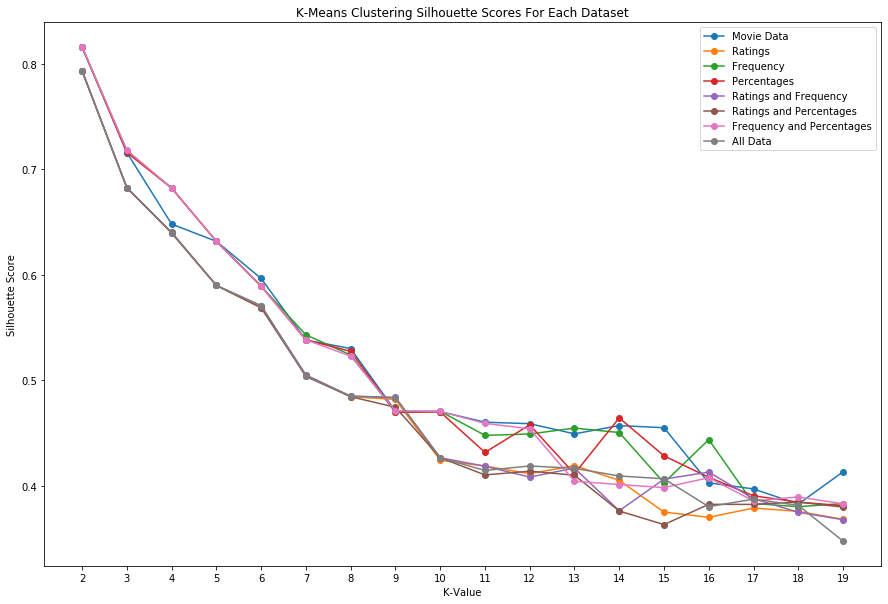

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

# The different lines we're plotting
movieplot = plt.plot(range(2, len(movies_sil_scores) + 2), movies_sil_scores, 'o-', label='Movie Data')
ratingsplot = plt.plot(range(2, len(ratings_sil_scores) + 2), ratings_sil_scores, 'o-', label='Ratings')
talliesplot = plt.plot(range(2, len(tallies_sil_scores) + 2), tallies_sil_scores, 'o-', label='Frequency')
demogrpplot = plt.plot(range(2, len(demogrp_sil_scores) + 2), demogrp_sil_scores, 'o-', label='Percentages')
ratings_tallies_plot = plt.plot(range(2, len(ratings_and_tallies_sil_scores) + 2), ratings_and_tallies_sil_scores, 'o-', label='Ratings and Frequency')
ratings_demogrp_plot = plt.plot(range(2, len(ratings_and_demogrp_sil_scores) + 2), ratings_and_demogrp_sil_scores, 'o-', label='Ratings and Percentages')
tallies_demogrp_plot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-', label='Frequency and Percentages')
allplot = plt.plot(range(2, len(all_data_sil_scores) + 2), all_data_sil_scores, 'o-', label='All Data')

# The Stylings for the plot
plt.xticks(np.arange(2, len(movies_sil_scores) + 2), range(2, len(movies_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Scores For Each Dataset')
ax.legend()
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')

# Now plot it!
plt.plot()

#### Choosing the 'best' one
It appears that the dataset with the frequency and percentages data had consistently been the highest Silhouette score before the apparent elbows around K=7 through K=11.  This will be the dataset we'll use!

## Now that we have our Optimum Dataset
Let's use the Elbow Technique to determine the best K

[]

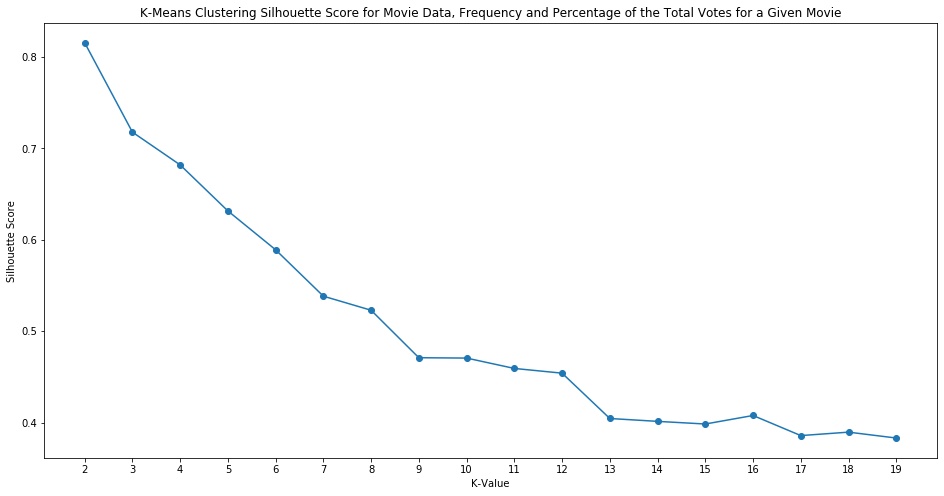

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
mainplot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-')
plt.xticks(np.arange(2, len(tallies_and_demogrp_sil_scores) + 2), range(2, len(tallies_and_demogrp_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Score for Movie Data, Frequency and Percentage of the Total Votes for a Given Movie')
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')
plt.plot()

Based on the figure above, it appears that the graph has a potential elbow at K=7 and at K=9.  While the one at K=7 has a higher Silhouette score than the one at K=9, the one at K=9 is the most well-defined cutoff.  We'll use K=9 for this one.

### t-SNE Setup

In [16]:
tsne = TSNE(verbose=1, perplexity=50, method='exact', n_jobs=-1)

### Chosen K-means Clustering

In [17]:
data = create_np_data(tallies_and_demogrp)

# Create the Training Data and Testing Data
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# t-SNE Call
tsne = TSNE(verbose=1, perplexity=50, method='exact', n_jobs=-1)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5052
[t-SNE] Computed conditional probabilities for sample 2000 / 5052
[t-SNE] Computed conditional probabilities for sample 3000 / 5052
[t-SNE] Computed conditional probabilities for sample 4000 / 5052
[t-SNE] Computed conditional probabilities for sample 5000 / 5052
[t-SNE] Computed conditional probabilities for sample 5052 / 5052
[t-SNE] Mean sigma: 178783.281187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.499057
[t-SNE] KL divergence after 1000 iterations: 0.803914


In [20]:
# Setting up the K-means model
k = 9

kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit(X_embedded)
y_train = y_pred
y_test = kmeans.predict(X_embedded)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1665666.125
Iteration 1, inertia 1223859.375
Iteration 2, inertia 1155480.625
Iteration 3, inertia 1124768.375
Iteration 4, inertia 1104236.375
Iteration 5, inertia 1095288.875
Iteration 6, inertia 1090656.25
Iteration 7, inertia 1087894.25
Iteration 8, inertia 1086138.125
Iteration 9, inertia 1085184.875
Iteration 10, inertia 1084488.625
Iteration 11, inertia 1084022.0
Iteration 12, inertia 1083765.125
Converged at iteration 12: center shift 0.1315450221300125 within tolerance 0.141137939453125.
Initialization complete
Iteration 0, inertia 1706025.625
Iteration 1, inertia 1153607.375
Iteration 2, inertia 1119768.125
Iteration 3, inertia 1105261.75
Iteration 4, inertia 1095420.75
Iteration 5, inertia 1089546.25
Iteration 6, inertia 1085532.5
Iteration 7, inertia 1082809.5
Iteration 8, inertia 1081180.25
Iteration 9, inertia 1080083.125
Iteration 10, inertia 1079655.5
Converged at iteration 10: center shift 0.12127064168453217 within toleranc

In [21]:
print(f"Silhouette Score: {metrics.silhouette_score(X_embedded, y_pred.labels_, metric='euclidean')}")

Silhouette Score: 0.43875283002853394


# Interactive Clustering Model

In [22]:
output_notebook()
y_labels = y_test

# data sources
source = ColumnDataSource(data=dict(
    x           = X_embedded[:,0], 
    y           = X_embedded[:,1],
    x_backup    = X_embedded[:,0],
    y_backup    = X_embedded[:,1],
    desc        = y_labels, 
    titles      = movies_df['title'],
    writers     = movies_df['writer'],
    actors      = movies_df['actors'],
    description = movies_df['description'],
    length      = movies_df['duration'],
    metascore   = movies_df['metascore'],
    avg_score   = movies_df['avg_vote'],
    labels      = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Writer(s)", "@writers"),
    ("Actor(s)", "@actors"),
    ("Director(s)", "@actors{safe}"),
    ("Description", "@description"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE IMDB Movie Summaries, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

#header
header = Div(text="""<h1>IMDB Movie Clusters</h1>""")

# show
show(column(header, widgetbox(), p))

Loading BokehJS ...